In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
df0 = pd.read_excel('Map.xlsx')

# EDA

In [54]:
df0['Receipt_length'] = df0['Product'].str.len()

In [55]:
quantile_025 = df0['Receipt_length'].quantile(0.0025)
print(quantile_025)
df_1 = df0[df0['Receipt_length'] > quantile_025]
#print(df.shape)
print(df_1.shape)

3.0
(25668, 11)


In [56]:
stage_codes = {
    'FRISO SR GUM': 1,
    'FRISO JR GUM': 2,
    'SB SR GUM': 3,
    'SB JR GUM': 4,
    'FF SR GUM': 5,
    'FF JR GUM': 6,
    'FRISO MUM': 7,
    'Other Product': 8
}

In [57]:
df_1['Code'] = df_1['Stage']
df_1 = df_1.replace({'Code':stage_codes})

<ipython-input-57-68fa3fc0ec36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Code'] = df_1['Stage']


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_1['Product'], 
                                                    df_1['Code'], 
                                                    test_size=0.25, 
                                                    random_state=8,
                                                   stratify=df_1['Code'])

# Vectorizer

In [59]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

## Count Vectorizer

In [60]:
from sklearn import feature_extraction
cv = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2),
                                             token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]{1,20}')

cv_train = cv.fit_transform(X_train).toarray()
cvlabels_train = y_train
print(cv_train.shape)

cv_test = cv.transform(X_test).toarray()
cvlabels_test = y_test
print(cv_test.shape)

(19251, 10000)
(6417, 10000)


In [61]:
key=pd.DataFrame(cv_train, columns = cv.get_feature_names())
key

!  !!  #  # 00000  # 00000032213001  # 00000032216001  # 000001300  \
0      0   0  0        0                 0                 0            0   
1      0   0  0        0                 0                 0            0   
2      0   0  0        0                 0                 0            0   
3      0   0  0        0                 0                 0            0   
4      0   0  0        0                 0                 0            0   
...   ..  .. ..      ...               ...               ...          ...   
19246  0   0  0        0                 0                 0            0   
19247  0   0  0        0                 0                 0            0   
19248  0   0  0        0                 0                 0            0   
19249  0   0  0        0                 0                 0            0   
19250  0   0  0        0                 0                 0            0   

       # 00000130070001  # 00000130078001  # 00000130079001  ...  zogr  zuper  \
0                     0                 0                 0  ...     0      0   
1                     0                 0                 0  ...     0      0   
2                     0                 0                 0  ...     0      0   
3                     0                 0                 0  ...     0      0   
4                     0                 0                 0  ...     0      0   
...                 ...               ...               ...  ...   ...    ...   
19246                 0                 0                 0  ...     0      0   
19247                 0                 0                 0  ...     0      0   
19248                 0                 0                 0  ...     0      0   
19249                 0                 0                 0  ...     0      0   
19250                 0                 0                 0  ...     0      0   

       zuzhu  zwit  zwitsal  zwitsal bath  zwitsal hair  zwitsal kids  |  | |  
0          0     0        0             0             0             0  0    0  
1          0     0        0             0             0             0  0    0  
2          0     0        0             0             0             0  0    0  
3          0     0        0             0             0             0  0    0  
4          0     0        0             0             0             0  0    0  
...      ...   ...      ...           ...           ...           ... ..  ...  
19246      0     0        0             0             0             0  0    0  
19247      0     0        0             0             0             0  0    0  
19248      0     0        0             0             0             0  0    0  
19249      0     0        0             0             0             0  0    0  
19250      0     0        0             0             0             0  0    0  

[19251 rows x 10000 columns]

In [62]:
from sklearn.feature_selection import chi2

for Stage, category_id in stage_codes.items():
    cv_chi2 = chi2(cv_train, cvlabels_train == category_id)
    indices = np.argsort(cv_chi2[0])
    cv_names = np.array(cv.get_feature_names())[indices]
    unigrams = [v for v in cv_names if len(v.split(' ')) == 1]
    bigrams = [v for v in cv_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Stage))
    #print(unigrams)
    #print(bigrams)
    print("  . Most correlated unigrams:\n. {}".format(', '.join(unigrams[-10:])))
    print("  . Most correlated bigrams:\n. {}".format(','.join(bigrams[-10:])))
    print("")

# 'FRISO SR GUM' category:
  . Most correlated unigrams:
. 900gr, 900, 195.000, plain, frisolac, 236,000, 8716200636155, gold, friso, 4
  . Most correlated bigrams:
. 4 400gr,4 900g,8716200636155 236,000,- 8716200636155,4 900gr,4 plain,friso 4,4 900,friso gold,gold 4

# 'FRISO JR GUM' category:
  . Most correlated unigrams:
. 900gr, 900, 266,000, 8716200636117, plain, frisolac, 8716200636070, friso, gold, 3
  . Most correlated bigrams:
. 3 400gr,3 900gr,3 900g,frisolac gold,3 400,3 900,3 plain,friso 3,friso gold,gold 3

# 'SB SR GUM' category:
  . Most correlated unigrams:
. 12.250, 600g, 150gr, 3+madu, 3p, susu, madu, pouch, bendera, 3+
  . Most correlated bigrams:
. 34 madu,bendera 34,bendera 3+madu,3+ honey,bendera 3p,3p madu,bendera 3,susu bendera,3+ madu,bendera 3+

# 'SB JR GUM' category:
  . Most correlated unigrams:
. 8992753721665, 29,000, pouch, 1p, 00000988799001, susu, 360gr, madu, bendera, 1+
  . Most correlated bigrams:
. 1+ 600,bdr 1+,# 00000988799001,00000988799001 bend

# Classification

## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [73]:
cv_lrc = LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=8, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)
cv_lrc.fit(cv_train, cvlabels_train)
cv_lrc_pred_test = cv_lrc.predict(cv_test)
cv_lrc_pred_train = cv_lrc.predict(cv_train)

C:\Users\valen02\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [74]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(cvlabels_train, cv_lrc_pred_train))

The training accuracy is: 
0.989662874655862


In [75]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(cvlabels_test, cv_lrc_pred_test))

The test accuracy is: 
0.9629110176094748


In [76]:
print("Classification report")
print(classification_report(cvlabels_test,cv_lrc_pred_test))

Classification report
              precision    recall  f1-score   support

           1       0.96      0.91      0.94       177
           2       0.94      0.95      0.94       248
           3       0.94      0.88      0.91       366
           4       0.92      0.87      0.90       209
           5       0.99      0.92      0.95       723
           6       0.95      0.97      0.96      1331
           7       1.00      0.64      0.78        22
           8       0.97      0.99      0.98      3341

    accuracy                           0.96      6417
   macro avg       0.96      0.89      0.92      6417
weighted avg       0.96      0.96      0.96      6417



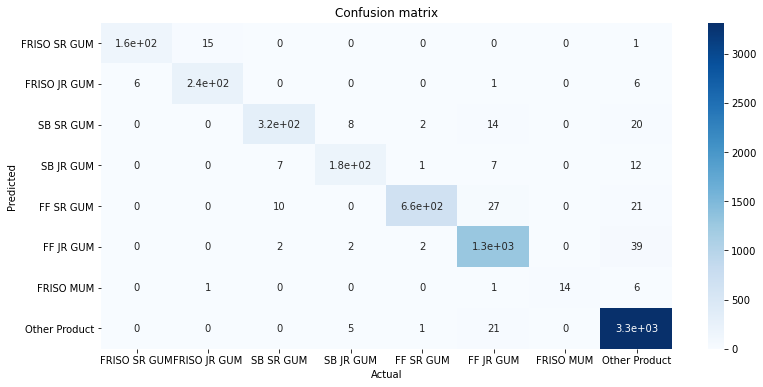

In [77]:
cv_aux_df = df_1[['Stage', 'Code']].drop_duplicates().sort_values('Code')
conf_matrix = confusion_matrix(cvlabels_test, cv_lrc_pred_test)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=cv_aux_df['Stage'].values, 
            yticklabels=cv_aux_df['Stage'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [78]:
category_names = {
    1: 'FRISO SR GUM',
    2: 'FRISO JR GUM',
    3: 'SB SR GUM',
    4: 'SB JR GUM',
    5: 'FF SR GUM',
    6: 'FF JR GUM',
    7: 'FRISO MUM',
    8: 'Other Product'
}

In [79]:
# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df_1.loc[index_X_test]

# Add the predictions
df_test['Prediction'] = cv_lrc_pred_test

# Clean columns
df_test = df_test[['No','File', 'Store_Code', 'Store_Name', 'Product', 'Confidence','OneApp','Stage','Code','Prediction']]

# Decode
df_test['Stage_Predicted'] = df_test['Prediction']
df_test = df_test.replace({'Stage_Predicted':category_names})

# Clean columns again
#df_test = df_test[['Content', 'Category', 'Category_Predicted']]

In [80]:
# Indexes of the test set
index_X_train = X_train.index

# We get them from the original df
df_train = df_1.loc[index_X_train]

# Add the predictions
df_train['Prediction'] = cv_lrc_pred_train

# Clean columns
df_train = df_train[['No','File', 'Store_Code', 'Store_Name', 'Product', 'Confidence','OneApp','Stage','Code','Prediction']]

# Decode
df_train['Stage_Predicted'] = df_train['Prediction']
df_train = df_train.replace({'Stage_Predicted':category_names})

# Clean columns again
#df_test = df_test[['Content', 'Category', 'Category_Predicted']]

In [81]:
df = pd.DataFrame()
df = pd.concat([df_train, df_test])

In [82]:
keyword = []
for i in df['Product']:
    try:
        text = [i]
        txt = cv.fit_transform(text)
        key = cv.get_feature_names()
        print(i,':')
        print(key)
        keyword.append(key)
    except:
        pass
    finally:
        key = '0'

df['Product_Key'] = keyword

PERMEN MINTZ SC CHERRY 1.00 PCS 4,900 4,900  :
['1.00', '1.00 pcs', '4,900', '4,900 4,900', 'cherry', 'cherry 1.00', 'mintz', 'mintz sc', 'pcs', 'pcs 4,900', 'permen', 'permen mintz', 'sc', 'sc cherry']
DISC Member 1% 696-ITEN #00000130104001 FRISIANF 456 MADU200 18.450 Disc Member 1% 184  :
['#00000130104001', '#00000130104001 frisianf', '1%', '1% 184', '1% 696-iten', '18.450', '18.450 disc', '184', '456', '456 madu200', '696-iten', '696-iten #00000130104001', 'disc', 'disc member', 'frisianf', 'frisianf 456', 'madu200', 'madu200 18.450', 'member', 'member 1%']
8716200636070 1 X 280.900 280.900 FRISO GOLD 3 VANILLA TIN 900GR  :
['1', '1 x', '280.900', '280.900 280.900', '280.900 friso', '3', '3 vanilla', '8716200636070', '8716200636070 1', '900gr', 'friso', 'friso gold', 'gold', 'gold 3', 'tin', 'tin 900gr', 'vanilla', 'vanilla tin', 'x', 'x 280.900']
8716200636155 1 X 176,400 176.400 FRISO GOLD 4 VANILA TIN 900GR  :
['1', '1 x', '176,400', '176,400 176.400', '176.400', '176.400 friso

0545621 FRISIAN  :
['0545621', '0545621 frisian', 'frisian']
MERRJES PANTS GOOD SKIN XL1 (SCH) -8992727005425  :
['(sch)', '(sch) -8992727005425', '-8992727005425', 'good', 'good skin', 'merrjes', 'merrjes pants', 'pants', 'pants good', 'skin', 'skin xl1', 'xl1', 'xl1 (sch)']
1 PCS X 83.000= 83.000 ESKULINHS BLUE SOML PCS X 11.000- 11.000  :
['1', '1 pcs', '11.000', '11.000-', '11.000- 11.000', '83.000', '83.000 eskulinhs', '83.000=', '83.000= 83.000', 'blue', 'blue soml', 'eskulinhs', 'eskulinhs blue', 'pcs', 'pcs x', 'soml', 'soml pcs', 'x', 'x 11.000-', 'x 83.000=']
83.000 PRIMAGRO 3+ VA B00GR 1 PCS X 83.000-  :
['1', '1 pcs', '3+', '3+ va', '83.000', '83.000 primagro', '83.000-', 'b00gr', 'b00gr 1', 'pcs', 'pcs x', 'primagro', 'primagro 3+', 'va', 'va b00gr', 'x', 'x 83.000-']
623048 SARDEN ABC CHI 3.230 24.750  :
['24.750', '3.230', '3.230 24.750', '623048', '623048 sarden', 'abc', 'abc chi', 'chi', 'chi 3.230', 'sarden', 'sarden abc']
9,800 9711 ENERGEN COKLAT SACHA 168751 FF PRI

GULA PASIR KUNING 1KG NO.2 2,00 X 212.000 25.200  :
['1kg', '1kg no.2', '2,00', '2,00 x', '212.000', '212.000 25.200', '25.200', 'gula', 'gula pasir', 'kuning', 'kuning 1kg', 'no.2', 'no.2 2,00', 'pasir', 'pasir kuning', 'x', 'x 212.000']
SAUSO BENDERA 156. CHOD  :
['156.', '156. chod', 'bendera', 'bendera 156.', 'chod', 'sauso', 'sauso bendera']
01273625 BENDERA 123 400GR MADU 1 PCS X 47.750 47.750  :
['01273625', '01273625 bendera', '1', '1 pcs', '123', '123 400gr', '400gr', '400gr madu', '47.750', '47.750 47.750', 'bendera', 'bendera 123', 'madu', 'madu 1', 'pcs', 'pcs x', 'x', 'x 47.750']
0071516 PORSTEX WL 500 ML 111,300 RANITA C.BUDS  :
['0071516', '0071516 porstex', '111,300', '111,300 ranita', '500', '500 ml', 'c.buds', 'ml', 'ml 111,300', 'porstex', 'porstex wl', 'ranita', 'ranita c.buds', 'wl', 'wl 500']
1 €31,000 = ICE BON BON COKLAT 400 GR/24 [080512) 31,000 1 x 23,100 = 8,100 SPIK MIE GORENG PREMIUM 50GR/ :
['080512)', '080512) 31,000', '1', '1 31,000', '1 x', '23,100', '2

00131010 CHILOR 150ML/36  :
['00131010', '00131010 chilor', '150ml', '150ml 36', '36', 'chilor', 'chilor 150ml']
FRISOLAC GOLD 3 400 GR - 8716200636117  :
['-', '- 8716200636117', '3', '3 400', '400', '400 gr', '8716200636117', 'frisolac', 'frisolac gold', 'gold', 'gold 3', 'gr', 'gr -']
ITEM # 00000130079001 FRISIANF 123 COK800G 94.250 HERAN 21 RP.79950 14.300- :
['#', '# 00000130079001', '00000130079001', '00000130079001 frisianf', '123', '123 cok800g', '14.300-', '21', '21 rp.79950', '94.250', '94.250 heran', 'cok800g', 'cok800g 94.250', 'frisianf', 'frisianf 123', 'heran', 'heran 21', 'item', 'item #', 'rp.79950', 'rp.79950 14.300-']
4X 44.600 2382152 F/F 3/1 1-3 VN4 178.400 Discount  :
['1', '1 1-3', '1-3', '1-3 vn4', '178.400', '178.400 discount', '2382152', '2382152 f', '3', '3 1', '44.600', '44.600 2382152', '4x', '4x 44.600', 'discount', 'f', 'f 3', 'f f', 'vn4', 'vn4 178.400']
11800178 - BUMBU ROYCO 9GR AYAM/12BJ 2 x 5,075 10,150 13000443 - CHARM SC NIGHT W 29CM 20 S  :
['-',

BIANG 12'S MR 5.000  :
['12', '12 s', '5.000', 'biang', 'biang 12', 'mr', 'mr 5.000', 's', 's mr']
8992753016716,2 BOTOL 400ML 8999999036348,1 x 13,600 RR PWD NAT ALOV 13,600  :
['13,600', '13,600 rr', '400ml', '400ml 8999999036348,1', '8992753016716,2', '8992753016716,2 botol', '8999999036348,1', '8999999036348,1 x', 'alov', 'alov 13,600', 'botol', 'botol 400ml', 'nat', 'nat alov', 'pwd', 'pwd nat', 'rr', 'rr pwd', 'x', 'x 13,600']
BENDER 3+ MADU 900 GR POUCH 1 PCS 65,900 3,295 = 62, 605  :
['1', '1 pcs', '3+', '3+ madu', '3,295', '3,295 =', '605', '62,', '62, 605', '65,900', '65,900 3,295', '900', '900 gr', '=', '= 62,', 'bender', 'bender 3+', 'gr', 'gr pouch', 'madu', 'madu 900', 'pcs', 'pcs 65,900', 'pouch', 'pouch 1']
BENDERA JELAJAH 1-3 COKLAT 400GR 1 Х 48 50 48.500  :
['1', '1 48', '1-3', '1-3 coklat', '400gr', '400gr 1', '48', '48 50', '48.500', '50', '50 48.500', 'bendera', 'bendera jelajah', 'coklat', 'coklat 400gr', 'jelajah', 'jelajah 1-3']
03 CRANE  :
['03', '03 crane', 'c

BDR 1+MADU 900 1,00 65.860 65.860  :
['1+madu', '1+madu 900', '1,00', '1,00 65.860', '65.860', '65.860 65.860', '900', '900 1,00', 'bdr', 'bdr 1+madu']
BENDERA 3PLUS NADU 15008 POUCH 1 POUCH 13,500  :
['1', '1 pouch', '13,500', '15008', '15008 pouch', '3plus', '3plus nadu', 'bendera', 'bendera 3plus', 'nadu', 'nadu 15008', 'pouch', 'pouch 1', 'pouch 13,500']
15320 KN KARTKA LG STORANTE 1556094 SKIN RAPIKA FEL  :
['15320', '15320 kn', '1556094', '1556094 skin', 'fel', 'kartka', 'kartka lg', 'kn', 'kn kartka', 'lg', 'lg storante', 'rapika', 'rapika fel', 'skin', 'skin rapika', 'storante', 'storante 1556094']
2,00 X 2.000,00 4.000,00 161090 SOKLIN SOFTERCÉNT 4.350  :
['161090', '161090 soklin', '2,00', '2,00 x', '2.000,00', '2.000,00 4.000,00', '4.000,00', '4.000,00 161090', '4.350', 'nt', 'nt 4.350', 'softerc', 'softerc nt', 'soklin', 'soklin softerc', 'x', 'x 2.000,00']
701073 BENDERA 123 MADU 400KTK 47,950  :
['123', '123 madu', '400ktk', '400ktk 47,950', '47,950', '701073', '701073 be

& BENDERA 1 MADU 600GR POUCH 010273 1X 45.095 3 YUPI i10 GR STRAW KISS BAG  :
['&', '& bendera', '010273', '010273 1x', '1', '1 madu', '1x', '1x 45.095', '3', '3 yupi', '45.095', '45.095 3', '600gr', '600gr pouch', 'bag', 'bendera', 'bendera 1', 'gr', 'gr straw', 'i10', 'i10 gr', 'kiss', 'kiss bag', 'madu', 'madu 600gr', 'pouch', 'pouch 010273', 'straw', 'straw kiss', 'yupi', 'yupi i10']
BENDERA 123 CHOCO 800 GR 93.725  :
['123', '123 choco', '800', '800 gr', '93.725', 'bendera', 'bendera 123', 'choco', 'choco 800', 'gr', 'gr 93.725']
S0000240 FF PRIMAGRO 1 MADU 800G 2 Pcs 85,000 170,000  :
['1', '1 madu', '170,000', '2', '2 pcs', '800g', '800g 2', '85,000', '85,000 170,000', 'ff', 'ff primagro', 'madu', 'madu 800g', 'pcs', 'pcs 85,000', 'primagro', 'primagro 1', 's0000240', 's0000240 ff']
119,600 FIESTA TEPUNG BUMBU AYAM GORENG BOGR ( 3 PCS X 3,700 11,100  :
['(', '( 3', '11,100', '119,600', '119,600 fiesta', '3', '3 pcs', '3,700', '3,700 11,100', 'ayam', 'ayam goreng', 'bogr', 'bogr 

ITEM # 00000136717001 CHARM MAXI W 23_20S 15.500  :
['#', '# 00000136717001', '00000136717001', '00000136717001 charm', '15.500', '20s', '20s 15.500', '23', '23 20s', 'charm', 'charm maxi', 'item', 'item #', 'maxi', 'maxi w', 'w', 'w 23']
02044812/PEPS 190 WHITE 2.00 X “ 19700  :
['02044812', '02044812 peps', '190', '190 white', '19700', '2.00', '2.00 x', 'peps', 'peps 190', 'white', 'white 2.00', 'x', 'x 19700']
BENDERA 3+ PCH MADU 600G , 100 18,200 BF EXTRA COMFORT MAXI 23NW 26P  :
[',', ', 100', '100', '100 18,200', '18,200', '18,200 bf', '23nw', '23nw 26p', '26p', '3+', '3+ pch', '600g', '600g ,', 'bendera', 'bendera 3+', 'bf', 'bf extra', 'comfort', 'comfort maxi', 'extra', 'extra comfort', 'madu', 'madu 600g', 'maxi', 'maxi 23nw', 'pch', 'pch madu']
✓ 91.900- 91.900 FRISIAN 123 CHOCHO  :
['123', '123 chocho', '91.900', '91.900 frisian', '91.900-', '91.900- 91.900', 'chocho', 'frisian', 'frisian 123']
FRISIAN F PRIMAGRO 3+ 150G MADU - 24/CTN 1 PCSX 18.500 18.500  :
['-', '- 24', '

14100472 - EKUNUM YUU VIOLE 2x 4,425 4,850  :
['-', '- ekunum', '14100472', '14100472 -', '2x', '2x 4,425', '4,425', '4,425 4,850', '4,850', 'ekunum', 'ekunum yuu', 'viole', 'viole 2x', 'yuu', 'yuu viole']
48.000 3+ CHOCO 24x480 GR 47511914 1X 49.680  :
['1x', '1x 49.680', '24x480', '24x480 gr', '3+', '3+ choco', '47511914', '47511914 1x', '48.000', '48.000 3+', '49.680', 'choco', 'choco 24x480', 'gr', 'gr 47511914']
MOLTO EDP 10 P 1.00 4,800 EDP 10 P1.00 4,800 4,800 11,900 11,900  :
['1.00', '1.00 4,800', '10', '10 p', '10 p1.00', '11,900', '11,900 11,900', '4,800', '4,800 11,900', '4,800 4,800', '4,800 edp', 'edp', 'edp 10', 'molto', 'molto edp', 'p', 'p 1.00', 'p1.00', 'p1.00 4,800']
FRISO GOLD THP 4 400GR/PC 1X 103,500 103.50  :
['103,500', '103,500 103.50', '103.50', '1x', '1x 103,500', '4', '4 400gr', '400gr', '400gr pc', 'friso', 'friso gold', 'gold', 'gold thp', 'pc', 'pc 1x', 'thp', 'thp 4']
1222821-VIDORAN KIDS MILK UH 4.00 X 2.500 1222820 :
['1222820', '1222821-vidoran', '12

00057085 2.000 SOFTEX P-LINER SIRIH+GREEN TEA 20 00232807 6.500 6.500 PUTRI CINTA SANTAN BUBUK RENCENG 10X13G  :
['00057085', '00057085 2.000', '00232807', '00232807 6.500', '10x13g', '2.000', '2.000 softex', '20', '20 00232807', '6.500', '6.500 6.500', '6.500 putri', 'bubuk', 'bubuk renceng', 'cinta', 'cinta santan', 'p-liner', 'p-liner sirih+green', 'putri', 'putri cinta', 'renceng', 'renceng 10x13g', 'santan', 'santan bubuk', 'sirih+green', 'sirih+green tea', 'softex', 'softex p-liner', 'tea', 'tea 20']
ITEM # 00000988854001 BENDERA 3P MADU 600G 44.950 Disc Member 1%  :
['#', '# 00000988854001', '00000988854001', '00000988854001 bendera', '1%', '3p', '3p madu', '44.950', '44.950 disc', '600g', '600g 44.950', 'bendera', 'bendera 3p', 'disc', 'disc member', 'item', 'item #', 'madu', 'madu 600g', 'member', 'member 1%']
59.900 BODO 23 JANT  :
['23', '23 jant', '59.900', '59.900 bodo', 'bodo', 'bodo 23', 'jant']
------COPY--- BENDERA 456 VANILLA 400 GR 1 x 45.450 45.450 KUNCI MAS MINYAK 

2402225 4X 78.000 123 MADU 170GR ✓ 2402691 x 19.700 19.700 SAKATONIK ABC JERUK  :
['123', '123 madu', '170gr', '170gr 2402691', '19.700', '19.700 19.700', '19.700 sakatonik', '2402225', '2402225 4x', '2402691', '2402691 x', '4x', '4x 78.000', '78.000', '78.000 123', 'abc', 'abc jeruk', 'jeruk', 'madu', 'madu 170gr', 'sakatonik', 'sakatonik abc', 'x', 'x 19.700']
11,650 7. JETZ SWEET CHOCOFIESTA 12G 5,000 8.FRESCO KOPI KRIM SUSU x 1,000  :
['1,000', '11,650', '11,650 7.', '12g', '12g 5,000', '5,000', '5,000 8.fresco', '7.', '7. jetz', '8.fresco', '8.fresco kopi', 'chocofiesta', 'chocofiesta 12g', 'jetz', 'jetz sweet', 'kopi', 'kopi krim', 'krim', 'krim susu', 'susu', 'susu x', 'sweet', 'sweet chocofiesta', 'x', 'x 1,000']
48,000 123 MADU 400 G  :
['123', '123 madu', '400', '400 g', '48,000', '48,000 123', 'g', 'madu', 'madu 400']
ITEM # 00000150115001 FRISIANF 456 MADUBOO 89.250  :
['#', '# 00000150115001', '00000150115001', '00000150115001 frisianf', '456', '456 maduboo', '89.250', 'fr

67,000 PRIMAGRO 1 MADU 1200G 1 Pcs 127,000 67,000 127,000  :
['1', '1 madu', '1 pcs', '1200g', '1200g 1', '127,000', '127,000 67,000', '67,000', '67,000 127,000', '67,000 primagro', 'madu', 'madu 1200g', 'pcs', 'pcs 127,000', 'primagro', 'primagro 1']
BH BDR SB 3 MADU 600G 42,000  :
['3', '3 madu', '42,000', '600g', '600g 42,000', 'bdr', 'bdr sb', 'bh', 'bh bdr', 'madu', 'madu 600g', 'sb', 'sb 3']
---- 1217100-FL PRIMAGRO 11MD 120 133.500  :
['----', '---- 1217100-fl', '11md', '11md 120', '120', '120 133.500', '1217100-fl', '1217100-fl primagro', '133.500', 'primagro', 'primagro 11md']
1.FF PRIMAGRO 1+ HONEY IMP FF PRIMAGO 1-3 HONEY 400G 47,950 BUNYI BONEKA 37,000  :
['1+', '1+ honey', '1-3', '1-3 honey', '1.ff', '1.ff primagro', '37,000', '400g', '400g 47,950', '47,950', '47,950 bunyi', 'boneka', 'boneka 37,000', 'bunyi', 'bunyi boneka', 'ff', 'ff primago', 'honey', 'honey 400g', 'honey imp', 'imp', 'imp ff', 'primago', 'primago 1-3', 'primagro', 'primagro 1+']
FF PRIMAGRO 3+ MADU 120

GRAND SWALAVAN SURYAKENCANA NO.102 BOGOR 8992753016709 BENDERA PRI I+VN1200 X 138,000 138,000  :
['138,000', '138,000 138,000', '8992753016709', '8992753016709 bendera', 'bendera', 'bendera pri', 'bogor', 'bogor 8992753016709', 'grand', 'grand swalavan', 'i+vn1200', 'i+vn1200 x', 'no.102', 'no.102 bogor', 'pri', 'pri i+vn1200', 'suryakencana', 'suryakencana no.102', 'swalavan', 'swalavan suryakencana', 'x', 'x 138,000']
ITEM # 0000013925E001 VITALIS BM PLESS 120 21.950  :
['#', '# 0000013925e001', '0000013925e001', '0000013925e001 vitalis', '120', '120 21.950', '21.950', 'bm', 'bm pless', 'item', 'item #', 'pless', 'pless 120', 'vitalis', 'vitalis bm']
0545676 FRISIAN FL BENDERA  :
['0545676', '0545676 frisian', 'bendera', 'fl', 'fl bendera', 'frisian', 'frisian fl']
0545623 FRISIAN FL 456/ PRIMAER 3+ 第 187.900  :
['0545623', '0545623 frisian', '187.900', '3+', '3+ 187.900', '456', '456 primaer', 'fl', 'fl 456', 'frisian', 'frisian fl', 'primaer', 'primaer 3+']
3 FRISOLAC GOLD 3 900 GR

022521 2002753721090 FF SUSU DODO BENDERA 34 MS 360 G  :
['022521', '022521 2002753721090', '2002753721090', '2002753721090 ff', '34', '34 ms', '360', '360 g', 'bendera', 'bendera 34', 'dodo', 'dodo bendera', 'ff', 'ff susu', 'g', 'ms', 'ms 360', 'susu', 'susu dodo']
S0000244 FF PRIMAGRO 1 VANILA 800G 1 Pcs 85,000 85,000  :
['1', '1 pcs', '1 vanila', '800g', '800g 1', '85,000', '85,000 85,000', 'ff', 'ff primagro', 'pcs', 'pcs 85,000', 'primagro', 'primagro 1', 's0000244', 's0000244 ff', 'vanila', 'vanila 800g']
FRISO GOLD 4 40 1,00 117,780  :
['1,00', '1,00 117,780', '117,780', '4', '4 40', '40', '40 1,00', 'friso', 'friso gold', 'gold', 'gold 4']
93189329562 MOMY POKU SLIM XL234  :
['93189329562', '93189329562 momy', 'momy', 'momy poku', 'poku', 'poku slim', 'slim', 'slim xl234', 'xl234']
SWGN.21.06.00270 FF PRIMAGRO 1+ MADU 800 GR 8992753283705 1 PCS ~ 2,000 92,000  :
['1', '1 pcs', '1+', '1+ madu', '2,000', '2,000 92,000', '800', '800 gr', '8992753283705', '8992753283705 1', '92,00

F-FLAG PRIMAGRO 1+ VANILA BOX 150GR PCS 8992753721139 1x20050 20,050  :
['1+', '1+ vanila', '150gr', '150gr pcs', '1x20050', '1x20050 20,050', '20,050', '8992753721139', '8992753721139 1x20050', 'box', 'box 150gr', 'f-flag', 'f-flag primagro', 'pcs', 'pcs 8992753721139', 'primagro', 'primagro 1+', 'vanila', 'vanila box']
FRISIAN FLAG 1200g 1-3 MADU x@ 132.000,- 132.000 :
['1-3', '1-3 madu', '1200g', '1200g 1-3', '132.000', '132.000,-', '132.000,- 132.000', 'flag', 'flag 1200g', 'frisian', 'frisian flag', 'madu', 'madu x@', 'x@', 'x@ 132.000,-']
BENDERA 456 COKLAT 800 GR 17564531 1X 78.500 78.500 456 CORAL 800 GR  :
['17564531', '17564531 1x', '1x', '1x 78.500', '456', '456 coklat', '456 coral', '78.500', '78.500 456', '78.500 78.500', '800', '800 gr', 'bendera', 'bendera 456', 'coklat', 'coklat 800', 'coral', 'coral 800', 'gr', 'gr 17564531']
MY ROHY SIP BURC 53010200795.CINTSERT TRDIA  :
['53010200795.cintsert', '53010200795.cintsert trdia', 'burc', 'burc 53010200795.cintsert', 'my', 

SUMLAR ITEM  :
['item', 'sumlar', 'sumlar item']
BENDERA 456 VANILLA 400 GR 1 x 45.450  :
['1', '1 x', '400', '400 gr', '45.450', '456', '456 vanilla', 'bendera', 'bendera 456', 'gr', 'gr 1', 'vanilla', 'vanilla 400', 'x', 'x 45.450']
#SOHCNRE.21.06.00751 FRIMAGRO 1+ MADU 800 GR B982753283705 Total (1 item) :Rp  :
['#sohcnre.21.06.00751', '#sohcnre.21.06.00751 frimagro', '(1', '(1 item)', '1+', '1+ madu', '800', '800 gr', ':rp', 'b982753283705', 'b982753283705 total', 'frimagro', 'frimagro 1+', 'gr', 'gr b982753283705', 'item)', 'item) :rp', 'madu', 'madu 800', 'total', 'total (1']
FF PRIMAGRO 3+ MADU 800 GR - 8992753883707 89,500  :
['-', '- 8992753883707', '3+', '3+ madu', '800', '800 gr', '89,500', '8992753883707', '8992753883707 89,500', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 800', 'primagro', 'primagro 3+']
FF 1 2 3 400 GR COKLAT  :
['1', '1 2', '2', '2 3', '3', '3 400', '400', '400 gr', 'coklat', 'ff', 'ff 1', 'gr', 'gr coklat']
BENDERA 123 CKT.400 330521 -> 1 x 47,675 

['1.00', '1.00 x', '145.790', '145.790 145.790', '3', '3 400g', '400g', '400g 1.00', 'friso', 'friso gold', 'gold', 'gold 3', 'x', 'x 145.790']
IBRIN 3K 518 85 ML 199’S  :
['199', '199 s', '3k', '3k 518', '518', '518 85', '85', '85 ml', 'ibrin', 'ibrin 3k', 'ml', 'ml 199', 's']
FRISO 3 PLAIN 400 12 0036117 2141,300 141,300  :
['0036117', '0036117 2141,300', '12', '12 0036117', '141,300', '2141,300', '2141,300 141,300', '3', '3 plain', '400', '400 12', 'friso', 'friso 3', 'plain', 'plain 400']
5.750 3,20 DISPENSER PENCET PUTIH PO REFIMA 250GR  :
['250gr', '3,20', '3,20 dispenser', '5.750', '5.750 3,20', 'dispenser', 'dispenser pencet', 'pencet', 'pencet putih', 'po', 'po refima', 'putih', 'putih po', 'refima', 'refima 250gr']
KRESEK GM BESAR POLOS  :
['besar', 'besar polos', 'gm', 'gm besar', 'kresek', 'kresek gm', 'polos']
TEH PUCUK HARUM 350ML (24) 7,500  :
['(24)', '(24) 7,500', '350ml', '350ml (24)', '7,500', 'harum', 'harum 350ml', 'pucuk', 'pucuk harum', 'teh', 'teh pucuk']
ITEM #

SUSU BENDERA FF 123 VANILA 2000 80.000 80.000  :
['123', '123 vanila', '2000', '2000 80.000', '80.000', '80.000 80.000', 'bendera', 'bendera ff', 'ff', 'ff 123', 'susu', 'susu bendera', 'vanila', 'vanila 2000']
BENDERA 1+ VANILA 1200GR PRIMAGRO 010242 1X 136.815 136.815  :
['010242', '010242 1x', '1+', '1+ vanila', '1200gr', '1200gr primagro', '136.815', '136.815 136.815', '1x', '1x 136.815', 'bendera', 'bendera 1+', 'primagro', 'primagro 010242', 'vanila', 'vanila 1200gr']
2.400 :
['2.400']
SPM41 Disc.15% # 00000130097001 ✓ 94.250 FRISIANF 123 MADU800 1% 942- :
['#', '# 00000130097001', '00000130097001', '00000130097001 94.250', '1%', '1% 942-', '123', '123 madu800', '94.250', '94.250 frisianf', '942-', 'disc.15%', 'disc.15% #', 'frisianf', 'frisianf 123', 'madu800', 'madu800 1%', 'spm41', 'spm41 disc.15%']
WOH KHOLILO . 226. 8-644 :
['.', '. 226.', '226.', '226. 8-644', '8-644', 'kholilo', 'kholilo .', 'woh', 'woh kholilo']
ITEM # 00000148874001 KODOMO SG 2IN1 REG 8.150  :
['#', '# 0

2x 2,200 4,400 DAIA PUL DET CLEAN&FRESH 320G/PCS 5X 4,700 23,500 BENDERA 1+ MADU 500G/RCSV  :
['1+', '1+ madu', '2,200', '2,200 4,400', '23,500', '23,500 bendera', '2x', '2x 2,200', '320g', '320g pcs', '4,400', '4,400 daia', '4,700', '4,700 23,500', '500g', '500g rcsv', '5x', '5x 4,700', 'bendera', 'bendera 1+', 'clean&fresh', 'clean&fresh 320g', 'daia', 'daia pul', 'det', 'det clean&fresh', 'madu', 'madu 500g', 'pcs', 'pcs 5x', 'pul', 'pul det', 'rcsv']
130428 1x 13.375 140011 24 11.995 GULA PASIR KUNI 14G/LOKAL 23.990 INDOMIE AYAM SPECIAL-SA  :
['11.995', '11.995 gula', '13.375', '13.375 140011', '130428', '130428 1x', '140011', '140011 24', '14g', '14g lokal', '1x', '1x 13.375', '23.990', '23.990 indomie', '24', '24 11.995', 'ayam', 'ayam special-sa', 'gula', 'gula pasir', 'indomie', 'indomie ayam', 'kuni', 'kuni 14g', 'lokal', 'lokal 23.990', 'pasir', 'pasir kuni', 'special-sa']
MADU170 19.950 ITEM # 00000138409001 SELAMAT WAFER 1986 12.450 ITEM # 00000137297001  :
['#', '# 0000013

Cotra 10244 FF PRIMADRO 1 VANILA 800L 1 PES 85.000  :
['1', '1 pes', '1 vanila', '10244', '10244 ff', '800l', '800l 1', '85.000', 'cotra', 'cotra 10244', 'ff', 'ff primadro', 'pes', 'pes 85.000', 'primadro', 'primadro 1', 'vanila', 'vanila 800l']
BENDERA JELAJAH MADU 170 GR 1.00 X @19.650 19.650  :
['1.00', '1.00 x', '170', '170 gr', '19.650', '@19.650', '@19.650 19.650', 'bendera', 'bendera jelajah', 'gr', 'gr 1.00', 'jelajah', 'jelajah madu', 'madu', 'madu 170', 'x', 'x @19.650']
PERDERA 3+ MADU 600 GR POUCH 1,00 X 240.590  :
['1,00', '1,00 x', '240.590', '3+', '3+ madu', '600', '600 gr', 'gr', 'gr pouch', 'madu', 'madu 600', 'perdera', 'perdera 3+', 'pouch', 'pouch 1,00', 'x', 'x 240.590']
11854.5/MYBABY SP75 G&G 3.175 = 5.350 %  :
['%', '11854.5', '11854.5 mybaby', '3.175', '3.175 =', '5.350', '5.350 %', '=', '= 5.350', 'g&g', 'g&g 3.175', 'mybaby', 'mybaby sp75', 'sp75', 'sp75 g&g']
002243 BENDERA 456 CKL 400GR 1 X 45.850 = 45.850  :
['002243', '002243 bendera', '1', '1 x', '400gr

991OL THOQOI .  :
['.', '991ol', '991ol thoqoi', 'thoqoi', 'thoqoi .']
PCS FRENCH FRIES 2000 150GR ( 2326096 ) 1 PCS X 11.500 - 11,500  :
['(', '( 2326096', ')', ') 1', '-', '- 11,500', '1', '1 pcs', '11,500', '11.500', '11.500 -', '150gr', '150gr (', '2000', '2000 150gr', '2326096', '2326096 )', 'french', 'french fries', 'fries', 'fries 2000', 'pcs', 'pcs french', 'pcs x', 'x', 'x 11.500']
PEPSODENT 190 gr JUMBO 003004- SOKLIN  :
['003004-', '003004- soklin', '190', '190 gr', 'gr', 'gr jumbo', 'jumbo', 'jumbo 003004-', 'pepsodent', 'pepsodent 190', 'soklin']
ITEM # 00000752177001 FRISO GOLD 4 9006 259.950 20.000  :
['#', '# 00000752177001', '00000752177001', '00000752177001 friso', '20.000', '259.950', '259.950 20.000', '4', '4 9006', '9006', '9006 259.950', 'friso', 'friso gold', 'gold', 'gold 4', 'item', 'item #']
CB CREAM SOG FRESH NOURISH 1 PCS  :
['1', '1 pcs', 'cb', 'cb cream', 'cream', 'cream sog', 'fresh', 'fresh nourish', 'nourish', 'nourish 1', 'pcs', 'sog', 'sog fresh']
000

FF PRIMAGRO 3+ MADU 800 GR-8992753883707 88,500  :
['3+', '3+ madu', '800', '800 gr-8992753883707', '88,500', 'ff', 'ff primagro', 'gr-8992753883707', 'gr-8992753883707 88,500', 'madu', 'madu 800', 'primagro', 'primagro 3+']
PLK/191.152/TONG TJI CLP WO=  :
['191.152', '191.152 tong', 'clp', 'clp wo=', 'plk', 'plk 191.152', 'tji', 'tji clp', 'tong', 'tong tji', 'wo=']
703296 BENDERA 3+ MADU 360GR 1.00 PCS X 26,550 26,550  :
['1.00', '1.00 pcs', '26,550', '26,550 26,550', '3+', '3+ madu', '360gr', '360gr 1.00', '703296', '703296 bendera', 'bendera', 'bendera 3+', 'madu', 'madu 360gr', 'pcs', 'pcs x', 'x', 'x 26,550']
FRISIAN FLAG 3+ MADU 600 GR 1.00 X 243.400 : 43.400  :
['1.00', '1.00 x', '243.400', '243.400 :', '3+', '3+ madu', '43.400', '600', '600 gr', ':', ': 43.400', 'flag', 'flag 3+', 'frisian', 'frisian flag', 'gr', 'gr 1.00', 'madu', 'madu 600', 'x', 'x 243.400']
3.450  :
['3.450']
FF PRIMAGRO 1+ VANILA 800 GR - 8992753281701 89,500  :
['-', '- 8992753281701', '1+', '1+ vanila',

['-', '- 8992753016747', '1200', '1200 gr', '129,000', '3+', '3+ madu', '8992753016747', '8992753016747 129,000', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 1200', 'primagro', 'primagro 3+']
49.500V 400 COK  :
['400', '400 cok', '49.500v', '49.500v 400', 'cok']
BENDERA 1+ MADU 360GR POUCH 010274 1X 27.915  :
['010274', '010274 1x', '1+', '1+ madu', '1x', '1x 27.915', '27.915', '360gr', '360gr pouch', 'bendera', 'bendera 1+', 'madu', 'madu 360gr', 'pouch', 'pouch 010274']
HEMART 1L BTL 14.600  :
['14.600', '1l', '1l btl', 'btl', 'btl 14.600', 'hemart', 'hemart 1l']
00500019 FF Primagro 1+/123 1 19.995 OCTO0019 HATARI Cocopuff 170g 4.695 06100105 HATARI Twins 200gr C  :
['00500019', '00500019 ff', '06100105', '06100105 hatari', '1', '1 19.995', '1+', '1+ 123', '123', '123 1', '170g', '170g 4.695', '19.995', '19.995 octo0019', '200gr', '200gr c', '4.695', '4.695 06100105', 'c', 'cocopuff', 'cocopuff 170g', 'ff', 'ff primagro', 'hatari', 'hatari cocopuff', 'hatari twins', 'octo0019',

ITEM # 00000479705001 ANEKSPMNSONS 1907 12.950 9.500 Disc Member 12 95- :
['#', '# 00000479705001', '00000479705001', '00000479705001 anekspmnsons', '12', '12 95-', '12.950', '12.950 9.500', '1907', '1907 12.950', '9.500', '9.500 disc', '95-', 'anekspmnsons', 'anekspmnsons 1907', 'disc', 'disc member', 'item', 'item #', 'member', 'member 12']
6386001026025 ASTOR CHOCO 150GR 10,250  :
['10,250', '150gr', '150gr 10,250', '6386001026025', '6386001026025 astor', 'astor', 'astor choco', 'choco', 'choco 150gr']
18,20 BENDERA 456 MADU 200 330519 -> 1 X 18,200  :
['->', '-> 1', '1', '1 x', '18,20', '18,20 bendera', '18,200', '200', '200 330519', '330519', '330519 ->', '456', '456 madu', 'bendera', 'bendera 456', 'madu', 'madu 200', 'x', 'x 18,200']
308011 FRISO MUM 400GR VANIL 95,495  :
['308011', '308011 friso', '400gr', '400gr vanil', '95,495', 'friso', 'friso mum', 'mum', 'mum 400gr', 'vanil', 'vanil 95,495']
FRISO GOLD 3 900G 1 144,995 144,995  :
['1', '1 144,995', '144,995', '144,995 144,

FRISIAN FLAG 456 VANILA 4DOGR ( 2302116 ) 1 PCSX 44,200 44,200  :
['(', '( 2302116', ')', ') 1', '1', '1 pcsx', '2302116', '2302116 )', '44,200', '44,200 44,200', '456', '456 vanila', '4dogr', '4dogr (', 'flag', 'flag 456', 'frisian', 'frisian flag', 'pcsx', 'pcsx 44,200', 'vanila', 'vanila 4dogr']
GREEN TISSUE FACIAL 200 : BD/ 70GR AYAM BWO:PCS; 6,250  :
['200', '200 :', '6,250', '70gr', '70gr ayam', ':', ': bd', 'ayam', 'ayam bwo:pcs;', 'bd', 'bd 70gr', 'bwo:pcs;', 'bwo:pcs; 6,250', 'facial', 'facial 200', 'green', 'green tissue', 'tissue', 'tissue facial']
0041079 SUSU BENDERA 1+MADU POUCH 900G 1 X Rp 68.915 = Rp. 68.915 SUB TOTAL 68  :
['0041079', '0041079 susu', '1', '1 x', '1+madu', '1+madu pouch', '68', '68.915', '68.915 =', '68.915 sub', '900g', '900g 1', '=', '= rp.', 'bendera', 'bendera 1+madu', 'pouch', 'pouch 900g', 'rp', 'rp 68.915', 'rp.', 'rp. 68.915', 'sub', 'sub total', 'susu', 'susu bendera', 'total', 'total 68', 'x', 'x rp']
Discount % F/ FS/J 1-3 VNL 800 83.000- :
[

ABC KOP MASRET 520 IN RP.16400 3.900  :
['3.900', '520', '520 in', 'abc', 'abc kop', 'in', 'in rp.16400', 'kop', 'kop masret', 'masret', 'masret 520', 'rp.16400', 'rp.16400 3.900']
2003 MANY POD PANTS STANDAO  :
['2003', '2003 many', 'many', 'many pod', 'pants', 'pants standao', 'pod', 'pod pants', 'standao']
10.050 19.475 303451 BBF LIVELY REFRESH RE 1023881 FRISO GOLD 3 900G:PC 279.275 Dsc:28.000= 1066301 KANTONG -56,000  :
['-56,000', '10.050', '10.050 19.475', '1023881', '1023881 friso', '1066301', '1066301 kantong', '19.475', '19.475 303451', '279.275', '279.275 dsc:28.000=', '3', '3 900g:pc', '303451', '303451 bbf', '900g:pc', '900g:pc 279.275', 'bbf', 'bbf lively', 'dsc:28.000=', 'dsc:28.000= 1066301', 'friso', 'friso gold', 'gold', 'gold 3', 'kantong', 'kantong -56,000', 'lively', 'lively refresh', 're', 're 1023881', 'refresh', 'refresh re']
BENDERA 123 1200 GR H 127,323  :
['1200', '1200 gr', '123', '123 1200', '127,323', 'bendera', 'bendera 123', 'gr', 'gr h', 'h', 'h 127,32

018767: 8992959509947 SOFTEX SWEETY SILVER PANTS XL 4479 1 BKS X 38.500,00 89.500.00  :
['018767:', '018767: 8992959509947', '1', '1 bks', '38.500,00', '38.500,00 89.500.00', '4479', '4479 1', '89.500.00', '8992959509947', '8992959509947 softex', 'bks', 'bks x', 'pants', 'pants xl', 'silver', 'silver pants', 'softex', 'softex sweety', 'sweety', 'sweety silver', 'x', 'x 38.500,00', 'xl', 'xl 4479']
FRUIT TEA HOT FILL .CURRA 500 4-500 SOFTPACK 2*200 S 4.500  :
['.curra', '.curra 500', '2*200', '2*200 s', '4-500', '4-500 softpack', '4.500', '500', '500 4-500', 'fill', 'fill .curra', 'fruit', 'fruit tea', 'hot', 'hot fill', 's', 's 4.500', 'softpack', 'softpack 2*200', 'tea', 'tea hot']
enat 5,140 25.648 MANGGA UDANG # KG #6 708 0.66 28.900 18. 496  :
['#', '# kg', '#6', '#6 708', '0.66', '0.66 28.900', '18.', '18. 496', '25.648', '25.648 mangga', '28.900', '28.900 18.', '496', '5,140', '5,140 25.648', '708', '708 0.66', 'enat', 'enat 5,140', 'kg', 'kg #6', 'mangga', 'mangga udang', 'udang

FAMISIAN FLAG 456 CHOCO 400 GR 1.00 X @46.400 46.400 :  :
['1.00', '1.00 x', '400', '400 gr', '456', '456 choco', '46.400', '46.400 :', ':', '@46.400', '@46.400 46.400', 'choco', 'choco 400', 'famisian', 'famisian flag', 'flag', 'flag 456', 'gr', 'gr 1.00', 'x', 'x @46.400']
JELAJAH VAN 900GR 2.00 X 242.830 85.680  :
['2.00', '2.00 x', '242.830', '242.830 85.680', '85.680', '900gr', '900gr 2.00', 'jelajah', 'jelajah van', 'van', 'van 900gr', 'x', 'x 242.830']
IX 36.000 GOLD TAHAP 3 900GR / PC 1X 255,500  :
['1x', '1x 255,500', '255,500', '3', '3 900gr', '36.000', '36.000 gold', '900gr', '900gr pc', 'gold', 'gold tahap', 'ix', 'ix 36.000', 'pc', 'pc 1x', 'tahap', 'tahap 3']
ISIAN F! AG JELAJAH/123 CKLT 400GR PCS 53282500 46.000 184. Du  :
['123', '123 cklt', '184.', '184. du', '400gr', '400gr pcs', '46.000', '46.000 184.', '53282500', '53282500 46.000', 'ag', 'ag jelajah', 'cklt', 'cklt 400gr', 'du', 'f!', 'f! ag', 'isian', 'isian f!', 'jelajah', 'jelajah 123', 'pcs', 'pcs 53282500']
BE

OD020063 PLB 35/50x5x25=30KG PP35  :
['35', '35 50x5x25=30kg', '50x5x25=30kg', '50x5x25=30kg pp35', 'od020063', 'od020063 plb', 'plb', 'plb 35', 'pp35']
LIO ANTIBACT 2,00 X 1.305,00= 032027 SOKLIN LIO SAKURA 2.00 X 2.305,00-032395 SOKLIN ITD 4.610,00+  :
['032027', '032027 soklin', '1.305,00=', '1.305,00= 032027', '2,00', '2,00 x', '2.00', '2.00 x', '2.305,00-032395', '2.305,00-032395 soklin', '4.610,00+', 'antibact', 'antibact 2,00', 'itd', 'itd 4.610,00+', 'lio', 'lio antibact', 'lio sakura', 'sakura', 'sakura 2.00', 'soklin', 'soklin itd', 'soklin lio', 'x', 'x 1.305,00=', 'x 2.305,00-032395']
00074074 NICE FACIAL SOFT PAC  :
['00074074', '00074074 nice', 'facial', 'facial soft', 'nice', 'nice facial', 'pac', 'soft', 'soft pac']
CHU 21EG 6.650 HEMAT 11 R0.5500 1.150-ITEM # 00000890721001  :
['#', '# 00000890721001', '00000890721001', '1.150-item', '1.150-item #', '11', '11 r0.5500', '21eg', '21eg 6.650', '6.650', '6.650 hemat', 'chu', 'chu 21eg', 'hemat', 'hemat 11', 'r0.5500', 'r0.

. OKLAT 12.500  :
['.', '. oklat', '12.500', 'oklat', 'oklat 12.500']
8998866611718 1@ POKO PANTS EXTRA DRY L-30's 4 8993189273032 1@ 84,400 84,400  :
['1@', '1@ 84,400', '1@ poko', '4', '4 8993189273032', '84,400', '84,400 84,400', '8993189273032', '8993189273032 1@', '8998866611718', '8998866611718 1@', 'dry', 'dry l-30', 'extra', 'extra dry', 'l-30', 'l-30 s', 'pants', 'pants extra', 'poko', 'poko pants', 's', 's 4']
TONG TJI PREMIUM 50G SWEETY SIL PANTS XL2 100 WAG 51650 7600 15200  :
['100', '100 wag', '15200', '50g', '50g sweety', '51650', '51650 7600', '7600', '7600 15200', 'pants', 'pants xl2', 'premium', 'premium 50g', 'sil', 'sil pants', 'sweety', 'sweety sil', 'tji', 'tji premium', 'tong', 'tong tji', 'wag', 'wag 51650', 'xl2', 'xl2 100']
8992753721092 BENDERA 3+ HONEY PCH 150GR/24 89927537210851@ 11,800 11,800 MIDI ALMOND 28 GR /30  :
['11,800', '11,800 11,800', '11,800 midi', '150gr', '150gr 24', '24', '24 89927537210851@', '28', '28 gr', '3+', '3+ honey', '30', '899275372

75,000 SAYANSKU PANTS M60 75,000 BENDERA 123 VANILA 400gr  :
['123', '123 vanila', '400gr', '75,000', '75,000 bendera', '75,000 sayansku', 'bendera', 'bendera 123', 'm60', 'm60 75,000', 'pants', 'pants m60', 'sayansku', 'sayansku pants', 'vanila', 'vanila 400gr']
13.850 GER-COOLSE  :
['13.850', '13.850 ger-coolse', 'ger-coolse']
FRISO GOLD 3 900G 1 144.995 144.995 3,200  :
['1', '1 144.995', '144.995', '144.995 144.995', '144.995 3,200', '3', '3 900g', '3,200', '900g', '900g 1', 'friso', 'friso gold', 'gold', 'gold 3']
PRIMAGRO 1 + 800MD 2.00 KTK X 91,650 183,300  :
['+', '+ 800md', '1', '1 +', '183,300', '2.00', '2.00 ktk', '800md', '800md 2.00', '91,650', '91,650 183,300', 'ktk', 'ktk x', 'primagro', 'primagro 1', 'x', 'x 91,650']
.00 ANI INE GOLD 60 1.00 92,650 92,650 ANL INF GOLD 60 92,650 92,650  :
['.00', '.00 ani', '1.00', '1.00 92,650', '60', '60 1.00', '60 92,650', '92,650', '92,650 92,650', '92,650 anl', 'ani', 'ani ine', 'anl', 'anl inf', 'gold', 'gold 60', 'ine', 'ine gold'

KINDER JOY GIRLS;PCS 10,500 8105191 MINUTE MAID 300ML NB 5,245 8848231 NESTLE KOKO KRUNCH CO  :
['10,500', '10,500 8105191', '300ml', '300ml nb', '5,245', '5,245 8848231', '8105191', '8105191 minute', '8848231', '8848231 nestle', 'co', 'girls;pcs', 'girls;pcs 10,500', 'joy', 'joy girls;pcs', 'kinder', 'kinder joy', 'koko', 'koko krunch', 'krunch', 'krunch co', 'maid', 'maid 300ml', 'minute', 'minute maid', 'nb', 'nb 5,245', 'nestle', 'nestle koko']
04005989 CUSSONS NIPPLE JAR MIX/ 5.725 = 11.450  :
['04005989', '04005989 cussons', '11.450', '5.725', '5.725 =', '=', '= 11.450', 'cussons', 'cussons nipple', 'jar', 'jar mix', 'mix', 'mix 5.725', 'nipple', 'nipple jar']
234.000 1+ PRIMAGRO VANILA 800 G 78.000 X 3 PCS =  :
['1+', '1+ primagro', '234.000', '234.000 1+', '3', '3 pcs', '78.000', '78.000 x', '800', '800 g', '=', 'g', 'g 78.000', 'pcs', 'pcs =', 'primagro', 'primagro vanila', 'vanila', 'vanila 800', 'x', 'x 3']
ITEM # 00000389513001 IKAN SALMON PROSES 36. 378 Disc Member 1% SWEE

86.000 8992753283705 1 X 86,000 PRIMAGRO 1+ MADU 800GR  :
['1', '1 x', '1+', '1+ madu', '800gr', '86,000', '86,000 primagro', '86.000', '86.000 8992753283705', '8992753283705', '8992753283705 1', 'madu', 'madu 800gr', 'primagro', 'primagro 1+', 'x', 'x 86,000']
1217.00-CF/BENDERA JELAJAH B 1214603-RW/FORTUNE PER 2.7  :
['1214603-rw', '1214603-rw fortune', '1217.00-cf', '1217.00-cf bendera', '2.7', 'b', 'b 1214603-rw', 'bendera', 'bendera jelajah', 'fortune', 'fortune per', 'jelajah', 'jelajah b', 'per', 'per 2.7']
1 BIJI 6,900 6,900 00020065 PLB 45/90 PP UK 45  :
['00020065', '00020065 plb', '1', '1 biji', '45', '45 90', '6,900', '6,900 00020065', '6,900 6,900', '90', '90 pp', 'biji', 'biji 6,900', 'plb', 'plb 45', 'pp', 'pp uk', 'uk', 'uk 45']
129.500  :
['129.500']
13700036 AJINOMOTO Sajiku Tep 4.995 26gr Ayam  :
['13700036', '13700036 ajinomoto', '26gr', '26gr ayam', '4.995', '4.995 26gr', 'ajinomoto', 'ajinomoto sajiku', 'ayam', 'sajiku', 'sajiku tep', 'tep', 'tep 4.995']
KONICAREM

0545675. FRISIAN FL BENDERA I+  :
['0545675.', '0545675. frisian', 'bendera', 'bendera i+', 'fl', 'fl bendera', 'frisian', 'frisian fl', 'i+']
49 8 *5.01 nye W709 IHSIS -LOX 00 - -ST  :
['*5.01', '*5.01 nye', '-', '- -st', '-lox', '-lox 00', '-st', '00', '00 -', '49', '49 8', '8', '8 *5.01', 'ihsis', 'ihsis -lox', 'nye', 'nye w709', 'w709', 'w709 ihsis']
3560198 BENDERA PRIMAGRO 3+ 400 M 1 x 45.650 = 45.650  :
['1', '1 x', '3+', '3+ 400', '3560198', '3560198 bendera', '400', '400 m', '45.650', '45.650 =', '=', '= 45.650', 'bendera', 'bendera primagro', 'm', 'm 1', 'primagro', 'primagro 3+', 'x', 'x 45.650']
FF PRIMAGRO 1+ MADU 800 GR - 8992753283705 92,000  :
['-', '- 8992753283705', '1+', '1+ madu', '800', '800 gr', '8992753283705', '8992753283705 92,000', '92,000', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 800', 'primagro', 'primagro 1+']
00042979 CIPTADENT 3 SET DIKO 16-000  :
['00042979', '00042979 ciptadent', '16-000', '3', '3 set', 'ciptadent', 'ciptadent 3', 'diko', 'diko

IN X 48.100 48.100 KANTONG PLASTIK ASOY 1,00 Xeo  :
['1,00', '1,00 xeo', '48.100', '48.100 48.100', '48.100 kantong', 'asoy', 'asoy 1,00', 'in', 'in x', 'kantong', 'kantong plastik', 'plastik', 'plastik asoy', 'x', 'x 48.100', 'xeo']
BENDERA 3+ MADU 600 GR - 8992753721108 41,000  :
['-', '- 8992753721108', '3+', '3+ madu', '41,000', '600', '600 gr', '8992753721108', '8992753721108 41,000', 'bendera', 'bendera 3+', 'gr', 'gr -', 'madu', 'madu 600']
CAPLANG TELON LANG PLUS 150ML - 89931 76720549 36,000  :
['-', '- 89931', '150ml', '150ml -', '36,000', '76720549', '76720549 36,000', '89931', '89931 76720549', 'caplang', 'caplang telon', 'lang', 'lang plus', 'plus', 'plus 150ml', 'telon', 'telon lang']
3531 SENDERA SKM 6'S KREAM  :
['3531', '3531 sendera', '6', '6 s', 'kream', 's', 's kream', 'sendera', 'sendera skm', 'skm', 'skm 6']
11.000 47.950 MADU  :
['11.000', '11.000 47.950', '47.950', '47.950 madu', 'madu']
031730 FRISO GOLD 4 900GR PLAIN 1.00 PCS X 196,600  :
['031730', '031730 fr

612814 CIPTADENT PG SHINY WHITE 190* 1x 12,750 12,750  :
['12,750', '12,750 12,750', '190*', '190* 1x', '1x', '1x 12,750', '612814', '612814 ciptadent', 'ciptadent', 'ciptadent pg', 'pg', 'pg shiny', 'shiny', 'shiny white', 'white', 'white 190*']
07400181 ATTACK Liq 800mSARI ROTI Sandwich S 5.000 43800023 SARI ROTI Sandwich Krim Kacang  :
['07400181', '07400181 attack', '43800023', '43800023 sari', '5.000', '5.000 43800023', '800msari', '800msari roti', 'attack', 'attack liq', 'kacang', 'krim', 'krim kacang', 'liq', 'liq 800msari', 'roti', 'roti sandwich', 's', 's 5.000', 'sandwich', 'sandwich krim', 'sandwich s', 'sari', 'sari roti']
113193 DENDERA 456 NADU 4000  :
['113193', '113193 dendera', '4000', '456', '456 nadu', 'dendera', 'dendera 456', 'nadu', 'nadu 4000']
BENDERA 34 MADU 150GR  :
['150gr', '34', '34 madu', 'bendera', 'bendera 34', 'madu', 'madu 150gr']
ITEM # 00000130094001 FRISIANF 456 VANGOOG HERAN 21 RP. 75950  :
['#', '# 00000130094001', '00000130094001', '0000013009400

9475921 BENDERA 123 400 SR VA 400GR VANIL  :
['123', '123 400', '400', '400 sr', '400gr', '400gr vanil', '9475921', '9475921 bendera', 'bendera', 'bendera 123', 'sr', 'sr va', 'va', 'va 400gr', 'vanil']
FRISIANF 125 VAN 800 HERAN 21 RP.79950  :
['125', '125 van', '21', '21 rp.79950', '800', '800 heran', 'frisianf', 'frisianf 125', 'heran', 'heran 21', 'rp.79950', 'van', 'van 800']
92 18.050 # 00000930750001 SWLETY WIPES BRONZ50 InSPMI RP.14450  :
['#', '# 00000930750001', '00000930750001', '00000930750001 swlety', '18.050', '18.050 #', '92', '92 18.050', 'bronz50', 'bronz50 inspmi', 'inspmi', 'inspmi rp.14450', 'rp.14450', 'swlety', 'swlety wipes', 'wipes', 'wipes bronz50']
700283 DELMONTE TAST CHILI SAUCE 340 1.00 PCS X 12,300 12,300  :
['1.00', '1.00 pcs', '12,300', '12,300 12,300', '340', '340 1.00', '700283', '700283 delmonte', 'chili', 'chili sauce', 'delmonte', 'delmonte tast', 'pcs', 'pcs x', 'sauce', 'sauce 340', 'tast', 'tast chili', 'x', 'x 12,300']
10.0ODATNYASIC KC03365 3.3

002314 BENDERA 1+ PRIMAGRO 1200GR 1.00 TCS X 121,950 OSS" IZI  :
['002314', '002314 bendera', '1+', '1+ primagro', '1.00', '1.00 tcs', '1200gr', '1200gr 1.00', '121,950', '121,950 oss', 'bendera', 'bendera 1+', 'izi', 'oss', 'oss izi', 'primagro', 'primagro 1200gr', 'tcs', 'tcs x', 'x', 'x 121,950']
703025 - BEAR BRAND 195 8.875 17,750  :
['-', '- bear', '17,750', '195', '195 8.875', '703025', '703025 -', '8.875', '8.875 17,750', 'bear', 'bear brand', 'brand', 'brand 195']
SASA 1 x 5.600 BENDERA 123 MADU 170 GR 1 x 20.050 135 ML 20.050  :
['1', '1 x', '123', '123 madu', '135', '135 ml', '170', '170 gr', '20.050', '20.050 135', '5.600', '5.600 bendera', 'bendera', 'bendera 123', 'gr', 'gr 1', 'madu', 'madu 170', 'ml', 'ml 20.050', 'sasa', 'sasa 1', 'x', 'x 20.050', 'x 5.600']
ABC KECAP MANIS ) 10 ROYCO PELEZAT AYAM 200  :
[')', ') 10', '10', '10 royco', '200', 'abc', 'abc kecap', 'ayam', 'ayam 200', 'kecap', 'kecap manis', 'manis', 'manis )', 'pelezat', 'pelezat ayam', 'royco', 'royco p

BR PCS 12:5150 ROSE FRISO GOLD 3 TIN PODGR PCS 5,150 8993 8716200636070 1x298950 SDSR 289,850 888: SUBTOTAL  :
['12:5150', '12:5150 rose', '1x298950', '1x298950 sdsr', '289,850', '289,850 888:', '3', '3 tin', '5,150', '5,150 8993', '8716200636070', '8716200636070 1x298950', '888:', '888: subtotal', '8993', '8993 8716200636070', 'br', 'br pcs', 'friso', 'friso gold', 'gold', 'gold 3', 'pcs', 'pcs 12:5150', 'pcs 5,150', 'podgr', 'podgr pcs', 'rose', 'rose friso', 'sdsr', 'sdsr 289,850', 'subtotal', 'tin', 'tin podgr']
VINA - S1 - M014 1231548-PRM/BENDERA 34 MADU 34 MADU 27.000 12.200  :
['-', '- m014', '- s1', '12.200', '1231548-prm', '1231548-prm bendera', '27.000', '27.000 12.200', '34', '34 madu', 'bendera', 'bendera 34', 'm014', 'm014 1231548-prm', 'madu', 'madu 27.000', 'madu 34', 's1', 's1 -', 'vina', 'vina -']
FF 1+ PRIMAGRO MADU 800 G 237.000 х 3 PCS =  :
['1+', '1+ primagro', '237.000', '237.000 3', '3', '3 pcs', '800', '800 g', '=', 'ff', 'ff 1+', 'g', 'g 237.000', 'madu', 'mad

578344 HIT ELECTRIK M CHARM BF EXTRA 12.000  :
['12.000', '578344', '578344 hit', 'bf', 'bf extra', 'charm', 'charm bf', 'electrik', 'electrik m', 'extra', 'extra 12.000', 'hit', 'hit electrik', 'm', 'm charm']
SA05010010 FF PRIMAGRO 1.0 1.700  :
['1.0', '1.0 1.700', '1.700', 'ff', 'ff primagro', 'primagro', 'primagro 1.0', 'sa05010010', 'sa05010010 ff']
308063 FRISO 2400OR: PCS  :
['2400or:', '2400or: pcs', '308063', '308063 friso', 'friso', 'friso 2400or:', 'pcs']
25.800 25.800 VAPE ONE PUSH ORG BAYGON COIL JUMBO  :
['25.800', '25.800 25.800', '25.800 vape', 'baygon', 'baygon coil', 'coil', 'coil jumbo', 'jumbo', 'one', 'one push', 'org', 'org baygon', 'push', 'push org', 'vape', 'vape one']
5827 1X 26.650 SELECTION 50 GR SEDANG 40599 1X 6.200  :
['1x', '1x 26.650', '1x 6.200', '26.650', '26.650 selection', '40599', '40599 1x', '50', '50 gr', '5827', '5827 1x', '6.200', 'gr', 'gr sedang', 'sedang', 'sedang 40599', 'selection', 'selection 50']
FF PRIMAGRO 3+ MADU 1200 GR - 88827530157

FF PRIMAGRO 1+ VANILA 800 GR-8992753281701 3 PCS X89,500 268,500  :
['1+', '1+ vanila', '268,500', '3', '3 pcs', '800', '800 gr-8992753281701', 'ff', 'ff primagro', 'gr-8992753281701', 'gr-8992753281701 3', 'pcs', 'pcs x89,500', 'primagro', 'primagro 1+', 'vanila', 'vanila 800', 'x89,500', 'x89,500 268,500']
MERRIES PANTS GOOD SKIN XXL28 - 8992727007320 2 X 7.000 134,000  :
['-', '- 8992727007320', '134,000', '2', '2 x', '7.000', '7.000 134,000', '8992727007320', '8992727007320 2', 'good', 'good skin', 'merries', 'merries pants', 'pants', 'pants good', 'skin', 'skin xxl28', 'x', 'x 7.000', 'xxl28', 'xxl28 -']
ITEM # 00000282839001 CUSONSHLOTNATKMRI 100 24.350  :
['#', '# 00000282839001', '00000282839001', '00000282839001 cusonshlotnatkmri', '100', '100 24.350', '24.350', 'cusonshlotnatkmri', 'cusonshlotnatkmri 100', 'item', 'item #']
8992753721085 BENDERA 3+ 150 MD v 1 X 11,850 11,850  :
['1', '1 x', '11,850', '11,850 11,850', '150', '150 md', '3+', '3+ 150', '8992753721085', '89927537

FF PRIMAGRO 1+ MADU 800 GR - 8992753283705 92,000  :
['-', '- 8992753283705', '1+', '1+ madu', '800', '800 gr', '8992753283705', '8992753283705 92,000', '92,000', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 800', 'primagro', 'primagro 1+']
FF UHT FULLCREAM 900 21 RP.13400 1.550- :
['1.550-', '21', '21 rp.13400', '900', '900 21', 'ff', 'ff uht', 'fullcream', 'fullcream 900', 'rp.13400', 'rp.13400 1.550-', 'uht', 'uht fullcream']
01292670 BENDERA 3 PLUS 360GR PC 1 PCS X 26.475 26.475  :
['01292670', '01292670 bendera', '1', '1 pcs', '26.475', '26.475 26.475', '3', '3 plus', '360gr', '360gr pc', 'bendera', 'bendera 3', 'pc', 'pc 1', 'pcs', 'pcs x', 'plus', 'plus 360gr', 'x', 'x 26.475']
CHIL KID JUMBO VANILA (1600G) 2 x 279,500 559,000  :
['(1600g)', '(1600g) 2', '2', '2 x', '279,500', '279,500 559,000', '559,000', 'chil', 'chil kid', 'jumbo', 'jumbo vanila', 'kid', 'kid jumbo', 'vanila', 'vanila (1600g)', 'x', 'x 279,500']
1.DANCOW 1+ 800 CHOCO *12/PCS 701 2402677 2 X 278.700 =Rp. 1

H8090100039 KANTONG BELANJA  :
['belanja', 'h8090100039', 'h8090100039 kantong', 'kantong', 'kantong belanja']
9,100 FAC TISSUE R 11,100 11,100  :
['11,100', '11,100 11,100', '9,100', '9,100 fac', 'fac', 'fac tissue', 'r', 'r 11,100', 'tissue', 'tissue r']
126- # 00000130092001 FRISIANF 123 MRDU400 Disc Member 13  :
['#', '# 00000130092001', '00000130092001', '00000130092001 frisianf', '123', '123 mrdu400', '126-', '126- #', '13', 'disc', 'disc member', 'frisianf', 'frisianf 123', 'member', 'member 13', 'mrdu400', 'mrdu400 disc']
SGH 1P MADU 4006 # 00000717648001 LIFEBUOY BS RED 1106 3.875 ITEM # 00000144003001  :
['#', '# 00000144003001', '# 00000717648001', '00000144003001', '00000717648001', '00000717648001 lifebuoy', '1106', '1106 3.875', '1p', '1p madu', '3.875', '3.875 item', '4006', '4006 #', 'bs', 'bs red', 'item', 'item #', 'lifebuoy', 'lifebuoy bs', 'madu', 'madu 4006', 'red', 'red 1106', 'sgh', 'sgh 1p']
103.500 FRISO GOLD THP 4 400GR/PC 1X 103.500  :
['103.500', '103.500 fr

15.900 154 FUICH? LI XTER # 00000194735001 MY BABY POWSWEETF250 Miso Member 12  :
['#', '# 00000194735001', '00000194735001', '00000194735001 my', '12', '15.900', '15.900 154', '154', '154 fuich?', 'baby', 'baby powsweetf250', 'fuich?', 'fuich? li', 'li', 'li xter', 'member', 'member 12', 'miso', 'miso member', 'my', 'my baby', 'powsweetf250', 'powsweetf250 miso', 'xter', 'xter #']
BENDERA 3+ MADU 150GR POS 12.000 12.000  :
['12.000', '12.000 12.000', '150gr', '150gr pos', '3+', '3+ madu', 'bendera', 'bendera 3+', 'madu', 'madu 150gr', 'pos', 'pos 12.000']
25856 5 x 2,700-PASTA GIGI PEPSODENT 225GR W 74805 1 12, 2005 JELAJAH V 12, 200 93,800  :
['1', '1 12,', '12,', '12, 200', '12, 2005', '2,700-pasta', '2,700-pasta gigi', '200', '200 93,800', '2005', '2005 jelajah', '225gr', '225gr w', '25856', '25856 5', '5', '5 x', '74805', '74805 1', '93,800', 'gigi', 'gigi pepsodent', 'jelajah', 'jelajah v', 'pepsodent', 'pepsodent 225gr', 'v', 'v 12,', 'w', 'w 74805', 'x', 'x 2,700-pasta']
FF UHT

4902430745703 1 X 4.900 4,900 DOWNY SUNRISE SCH 12X11ML  :
['1', '1 x', '12x11ml', '4,900', '4,900 downy', '4.900', '4.900 4,900', '4902430745703', '4902430745703 1', 'downy', 'downy sunrise', 'sch', 'sch 12x11ml', 'sunrise', 'sunrise sch', 'x', 'x 4.900']
8992753883707 BENDERA 456 MD. 800 89.775  :
['456', '456 md.', '800', '800 89.775', '89.775', '8992753883707', '8992753883707 bendera', 'bendera', 'bendera 456', 'md.', 'md. 800']
8992753282708. F.F PRIMAGRO 1+ BOOCKL 1 PCS x 93,450 93,450  :
['1', '1 pcs', '1+', '1+ boockl', '8992753282708.', '8992753282708. f.f', '93,450', '93,450 93,450', 'boockl', 'boockl 1', 'f.f', 'f.f primagro', 'pcs', 'pcs x', 'primagro', 'primagro 1+', 'x', 'x 93,450']
DELFI CHA MN 13,000  :
['13,000', 'cha', 'cha mn', 'delfi', 'delfi cha', 'mn', 'mn 13,000']
2.475-ITEM # 00000179857001 ZEE SWISS CHOC 350GR 43.950 HERAN 21 RP.28950 15.000- :
['#', '# 00000179857001', '00000179857001', '00000179857001 zee', '15.000-', '2.475-item', '2.475-item #', '21', '21 r

1312841 BENDERA 3000R.COM 45,00 26.550  :
['1312841', '1312841 bendera', '26.550', '3000r.com', '3000r.com 45,00', '45,00', '45,00 26.550', 'bendera', 'bendera 3000r.com']
FRTSTAN FLAN PRTMAGRO 1 VAN 100GR 1 PCS 137,470 137,470  :
['1', '1 pcs', '1 van', '100gr', '100gr 1', '137,470', '137,470 137,470', 'flan', 'flan prtmagro', 'frtstan', 'frtstan flan', 'pcs', 'pcs 137,470', 'prtmagro', 'prtmagro 1', 'van', 'van 100gr']
TAS KRESEK 35  :
['35', 'kresek', 'kresek 35', 'tas', 'tas kresek']
KINDER JOY CHOCOLATE BOYS/REG 16622754 1 X 12.100 12.199  :
['1', '1 x', '12.100', '12.100 12.199', '12.199', '16622754', '16622754 1', 'boys', 'boys reg', 'chocolate', 'chocolate boys', 'joy', 'joy chocolate', 'kinder', 'kinder joy', 'reg', 'reg 16622754', 'x', 'x 12.100']
LACTOGROW 3 MADU 750G - 8992696426962 103,000  :
['-', '- 8992696426962', '103,000', '3', '3 madu', '750g', '750g -', '8992696426962', '8992696426962 103,000', 'lactogrow', 'lactogrow 3', 'madu', 'madu 750g']
1. IMP FF JELAJAH 1-3 V

FRISIAN FL 123PRIMAS :
['123primas', 'fl', 'fl 123primas', 'frisian', 'frisian fl']
這三 RENDERA 123 MADU 800GR 這些 --  :
['--', '123', '123 madu', '800gr', '800gr --', 'madu', 'madu 800gr', 'rendera', 'rendera 123']
MITRA MINYAK GORENG  :
['goreng', 'minyak', 'minyak goreng', 'mitra', 'mitra minyak']
ITEM # 00000553683001 FRSIANF 456 MADU1200 127.250 Disc Member 1% 1.272- :
['#', '# 00000553683001', '00000553683001', '00000553683001 frsianf', '1%', '1% 1.272-', '1.272-', '127.250', '127.250 disc', '456', '456 madu1200', 'disc', 'disc member', 'frsianf', 'frsianf 456', 'item', 'item #', 'madu1200', 'madu1200 127.250', 'member', 'member 1%']
45,000 FF PRIMAGRO 1 VANILA 400G 1 Pcs 45,000  :
['1', '1 pcs', '1 vanila', '400g', '400g 1', '45,000', '45,000 ff', 'ff', 'ff primagro', 'pcs', 'pcs 45,000', 'primagro', 'primagro 1', 'vanila', 'vanila 400g']
BENDERA 3+HON POU 24X360GR  :
['24x360gr', '3+hon', '3+hon pou', 'bendera', 'bendera 3+hon', 'pou', 'pou 24x360gr']
ZAINI CROCKKI FROZEN 18 GR 1

1 X @ 73,600.00 BENDERA JELAJAH 1-3 MADU 800gr 1 x @ 81,800.00 81,800  :
['1', '1 x', '1-3', '1-3 madu', '73,600.00', '73,600.00 bendera', '800gr', '800gr 1', '81,800', '81,800.00', '81,800.00 81,800', '@', '@ 73,600.00', '@ 81,800.00', 'bendera', 'bendera jelajah', 'jelajah', 'jelajah 1-3', 'madu', 'madu 800gr', 'x', 'x @']
ILHIME SCOTSAIma  :
['ilhime', 'ilhime scotsaima', 'scotsaima']
VIYAL PORS OTOM HITAUPE 15.200 IX  :
['15.200', '15.200 ix', 'hitaupe', 'hitaupe 15.200', 'ix', 'otom', 'otom hitaupe', 'pors', 'pors otom', 'viyal', 'viyal pors']
FF PRIMAGRO 3+ MADU 1200 GR - eee2753016747 129.000  :
['-', '- eee2753016747', '1200', '1200 gr', '129.000', '3+', '3+ madu', 'eee2753016747', 'eee2753016747 129.000', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 1200', 'primagro', 'primagro 3+']
0042375 RINSO MAT PWD FL 2, 400-5951000 FIBER CREME 100GR 56,690  :
['0042375', '0042375 rinso', '100gr', '100gr 56,690', '2,', '2, 400-5951000', '400-5951000', '400-5951000 fiber', '56,690', '

00048159 127 MD 200/10 93,700 93,700  :
['00048159', '00048159 127', '10', '10 93,700', '127', '127 md', '200', '200 10', '93,700', '93,700 93,700', 'md', 'md 200']
SWETY JOLLY FAC S 1.00 11,500 11,500  :
['1.00', '1.00 11,500', '11,500', '11,500 11,500', 'fac', 'fac s', 'jolly', 'jolly fac', 's', 's 1.00', 'swety', 'swety jolly']
1,000 PCS X 5.000.000= 5.000,000 8999999706180 - PEPSODENT WHITE 1906 1,000 PCS X 8.500,000= 8.500,006 8886015427139 - TIM TAĦ CHO VAN  :
['-', '- pepsodent', '- tim', '1,000', '1,000 pcs', '1906', '1906 1,000', '5.000,000', '5.000,000 8999999706180', '5.000.000=', '5.000.000= 5.000,000', '8.500,000=', '8.500,000= 8.500,006', '8.500,006', '8.500,006 8886015427139', '8886015427139', '8886015427139 -', '8999999706180', '8999999706180 -', 'cho', 'cho van', 'pcs', 'pcs x', 'pepsodent', 'pepsodent white', 'ta', 'ta cho', 'tim', 'tim ta', 'van', 'white', 'white 1906', 'x', 'x 5.000.000=', 'x 8.500,000=']
2 X 6,200 BUAVITA 250 APEL  :
['2', '2 x', '250', '250 apel',

BDR 456 HNY 200 1,00 22.920  :
['1,00', '1,00 22.920', '200', '200 1,00', '22.920', '456', '456 hny', 'bdr', 'bdr 456', 'hny', 'hny 200']
6.800  :
['6.800']
ITEM # 00000576383001 KRESEK SEMI JMBCETAK  :
['#', '# 00000576383001', '00000576383001', '00000576383001 kresek', 'item', 'item #', 'jmbcetak', 'kresek', 'kresek semi', 'semi', 'semi jmbcetak']
00031250 123 JELAJAH MADU BOOBX/18 1 BIJI 93,500 93,500 /14  :
['00031250', '00031250 123', '1', '1 biji', '123', '123 jelajah', '14', '18', '18 1', '93,500', '93,500 14', '93,500 93,500', 'biji', 'biji 93,500', 'boobx', 'boobx 18', 'jelajah', 'jelajah madu', 'madu', 'madu boobx']
BDR KARYA VANILA 1200G 2 Pcs 125,000 250.000  :
['1200g', '1200g 2', '125,000', '125,000 250.000', '2', '2 pcs', '250.000', 'bdr', 'bdr karya', 'karya', 'karya vanila', 'pcs', 'pcs 125,000', 'vanila', 'vanila 1200g']
LH, LHAT LULIPF là sẽ 3 x 973 2.925  :
['2.925', '3', '3 x', '973', '973 2.925', 'l', 'l s', 'lh,', 'lh, lhat', 'lhat', 'lhat lulipf', 'lulipf', 'lul

GIANT F/FLAG 123 VAN 12 119,400  :
['119,400', '12', '12 119,400', '123', '123 van', 'f', 'f flag', 'flag', 'flag 123', 'giant', 'giant f', 'van', 'van 12']
NIPPLE PEDODONTIC MIX *1 8.550 17.100 BENDERA 123 MADU 300 GR  :
['*1', '*1 8.550', '123', '123 madu', '17.100', '17.100 bendera', '300', '300 gr', '8.550', '8.550 17.100', 'bendera', 'bendera 123', 'gr', 'madu', 'madu 300', 'mix', 'mix *1', 'nipple', 'nipple pedodontic', 'pedodontic', 'pedodontic mix']
GARNIER MEN FF.ACNO FIGHT 100ML SCRUB 1 PCS X 26.700 - 26,700  :
['-', '- 26,700', '1', '1 pcs', '100ml', '100ml scrub', '26,700', '26.700', '26.700 -', 'ff.acno', 'ff.acno fight', 'fight', 'fight 100ml', 'garnier', 'garnier men', 'men', 'men ff.acno', 'pcs', 'pcs x', 'scrub', 'scrub 1', 'x', 'x 26.700']
主食了三名 3* ERASERO  :
['3*', '3* erasero', 'erasero']
1231549-PRM BENDERA 5+ MADU 1229173-GARUDA RUSTA PEDAG 5.00 X 8.500 MEMBER DISCE 17 25.500 -255  :
['-255', '1229173-garuda', '1229173-garuda rusta', '1231549-prm', '1231549-prm be

NON  :
['non']
ITEM # 00000150097001 FRISIANF 125 MADU800 21 RP.74950  :
['#', '# 00000150097001', '00000150097001', '00000150097001 frisianf', '125', '125 madu800', '21', '21 rp.74950', 'frisianf', 'frisianf 125', 'item', 'item #', 'madu800', 'madu800 21', 'rp.74950']
0707bb0712202106061846160093 MY BABY MTL+ 90 1,00 RELAXA FREZZY 2 21.000 1,00 21.000 AMBEVEN 6.600  :
['0707bb07122021060618', '0707bb07122021060618 46160093', '1,00', '1,00 21.000', '1,00 relaxa', '2', '2 21.000', '21.000', '21.000 1,00', '21.000 ambeven', '46160093', '46160093 my', '6.600', '90', '90 1,00', 'ambeven', 'ambeven 6.600', 'baby', 'baby mtl+', 'frezzy', 'frezzy 2', 'mtl+', 'mtl+ 90', 'my', 'my baby', 'relaxa', 'relaxa frezzy']
PEPS-WHITE 190 1.00 9,350 9,350  :
['1.00', '1.00 9,350', '190', '190 1.00', '9,350', '9,350 9,350', 'peps-white', 'peps-white 190']
S0000247 BOR KARYA MADU 12000 1 Pcs 125.000 125.000  :
['1', '1 pcs', '12000', '12000 1', '125.000', '125.000 125.000', 'bor', 'bor karya', 'karya', 'ka

28,350 ROSE BRAND GULA PREM 12,600 25,200  :
['12,600', '12,600 25,200', '25,200', '28,350', '28,350 rose', 'brand', 'brand gula', 'gula', 'gula prem', 'prem', 'prem 12,600', 'rose', 'rose brand']
025520: 8992753721108 FF 5050 BENDER BENDERA + MANU 600 6 1 PCS X 44.000,00 44.000,00  :
['+', '+ manu', '025520:', '025520: 8992753721108', '1', '1 pcs', '44.000,00', '44.000,00 44.000,00', '5050', '5050 bender', '6', '6 1', '600', '600 6', '8992753721108', '8992753721108 ff', 'bender', 'bender bendera', 'bendera', 'bendera +', 'ff', 'ff 5050', 'manu', 'manu 600', 'pcs', 'pcs x', 'x', 'x 44.000,00']
ITEM 00000158975001 BISKURT BOLU COK 16G 2 200 1 TEM  :
['00000158975001', '00000158975001 biskurt', '1', '1 tem', '16g', '16g 2', '2', '2 200', '200', '200 1', 'biskurt', 'biskurt bolu', 'bolu', 'bolu cok', 'cok', 'cok 16g', 'item', 'item 00000158975001', 'tem']
s pmpung GOLD 3 PLAIN CAN 400GR/PCS 8716200636117 15144900 144,900  :
['144,900', '15144900', '15144900 144,900', '3', '3 plain', '400g

PRONAS Bolognese Sau KOKO KRUNCH 30gr Sch 9.545 07500407  :
['07500407', '30gr', '30gr sch', '9.545', '9.545 07500407', 'bolognese', 'bolognese sau', 'koko', 'koko krunch', 'krunch', 'krunch 30gr', 'pronas', 'pronas bolognese', 'sau', 'sau koko', 'sch', 'sch 9.545']
FF 123 1200GR MADU 8992753016716,1 x  :
['1200gr', '1200gr madu', '123', '123 1200gr', '8992753016716,1', '8992753016716,1 x', 'ff', 'ff 123', 'madu', 'madu 8992753016716,1', 'x']
CB 50 2.00 X = 3.500  :
['2.00', '2.00 x', '3.500', '50', '50 2.00', '=', '= 3.500', 'cb', 'cb 50', 'x', 'x =']
NESCAFE UHT COFFEE CREAM 2X200ML. 17123032 18 6.200 6.200  :
['17123032', '17123032 18', '18', '18 6.200', '2x200ml.', '2x200ml. 17123032', '6.200', '6.200 6.200', 'coffee', 'coffee cream', 'cream', 'cream 2x200ml.', 'nescafe', 'nescafe uht', 'uht', 'uht coffee']
78.530 DANCOW 1 MADU 12X800 GR 17588199 RAPIKA BLUE  :
['1', '1 madu', '12x800', '12x800 gr', '17588199', '17588199 rapika', '78.530', '78.530 dancow', 'blue', 'dancow', 'dancow

['1,800', '12', '12 gr', '852089', '852089 ayam', '906', '906 1,800', 'ayam', 'ayam teriyaki', 'gr', 'gr 906', 'teriyaki', 'teriyaki 12']
FRISO GOLD 3 TIN 400GR Pcs 9716200636117 1x141300 141,300  :
['141,300', '1x141300', '1x141300 141,300', '3', '3 tin', '400gr', '400gr pcs', '9716200636117', '9716200636117 1x141300', 'friso', 'friso gold', 'gold', 'gold 3', 'pcs', 'pcs 9716200636117', 'tin', 'tin 400gr']
100€.3 -ORIE SUSU-ROU 4.300 ROPA PARIE Susu BARU 4.575-162442 SOVIR EL S00 2.65- :
['-orie', '-orie susu-rou', '.3', '.3 -orie', '100', '100 .3', '2.65-', '4.300', '4.300 ropa', '4.575-162442', '4.575-162442 sovir', 'baru', 'baru 4.575-162442', 'el', 'el s00', 'parie', 'parie susu', 'ropa', 'ropa parie', 's00', 's00 2.65-', 'sovir', 'sovir el', 'susu', 'susu baru', 'susu-rou', 'susu-rou 4.300']
010695: 3987999049409 UNILEVER REXONA MEN RO ICE COOL 45 ML 1 PCS X 15.000,00 15.000,00  :
['010695:', '010695: 3987999049409', '1', '1 pcs', '15.000,00', '15.000,00 15.000,00', '398799904940

Kasir kassa IP #5 15244  :
['#5', '#5 15244', '15244', 'ip', 'ip #5', 'kasir', 'kasir kassa', 'kassa', 'kassa ip']
Frisomum 400 gram - 8716200701709 2 X 74,000 148,000  :
['-', '- 8716200701709', '148,000', '2', '2 x', '400', '400 gram', '74,000', '74,000 148,000', '8716200701709', '8716200701709 2', 'frisomum', 'frisomum 400', 'gram', 'gram -', 'x', 'x 74,000']
FIRIMARUL  :
['firimarul']
2 BENDERA 3+ 600 MD 44,875 44,875 1 X  :
['1', '1 x', '2', '2 bendera', '3+', '3+ 600', '44,875', '44,875 1', '44,875 44,875', '600', '600 md', 'bendera', 'bendera 3+', 'md', 'md 44,875', 'x']
8992741995726 FLAG KE YA/456 MADU KT 200GR PCS 8992753883400 1x 23,150 23. 150  :
['150', '1x', '1x 23,150', '200gr', '200gr pcs', '23,150', '23,150 23.', '23.', '23. 150', '456', '456 madu', '8992741995726', '8992741995726 flag', '8992753883400', '8992753883400 1x', 'flag', 'flag ke', 'ke', 'ke ya', 'kt', 'kt 200gr', 'madu', 'madu kt', 'pcs', 'pcs 8992753883400', 'ya', 'ya 456']
ITEM # 00000130085001 FRISIANF 1

881703 FRISIAN FLAG PRIMAGRO 3+ 2 PCS X 04.000 168.000  :
['04.000', '04.000 168.000', '168.000', '2', '2 pcs', '3+', '3+ 2', '881703', '881703 frisian', 'flag', 'flag primagro', 'frisian', 'frisian flag', 'pcs', 'pcs x', 'primagro', 'primagro 3+', 'x', 'x 04.000']
0021206 FF PRIMAG 3+ HON  :
['0021206', '0021206 ff', '3+', '3+ hon', 'ff', 'ff primag', 'hon', 'primag', 'primag 3+']
2394063 2 3 100 BEAR BRAND MILK 189M30 Š.200 23001S0 2x 3.GOD MIE SEDAAP GORENG (2336172) 17-200  :
['(2336172)', '(2336172) 17-200', '.200', '.200 23001s0', '100', '100 bear', '17-200', '189m30', '189m30 .200', '2', '2 3', '23001s0', '23001s0 2x', '2394063', '2394063 2', '2x', '2x 3.god', '3', '3 100', '3.god', '3.god mie', 'bear', 'bear brand', 'brand', 'brand milk', 'goreng', 'goreng (2336172)', 'mie', 'mie sedaap', 'milk', 'milk 189m30', 'sedaap', 'sedaap goreng']
005566 9992753283705 FF IFT BENDERA IMP PRIMAGRO 1+ MADU 80 6 1 PCS X 88.500,00 88.500,00  :
['005566', '005566 9992753283705', '1', '1 pcs', 

1.BENIERA 1+ MAIU POUCH 900G(12)//ADI 012137 ) X 269.950 =Rp  :
[')', ') x', '012137', '012137 )', '1+', '1+ maiu', '1.beniera', '1.beniera 1+', '269.950', '269.950 =rp', '900g(12)', '900g(12) adi', '=rp', 'adi', 'adi 012137', 'maiu', 'maiu pouch', 'pouch', 'pouch 900g(12)', 'x', 'x 269.950']
Disc Rp CHEDDAR 7 1,00 9.455 22.210  :
['1,00', '1,00 9.455', '22.210', '7', '7 1,00', '9.455', '9.455 22.210', 'cheddar', 'cheddar 7', 'disc', 'disc rp', 'rp', 'rp cheddar']
BENDERA 3+ MADU 360 GR * 28.775 28.775  :
['*', '* 28.775', '28.775', '28.775 28.775', '3+', '3+ madu', '360', '360 gr', 'bendera', 'bendera 3+', 'gr', 'gr *', 'madu', 'madu 360']
0.160X74.300 ITEM # 0000064000001 SEMANGKA MRH POTONG Disc Member 1%  :
['#', '# 0000064000001', '0.160x74.300', '0.160x74.300 item', '0000064000001', '0000064000001 semangka', '1%', 'disc', 'disc member', 'item', 'item #', 'member', 'member 1%', 'mrh', 'mrh potong', 'potong', 'potong disc', 'semangka', 'semangka mrh']
61885754 DIAMOND MILK FRESH N 

ROYCO AYAM/SAPI OGRX12/57  :
['57', 'ayam', 'ayam sapi', 'ogrx12', 'ogrx12 57', 'royco', 'royco ayam', 'sapi', 'sapi ogrx12']
FF JELAJAH I- VANILA 000 93.700 1 93.700  :
['000', '000 93.700', '1', '1 93.700', '93.700', '93.700 1', 'ff', 'ff jelajah', 'i-', 'i- vanila', 'jelajah', 'jelajah i-', 'vanila', 'vanila 000']
64,900 3 VANILA 400GR 007183 1.00 % 64900 400G  :
['%', '% 64900', '007183', '007183 1.00', '1.00', '1.00 %', '3', '3 vanila', '400g', '400gr', '400gr 007183', '64,900', '64,900 3', '64900', '64900 400g', 'vanila', 'vanila 400gr']
8992753283705 1 X 86,000 86.000 PR MACRO 1+ MADU BOOGR  :
['1', '1 x', '1+', '1+ madu', '86,000', '86,000 86.000', '86.000', '86.000 pr', '8992753283705', '8992753283705 1', 'boogr', 'macro', 'macro 1+', 'madu', 'madu boogr', 'pr', 'pr macro', 'x', 'x 86,000']
S&B COL 60 ML TUTTI FRUTTI PCS: 9.000=  :
['60', '60 ml', '9.000=', 'col', 'col 60', 'frutti', 'frutti pcs:', 'ml', 'ml tutti', 'pcs:', 'pcs: 9.000=', 's&b', 's&b col', 'tutti', 'tutti frut

['(18)', '(18) hadi', '014593', '014593 1', '1', '1 x', '200gr', '200gr (18)', '3+', '3+ madu', '844.950', '844.950 era', 'bendera', 'bendera 3+', 'era', 'hadi', 'hadi 014593', 'madu', 'madu 200gr', 'susu', 'susu bendera', 'x', 'x 844.950']
S0000250 BDR KARYA VANILA 1200G 1 Pcs 125,000  :
['1', '1 pcs', '1200g', '1200g 1', '125,000', 'bdr', 'bdr karya', 'karya', 'karya vanila', 'pcs', 'pcs 125,000', 's0000250', 's0000250 bdr', 'vanila', 'vanila 1200g']
. BENDERA 3+ MADU 600 GR POUCH 2.00 X 140.500 81.000  :
['.', '. bendera', '140.500', '140.500 81.000', '2.00', '2.00 x', '3+', '3+ madu', '600', '600 gr', '81.000', 'bendera', 'bendera 3+', 'gr', 'gr pouch', 'madu', 'madu 600', 'pouch', 'pouch 2.00', 'x', 'x 140.500']
903297 BENDERA 3+ 600GR MADU 00 PCS X 41.350 41.350  :
['00', '00 pcs', '3+', '3+ 600gr', '41.350', '41.350 41.350', '600gr', '600gr madu', '903297', '903297 bendera', 'bendera', 'bendera 3+', 'madu', 'madu 00', 'pcs', 'pcs x', 'x', 'x 41.350']
FF PRIMAGRO 3+ MADU 800 GR-8

145022: TEK TANA PRETUM ;  :
['145022:', '145022: tek', ';', 'pretum', 'pretum ;', 'tana', 'tana pretum', 'tek', 'tek tana']
ZONA RISC SARI GANOUM 1496R  :
['1496r', 'ganoum', 'ganoum 1496r', 'risc', 'risc sari', 'sari', 'sari ganoum', 'zona', 'zona risc']
2 x 2,500 SUPMI DAGING SAYUR 8,900  :
['2', '2 x', '2,500', '2,500 supmi', '8,900', 'daging', 'daging sayur', 'sayur', 'sayur 8,900', 'supmi', 'supmi daging', 'x', 'x 2,500']
42.945 BDR 123 HNY 400 1,00 47.945  :
['1,00', '1,00 47.945', '123', '123 hny', '400', '400 1,00', '42.945', '42.945 bdr', '47.945', 'bdr', 'bdr 123', 'hny', 'hny 400']
FF PRIMAG 1+ HON  :
['1+', '1+ hon', 'ff', 'ff primag', 'hon', 'primag', 'primag 1+']
3660149 KRESEK PUTIH TANGGUNG /PCS  :
['3660149', '3660149 kresek', 'kresek', 'kresek putih', 'pcs', 'putih', 'putih tanggung', 'tanggung', 'tanggung pcs']
0545627 FRISIAN  :
['0545627', '0545627 frisian', 'frisian']
705008 SKM ULTRA CAP SAPI 375 PUTIH 1.00 PCS X 8,000 8.000 190GR WHITE  :
['1.00', '1.00 pcs', '

CHITATO 35 SAPI 5.275 13.700  :
['13.700', '35', '35 sapi', '5.275', '5.275 13.700', 'chitato', 'chitato 35', 'sapi', 'sapi 5.275']
ТЕМ 4,500 4.100  :
['4,500', '4,500 4.100', '4.100']
75,900 JELAJAH MADU 400GR 2.00 X 247,750  :
['2.00', '2.00 x', '247,750', '400gr', '400gr 2.00', '75,900', '75,900 jelajah', 'jelajah', 'jelajah madu', 'madu', 'madu 400gr', 'x', 'x 247,750']
Store FTY  :
['fty', 'store', 'store fty']
ABON RATU20 1 PCS 14,800  :
['1', '1 pcs', '14,800', 'abon', 'abon ratu20', 'pcs', 'pcs 14,800', 'ratu20', 'ratu20 1']
F.FLAG PRIMAGRO 16 VANILA BOX 150GR PCS 8992753721139 1x20050 20,950  :
['150gr', '150gr pcs', '16', '16 vanila', '1x20050', '1x20050 20,950', '20,950', '8992753721139', '8992753721139 1x20050', 'box', 'box 150gr', 'f.flag', 'f.flag primagro', 'pcs', 'pcs 8992753721139', 'primagro', 'primagro 16', 'vanila', 'vanila box']
FRISIAN FLAG 1+ (800g Madu 18's) 1 Pcs x 78,000 78,000  :
['(800g', '(800g madu', '1', '1 pcs', '1+', '1+ (800g', '18', '18 s)', '78,000',

['00005x', '00005x b600', '2', '2 note', '35', '35 00005x', '9', '9 astik', '=', 'astik', 'astik uk', 'b600', 'b600 =', 'note', 'note 9', 'uk', 'uk 35']
8992753721092 Susu BEND 3+MADU 350GR 2 PCS x 26,400 52,800  :
['2', '2 pcs', '26,400', '26,400 52,800', '3+madu', '3+madu 350gr', '350gr', '350gr 2', '52,800', '8992753721092', '8992753721092 susu', 'bend', 'bend 3+madu', 'pcs', 'pcs x', 'susu', 'susu bend', 'x', 'x 26,400']
BDR 3+ HONEY POUCH 900G 00. pro Iml Item: 18 250,220  :
['00.', '00. pro', '18', '18 250,220', '250,220', '3+', '3+ honey', '900g', '900g 00.', 'bdr', 'bdr 3+', 'honey', 'honey pouch', 'iml', 'iml item:', 'item:', 'item: 18', 'pouch', 'pouch 900g', 'pro', 'pro iml']
0047413 SAKURA 6.FOAM 18,400  :
['0047413', '0047413 sakura', '18,400', '6.foam', '6.foam 18,400', 'sakura', 'sakura 6.foam']
94.100 BENDERA 123 VANILA 800 GR 1,00 X 294.100 KANTONG PLASTIK  :
['1,00', '1,00 x', '123', '123 vanila', '294.100', '294.100 kantong', '800', '800 gr', '94.100', '94.100 bender

FANFRA 123. MAI GR BENDERA 123 RAL 903 GR 48.399  :
['123', '123 ral', '123.', '123. mai', '48.399', '903', '903 gr', 'bendera', 'bendera 123', 'fanfra', 'fanfra 123.', 'gr', 'gr 48.399', 'gr bendera', 'mai', 'mai gr', 'ral', 'ral 903']
8716200636155 1 X 176,400 176.400 FRISO GOLD 4 VANILA TIN 900GR  :
['1', '1 x', '176,400', '176,400 176.400', '176.400', '176.400 friso', '4', '4 vanila', '8716200636155', '8716200636155 1', '900gr', 'friso', 'friso gold', 'gold', 'gold 4', 'tin', 'tin 900gr', 'vanila', 'vanila tin', 'x', 'x 176,400']
00063870 FRISOLAC GOLD 3 9006- 299.ON  :
['00063870', '00063870 frisolac', '299.on', '3', '3 9006-', '9006-', '9006- 299.on', 'frisolac', 'frisolac gold', 'gold', 'gold 3']
BENDERA JELAJAH VANILLA 400 F,00 246.850 46.850  :
['246.850', '246.850 46.850', '400', '400 f,00', '46.850', 'bendera', 'bendera jelajah', 'f,00', 'f,00 246.850', 'jelajah', 'jelajah vanilla', 'vanilla', 'vanilla 400']
BENDERA  :
['bendera']
RISO GOLD 3 900OREROS 12,500  :
['12,500', '

SUSU BENDERA 3* HON POU 8992753721108,1 x 44.200 44.200  :
['3*', '3* hon', '44.200', '44.200 44.200', '8992753721108,1', '8992753721108,1 x', 'bendera', 'bendera 3*', 'hon', 'hon pou', 'pou', 'pou 8992753721108,1', 'susu', 'susu bendera', 'x', 'x 44.200']
11 = 01100661 FF JELAJAH 1-3 COK 400 1 x 47,900 = 47.900  :
['01100661', '01100661 ff', '1', '1 x', '1-3', '1-3 cok', '11', '11 =', '400', '400 1', '47,900', '47,900 =', '47.900', '=', '= 01100661', '= 47.900', 'cok', 'cok 400', 'ff', 'ff jelajah', 'jelajah', 'jelajah 1-3', 'x', 'x 47,900']
130491 ALE-ALE STRAWBERY 136190 NABATI * RICHOGO W 225559 SIKLIN DE PAK SO 17.800  :
['*', '* richogo', '130491', '130491 ale-ale', '136190', '136190 nabati', '17.800', '225559', '225559 siklin', 'ale-ale', 'ale-ale strawbery', 'de', 'de pak', 'nabati', 'nabati *', 'pak', 'pak so', 'richogo', 'richogo w', 'siklin', 'siklin de', 'so', 'so 17.800', 'strawbery', 'strawbery 136190', 'w', 'w 225559']
FF JELAJAH 1-3 1200 MADU 133.000.- 63.000  :
['1-3',

FRISOLAC 3 PLAIN 900 G 1.00 X 8267.000 267.000  :
['1.00', '1.00 x', '267.000', '3', '3 plain', '8267.000', '8267.000 267.000', '900', '900 g', 'frisolac', 'frisolac 3', 'g', 'g 1.00', 'plain', 'plain 900', 'x', 'x 8267.000']
FASED BABY WIPES WIN JOJONA VIL/19 LEK 615,903 = 15,900  :
['15,900', '19', '19 lek', '615,903', '615,903 =', '=', '= 15,900', 'baby', 'baby wipes', 'fased', 'fased baby', 'jojona', 'jojona vil', 'lek', 'lek 615,903', 'vil', 'vil 19', 'win', 'win jojona', 'wipes', 'wipes win']
8992959953181 2 PCS x 45 ODO 90,000  :
['2', '2 pcs', '45', '45 odo', '8992959953181', '8992959953181 2', '90,000', 'odo', 'odo 90,000', 'pcs', 'pcs x', 'x', 'x 45']
*SOHCNRE.21.06.01406 FF PRIMAGRO 3+ MADU 1200 GR 8992753016747 129,000  :
['*sohcnre.21.06.01406', '*sohcnre.21.06.01406 ff', '1200', '1200 gr', '129,000', '3+', '3+ madu', '8992753016747', '8992753016747 129,000', 'ff', 'ff primagro', 'gr', 'gr 8992753016747', 'madu', 'madu 1200', 'primagro', 'primagro 3+']
Barang: ========== 9

S0000247 BDR KARYA MADU 1200G 2 Pcs 112,000 224,000 CITRA  :
['112,000', '112,000 224,000', '1200g', '1200g 2', '2', '2 pcs', '224,000', '224,000 citra', 'bdr', 'bdr karya', 'citra', 'karya', 'karya madu', 'madu', 'madu 1200g', 'pcs', 'pcs 112,000', 's0000247', 's0000247 bdr']
LES  :
['les']
Ati2169 BUIPES SPP SIHITE  :
['ati2169', 'ati2169 buipes', 'buipes', 'buipes spp', 'sihite', 'spp', 'spp sihite']
FF PRIMAGRO 3+ MADU 800 GR - B992753883707 89,500  :
['-', '- b992753883707', '3+', '3+ madu', '800', '800 gr', '89,500', 'b992753883707', 'b992753883707 89,500', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 800', 'primagro', 'primagro 3+']
MOLTO ROSE F 22.800 22.800  :
['22.800', '22.800 22.800', 'f', 'f 22.800', 'molto', 'molto rose', 'rose', 'rose f']
F.F 456 800 GR 1 89,520 89,520 MADU  :
['1', '1 89,520', '456', '456 800', '800', '800 gr', '89,520', '89,520 89,520', '89,520 madu', 'f.f', 'f.f 456', 'gr', 'gr 1', 'madu']
INDOCAFE CAPUCINO BD 1% 9,300 కా,300  :
[',300', '1%', '1%

10100112 BENDERA PRIMAGRO 1+150GR  :
['1+150gr', '10100112', '10100112 bendera', 'bendera', 'bendera primagro', 'primagro', 'primagro 1+150gr']
1154085 MAMY POKO PANTS STD XL24 52.575  :
['1154085', '1154085 mamy', '52.575', 'mamy', 'mamy poko', 'pants', 'pants std', 'poko', 'poko pants', 'std', 'std xl24', 'xl24', 'xl24 52.575']
36356971 SANIA COOKINGOIL REF 52.800  :
['36356971', '36356971 sania', '52.800', 'cookingoil', 'cookingoil ref', 'ref', 'ref 52.800', 'sania', 'sania cookingoil']
SOKLIN SOFT, OVE I/PINK 9  :
['9', 'i', 'i pink', 'ove', 'ove i', 'pink', 'pink 9', 'soft,', 'soft, ove', 'soklin', 'soklin soft,']
4.MY BB MIL PL 90ML/PCS 2406565 1 X 021.275 21.275  :
['021.275', '021.275 21.275', '1', '1 x', '21.275', '2406565', '2406565 1', '4.my', '4.my bb', '90ml', '90ml pcs', 'bb', 'bb mil', 'mil', 'mil pl', 'pcs', 'pcs 2406565', 'pl', 'pl 90ml', 'x', 'x 021.275']
1997081 CHARM CAROLINE SHARM  :
['1997081', '1997081 charm', 'caroline', 'caroline sharm', 'charm', 'charm carolin

13.00 2155606-9920 KERANJANG Bell PEMIER DIE  :
['13.00', '13.00 2155606-9920', '2155606-9920', '2155606-9920 keranjang', 'bell', 'bell pemier', 'die', 'keranjang', 'keranjang bell', 'pemier', 'pemier die']
55.700 992727903889 S92532305  :
['55.700', '55.700 992727903889', '992727903889', '992727903889 s92532305', 's92532305']
239160 MANJ EHK HSE HN 237890 PIATTOS SOLTES 224521 PIATTOS SAMAL GG 193826 8.100 8.000  :
['193826', '193826 8.100', '224521', '224521 piattos', '237890', '237890 piattos', '239160', '239160 manj', '8.000', '8.100', '8.100 8.000', 'ehk', 'ehk hse', 'gg', 'gg 193826', 'hn', 'hn 237890', 'hse', 'hse hn', 'manj', 'manj ehk', 'piattos', 'piattos samal', 'piattos soltes', 'samal', 'samal gg', 'soltes', 'soltes 224521']
92,800 JELAJAH BOOGR VANILA 8992753281701,1 x 92,800  :
['8992753281701,1', '8992753281701,1 x', '92,800', '92,800 jelajah', 'boogr', 'boogr vanila', 'jelajah', 'jelajah boogr', 'vanila', 'vanila 8992753281701,1', 'x', 'x 92,800']
SOKLIN SMART-CLR 8001

88.665 BDR 456 VAN 800 1,00 88.665  :
['1,00', '1,00 88.665', '456', '456 van', '800', '800 1,00', '88.665', '88.665 bdr', 'bdr', 'bdr 456', 'van', 'van 800']
SPBT sed Belu TSTU  :
['belu', 'belu tstu', 'sed', 'sed belu', 'spbt', 'spbt sed', 'tstu']
1215869-FRENCH FRIES 27 PREH HER DISCIA -25  :
['-25', '1215869-french', '1215869-french fries', '27', '27 preh', 'discia', 'discia -25', 'fries', 'fries 27', 'her', 'her discia', 'preh', 'preh her']
903891 FF PRIMAGRO 1+ MADU 4 43,200 948861 GIV B.WASH 45ORF PUTI 18,550 2034161 PEPSODENT 120GR/PC;PC 5,750  :
['1+', '1+ madu', '120gr', '120gr pc;pc', '18,550', '18,550 2034161', '2034161', '2034161 pepsodent', '4', '4 43,200', '43,200', '43,200 948861', '45orf', '45orf puti', '5,750', '903891', '903891 ff', '948861', '948861 giv', 'b.wash', 'b.wash 45orf', 'ff', 'ff primagro', 'giv', 'giv b.wash', 'madu', 'madu 4', 'pc;pc', 'pc;pc 5,750', 'pepsodent', 'pepsodent 120gr', 'primagro', 'primagro 1+', 'puti', 'puti 18,550']
1.000 x 21,450 21,450 

['619100', '619100 celengan', '7.000', '7.000 =', '9', '9 ip', '=', '= 7.000', 'celengan', 'celengan kaleng', 'ip', 'ip 7.000', 'kaleng', 'kaleng 9']
S0001191 KONICARE M TELON 125ML 1 Pcs 39,500 &  :
['&', '1', '1 pcs', '125ml', '125ml 1', '39,500', '39,500 &', 'konicare', 'konicare m', 'm', 'm telon', 'pcs', 'pcs 39,500', 's0001191', 's0001191 konicare', 'telon', 'telon 125ml']
COKLAT 200 GR 050 0 27,050  :
['0', '0 27,050', '050', '050 0', '200', '200 gr', '27,050', 'coklat', 'coklat 200', 'gr', 'gr 050']
SUSU BENDERA 3+ HONEY PCH 600GR/18 8992753721108 1@ 44,800 44,800  :
['18', '18 8992753721108', '1@', '1@ 44,800', '3+', '3+ honey', '44,800', '44,800 44,800', '600gr', '600gr 18', '8992753721108', '8992753721108 1@', 'bendera', 'bendera 3+', 'honey', 'honey pch', 'pch', 'pch 600gr', 'susu', 'susu bendera']
BENDERA 1+600 MADU 46,113  :
['1+600', '1+600 madu', '46,113', 'bendera', 'bendera 1+600', 'madu', 'madu 46,113']
FF PRIMAGRO 1+ MADU 800 GR 8992753283705 92,000  :
['1+', '1+ ma

1 Pcs 85,000 1002200 ZWITSAL BATH NAT HAIR BODY10 1 Pcs 11,000  :
['1', '1 pcs', '1002200', '1002200 zwitsal', '11,000', '85,000', '85,000 1002200', 'bath', 'bath nat', 'body10', 'body10 1', 'hair', 'hair body10', 'nat', 'nat hair', 'pcs', 'pcs 11,000', 'pcs 85,000', 'zwitsal', 'zwitsal bath']
PIGEON SILICONE NIPPLE L(L) 1 x 10,000 10,000  :
['1', '1 x', '10,000', '10,000 10,000', 'l(l)', 'l(l) 1', 'nipple', 'nipple l(l)', 'pigeon', 'pigeon silicone', 'silicone', 'silicone nipple', 'x', 'x 10,000']
BDR 1+ 350 MADU 1,00 29.590  :
['1+', '1+ 350', '1,00', '1,00 29.590', '29.590', '350', '350 madu', 'bdr', 'bdr 1+', 'madu', 'madu 1,00']
SUSU BENDERA 3+ HON POG 8992753721085,1 X 12.000 12.000  :
['12.000', '12.000 12.000', '3+', '3+ hon', '8992753721085,1', '8992753721085,1 x', 'bendera', 'bendera 3+', 'hon', 'hon pog', 'pog', 'pog 8992753721085,1', 'susu', 'susu bendera', 'x', 'x 12.000']
20.20  :
['20.20']
S0000922 FRISO 3 900G 2 Pcs 562,000  :
['2', '2 pcs', '3', '3 900g', '562,000', '9

FRUIT T. CAN APEL 150 BENDERA  :
['150', '150 bendera', 'apel', 'apel 150', 'bendera', 'can', 'can apel', 'fruit', 'fruit t.', 't.', 't. can']
S0000922 FRISO 3 900G 1 Pcs 281,000 281,000  :
['1', '1 pcs', '281,000', '281,000 281,000', '3', '3 900g', '900g', '900g 1', 'friso', 'friso 3', 'pcs', 'pcs 281,000', 's0000922', 's0000922 friso']
DODO - NIPPLE PEDODONTIC TOP 12 UKM-8994064112477 9,000  :
['-', '- nipple', '12', '12 ukm-8994064112477', '9,000', 'dodo', 'dodo -', 'nipple', 'nipple pedodontic', 'pedodontic', 'pedodontic top', 'top', 'top 12', 'ukm-8994064112477', 'ukm-8994064112477 9,000']
FF.PRIMAGRO 3+ COKLA 45.900 2 L REFF 25.900  :
['2', '2 l', '25.900', '3+', '3+ cokla', '45.900', '45.900 2', 'cokla', 'cokla 45.900', 'ff.primagro', 'ff.primagro 3+', 'l', 'l reff', 'reff', 'reff 25.900']
SOKLIN LIQ SOFT SAKU  :
['liq', 'liq soft', 'saku', 'soft', 'soft saku', 'soklin', 'soklin liq']
FF PRIMAGRO 1+ MADU BOC GR-899275328 3705 92,DOO  :
['1+', '1+ madu', '3705', '3705 92,doo', '9

FRISIANF 125 COK400G 48.250 SUNTUTAL 48.250  :
['125', '125 cok400g', '48.250', '48.250 suntutal', 'cok400g', 'cok400g 48.250', 'frisianf', 'frisianf 125', 'suntutal', 'suntutal 48.250']
MP STD (M50 4's) 2 Pcs x 65,500 133,000  :
['(m50', '(m50 4', '133,000', '2', '2 pcs', '4', '4 s)', '65,500', '65,500 133,000', 'mp', 'mp std', 'pcs', 'pcs x', 's)', 's) 2', 'std', 'std (m50', 'x', 'x 65,500']
SHCORDS 15,925 ME SHPSEL 12,275 11,900  :
['11,900', '12,275', '12,275 11,900', '15,925', '15,925 me', 'me', 'me shpsel', 'shcords', 'shcords 15,925', 'shpsel', 'shpsel 12,275']
RISIAN FLAG 456 MD 800GR 69.000 2 PCSX 69.000  :
['2', '2 pcsx', '456', '456 md', '69.000', '69.000 2', '800gr', '800gr 69.000', 'flag', 'flag 456', 'md', 'md 800gr', 'pcsx', 'pcsx 69.000', 'risian', 'risian flag']
9858947825123 75,650 BENDERA 1+ 900 MADU V 68,025 1 68,025  :
['1', '1 68,025', '1+', '1+ 900', '68,025', '68,025 1', '75,650', '75,650 bendera', '900', '900 madu', '9858947825123', '9858947825123 75,650', 'ben

1200 GR FRISIAN FLAG 123 VANILLA 8992753016709 133,500 х 133,500  :
['1200', '1200 gr', '123', '123 vanilla', '133,500', '133,500 133,500', '8992753016709', '8992753016709 133,500', 'flag', 'flag 123', 'frisian', 'frisian flag', 'gr', 'gr frisian', 'vanilla', 'vanilla 8992753016709']
8992753016747 FF 4-6 MD KARYA 1.2K 2 x 111,800 223,600 2000350 PLASTIK BERBAYAR 35  :
['1.2k', '1.2k 2', '111,800', '111,800 223,600', '2', '2 x', '2000350', '2000350 plastik', '223,600', '223,600 2000350', '35', '4-6', '4-6 md', '8992753016747', '8992753016747 ff', 'berbayar', 'berbayar 35', 'ff', 'ff 4-6', 'karya', 'karya 1.2k', 'md', 'md karya', 'plastik', 'plastik berbayar', 'x', 'x 111,800']
075452- 57,500 FRISO GOLD 4 400  :
['075452-', '075452- 57,500', '4', '4 400', '400', '57,500', '57,500 friso', 'friso', 'friso gold', 'gold', 'gold 4']
FRISO GOLD 3 400 GR PLAIN 1,00 X 8140.900 140.900  :
['1,00', '1,00 x', '140.900', '3', '3 400', '400', '400 gr', '8140.900', '8140.900 140.900', 'friso', 'friso 

21,500 4010157 LAURIER SC SUPER MAX 1 x 9.300  :
['1', '1 x', '21,500', '21,500 4010157', '4010157', '4010157 laurier', '9.300', 'laurier', 'laurier sc', 'max', 'max 1', 'sc', 'sc super', 'super', 'super max', 'x', 'x 9.300']
FF PRIMAGRO 3+ MADU 1200 GR - 8992753016747 129,000  :
['-', '- 8992753016747', '1200', '1200 gr', '129,000', '3+', '3+ madu', '8992753016747', '8992753016747 129,000', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 1200', 'primagro', 'primagro 3+']
37101421 SPRITE PET 1500ML  :
['1500ml', '37101421', '37101421 sprite', 'pet', 'pet 1500ml', 'sprite', 'sprite pet']
DONASI ABC 1 100 * 1 PCS 100 Jumlah 7 Item 7 194,500  :
['*', '* 1', '1', '1 100', '1 pcs', '100', '100 *', '100 jumlah', '194,500', '7', '7 194,500', '7 item', 'abc', 'abc 1', 'donasi', 'donasi abc', 'item', 'item 7', 'jumlah', 'jumlah 7', 'pcs', 'pcs 100']
MERRIES PANTS  :
['merries', 'merries pants', 'pants']
00227 BDR 1+ MADU 600G 1 Pcs G0001049 HN PANTS L30  :
['00227', '00227 bdr', '1', '1 pcs', 

3,400 DEE DEE SHP APPLE RE 8,600 432010103 1 x 402020303 ZEE SWIZZ CHOCO 40GR  :
['1', '1 x', '3,400', '3,400 dee', '402020303', '402020303 zee', '40gr', '432010103', '432010103 1', '8,600', '8,600 432010103', 'apple', 'apple re', 'choco', 'choco 40gr', 'dee', 'dee dee', 'dee shp', 're', 're 8,600', 'shp', 'shp apple', 'swizz', 'swizz choco', 'x', 'x 402020303', 'zee', 'zee swizz']
15.150 Disc Meiner ITE# # 00000137931001 CHUPA CHUP ICE CREAM  :
['#', '# 00000137931001', '00000137931001', '00000137931001 chupa', '15.150', '15.150 disc', 'chup', 'chup ice', 'chupa', 'chupa chup', 'cream', 'disc', 'disc meiner', 'ice', 'ice cream', 'ite#', 'ite# #', 'meiner', 'meiner ite#']
TERATLATAN VANILA SOOCR  :
['soocr', 'teratlatan', 'teratlatan vanila', 'vanila', 'vanila soocr']
1 PCS  :
['1', '1 pcs', 'pcs']
SOKLIN LIQ PERFUME SC 6X48 ML 5.500 x 2 PCS =  :
['2', '2 pcs', '5.500', '5.500 x', '6x48', '6x48 ml', '=', 'liq', 'liq perfume', 'ml', 'ml 5.500', 'pcs', 'pcs =', 'perfume', 'perfume sc', '

001341 FRISIAN-456 COKE 45.430  :
['001341', '001341 frisian-456', '45.430', 'coke', 'coke 45.430', 'frisian-456', 'frisian-456 coke']
2753721592 1 X 27,900 27,900 U BENDERA 3, MADU POUCH 360GR  :
['1', '1 x', '27,900', '27,900 27,900', '27,900 u', '2753721592', '2753721592 1', '3,', '3, madu', '360gr', 'bendera', 'bendera 3,', 'madu', 'madu pouch', 'pouch', 'pouch 360gr', 'u', 'u bendera', 'x', 'x 27,900']
.00 INF GOLD 60 92,650 92,650 PERMEN RELAXA 4.00  :
['.00', '.00 inf', '4.00', '60', '60 92,650', '92,650', '92,650 92,650', '92,650 permen', 'gold', 'gold 60', 'inf', 'inf gold', 'permen', 'permen relaxa', 'relaxa', 'relaxa 4.00']
1235290 SEXVIDORAN MY DADY 6 1.00 X 44.800 1231549- TRM/DENDERA 31 MADU  :
['1.00', '1.00 x', '1231549-', '1231549- trm', '1235290', '1235290 sexvidoran', '31', '31 madu', '44.800', '44.800 1231549-', '6', '6 1.00', 'dady', 'dady 6', 'dendera', 'dendera 31', 'madu', 'my', 'my dady', 'sexvidoran', 'sexvidoran my', 'trm', 'trm dendera', 'x', 'x 44.800']
NIC

FRISIANF 456 COK800G Hoodie Teflon  :
['456', '456 cok800g', 'cok800g', 'cok800g hoodie', 'frisianf', 'frisianf 456', 'hoodie', 'hoodie teflon', 'teflon']
PRIMAGRO 1+ VA 800GR 1 PCS x 83.000= 83.000  :
['1', '1 pcs', '1+', '1+ va', '800gr', '800gr 1', '83.000', '83.000=', '83.000= 83.000', 'pcs', 'pcs x', 'primagro', 'primagro 1+', 'va', 'va 800gr', 'x', 'x 83.000=']
001126 DANCOW BOOGR FULL CREAM KTK 1.-OD PCS % 68.000 68.000  :
['%', '% 68.000', '001126', '001126 dancow', '1.-od', '1.-od pcs', '68.000', '68.000 68.000', 'boogr', 'boogr full', 'cream', 'cream ktk', 'dancow', 'dancow boogr', 'full', 'full cream', 'ktk', 'ktk 1.-od', 'pcs', 'pcs %']
220218.1/BLAR BRAND 1883)  :
['1883)', '220218.1', '220218.1 blar', 'blar', 'blar brand', 'brand', 'brand 1883)']
ITEM # 00000576583001 KRESEK SEMT JMBCETAK  :
['#', '# 00000576583001', '00000576583001', '00000576583001 kresek', 'item', 'item #', 'jmbcetak', 'kresek', 'kresek semt', 'semt', 'semt jmbcetak']
ITEM # 00000150095001 FRISIANT 123

1. BENDERA 122 VANILA BOX 12008 (10)7000 014485 1 X 2137.500 137.500 1000019  :
['(10)7000', '(10)7000 014485', '014485', '014485 1', '1', '1 x', '1.', '1. bendera', '1000019', '12008', '12008 (10)7000', '122', '122 vanila', '137.500', '137.500 1000019', '2137.500', '2137.500 137.500', 'bendera', 'bendera 122', 'box', 'box 12008', 'vanila', 'vanila box', 'x', 'x 2137.500']
16 LIB SOAP TOTALLO LOGR PCE CIPTADENT CRYSTAL CLEAN MPCS  :
['16', '16 lib', 'ciptadent', 'ciptadent crystal', 'clean', 'clean mpcs', 'crystal', 'crystal clean', 'lib', 'lib soap', 'logr', 'logr pce', 'mpcs', 'pce', 'pce ciptadent', 'soap', 'soap totallo', 'totallo', 'totallo logr']
0989639 BENDERA SUSU HON PDL 6005 7.000 2.23 MADU 4000R 49.900  :
['0989639', '0989639 bendera', '2.23', '2.23 madu', '4000r', '4000r 49.900', '49.900', '6005', '6005 7.000', '7.000', '7.000 2.23', 'bendera', 'bendera susu', 'hon', 'hon pdl', 'madu', 'madu 4000r', 'pdl', 'pdl 6005', 'susu', 'susu hon']
90,970 123 800 GR VANILLA 1 90.970 

170.050 TEPUNO SEGITIGA BUS 1/20  :
['1', '1 20', '170.050', '170.050 tepuno', '20', 'bus', 'bus 1', 'segitiga', 'segitiga bus', 'tepuno', 'tepuno segitiga']
32,700 32,700 GLADE CONTINOUS FRESH FLOWER NEC 8 gr /2 8992779101007 16 14,500 14,600 STELLA CAR CLIP N TWIST AFTER SMOKE  :
['14,500', '14,500 14,600', '14,600', '14,600 stella', '16', '16 14,500', '2', '2 8992779101007', '32,700', '32,700 32,700', '32,700 glade', '8', '8 gr', '8992779101007', '8992779101007 16', 'after', 'after smoke', 'car', 'car clip', 'clip', 'clip n', 'continous', 'continous fresh', 'flower', 'flower nec', 'fresh', 'fresh flower', 'glade', 'glade continous', 'gr', 'gr 2', 'n', 'n twist', 'nec', 'nec 8', 'smoke', 'stella', 'stella car', 'twist', 'twist after']
400G  :
['400g']
I TER QUOD018044001 ENDRRCDDCH050 1  :
['1', 'endrrcddch050', 'endrrcddch050 1', 'i', 'i ter', 'quod018044001', 'quod018044001 endrrcddch050', 'ter', 'ter quod018044001']
ITEM # 00000130104001 FRISIANF 456 MADU200 18.450  :
['#', '# 000

SOKLINSF SB 65 PINK EKONOMI  :
['65', '65 pink', 'ekonomi', 'pink', 'pink ekonomi', 'sb', 'sb 65', 'soklinsf', 'soklinsf sb']
12.JETZ SWEET CHOCOFIESTA 12G 1,000 270G  :
['1,000', '1,000 270g', '12.jetz', '12.jetz sweet', '12g', '12g 1,000', '270g', 'chocofiesta', 'chocofiesta 12g', 'sweet', 'sweet chocofiesta']
ITEM # 00000130097001 FRISIANF 125 MADU800  :
['#', '# 00000130097001', '00000130097001', '00000130097001 frisianf', '125', '125 madu800', 'frisianf', 'frisianf 125', 'item', 'item #', 'madu800']
FRISOLAC GOLD 3 400 GR 8716200636117 132,000  :
['132,000', '3', '3 400', '400', '400 gr', '8716200636117', '8716200636117 132,000', 'frisolac', 'frisolac gold', 'gold', 'gold 3', 'gr', 'gr 8716200636117']
Rp ITEM # 00000130097001 FRISIANF 123 MADU800 HERAN 21 RP. 79950  :
['#', '# 00000130097001', '00000130097001', '00000130097001 frisianf', '123', '123 madu800', '21', '21 rp.', '79950', 'frisianf', 'frisianf 123', 'heran', 'heran 21', 'item', 'item #', 'madu800', 'madu800 heran', 'rp

COVERY  :
['covery']
8009581 DELFI CHA CHA 50G MLK 9.500  :
['50g', '50g mlk', '8009581', '8009581 delfi', '9.500', 'cha', 'cha 50g', 'cha cha', 'delfi', 'delfi cha', 'mlk', 'mlk 9.500']
FF PRIMAGRO 3+ MADU 1200 GR - 8992753016747 129,000  :
['-', '- 8992753016747', '1200', '1200 gr', '129,000', '3+', '3+ madu', '8992753016747', '8992753016747 129,000', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 1200', 'primagro', 'primagro 3+']
ITEM # 00000130084001 FRISIANF 456 VAN400G Disc  :
['#', '# 00000130084001', '00000130084001', '00000130084001 frisianf', '456', '456 van400g', 'disc', 'frisianf', 'frisianf 456', 'item', 'item #', 'van400g', 'van400g disc']
Y FRISO 3 PLAIN FRISO 3 PLA 17516668 1x 262 288 262.000  :
['17516668', '17516668 1x', '1x', '1x 262', '262', '262 288', '262.000', '288', '288 262.000', '3', '3 pla', '3 plain', 'friso', 'friso 3', 'pla', 'pla 17516668', 'plain', 'plain friso', 'y', 'y friso']
703295 BENDERA 3+ 150GR MADU 1.00 PCS X 12,150 12,150 022056 SUN IBU HAMIL

FRISIANF 125 VAN 800 HERAN 21 RP.79950 SUBTOTAL 94.250 14.500-  :
['125', '125 van', '14.500-', '21', '21 rp.79950', '800', '800 heran', '94.250', '94.250 14.500-', 'frisianf', 'frisianf 125', 'heran', 'heran 21', 'rp.79950', 'rp.79950 subtotal', 'subtotal', 'subtotal 94.250', 'van', 'van 800']
FRISIANF 456. VANAO06 HERAN 21. AP-75950  :
['21.', '21. ap-75950', '456.', '456. vanao06', 'ap-75950', 'frisianf', 'frisianf 456.', 'heran', 'heran 21.', 'vanao06', 'vanao06 heran']
2317004 X 7.002 7.000 BUAVITA GUAVA 250324 $ (2502216) 2317082 3X 6.200 18.600 DANCOW BLT MD 800 +  :
['$', '$ (2502216)', '(2502216)', '(2502216) 2317082', '+', '18.600', '18.600 dancow', '2317004', '2317004 x', '2317082', '2317082 3x', '250324', '250324 $', '3x', '3x 6.200', '6.200', '6.200 18.600', '7.000', '7.000 buavita', '7.002', '7.002 7.000', '800', '800 +', 'blt', 'blt md', 'buavita', 'buavita guava', 'dancow', 'dancow blt', 'guava', 'guava 250324', 'md', 'md 800', 'x', 'x 7.002']
FRISO 3 PLAIN 400G 147,500

65.400 PRYDENDERA SI MADU 2080409 FREE KRESEK ASIA 29  :
['2080409', '2080409 free', '29', '65.400', '65.400 prydendera', 'asia', 'asia 29', 'free', 'free kresek', 'kresek', 'kresek asia', 'madu', 'madu 2080409', 'prydendera', 'prydendera si', 'si', 'si madu']
1.00 SURPRIS INDOMILK.LIQ V 2.00 3,300 6,600  :
['1.00', '1.00 surpris', '2.00', '2.00 3,300', '3,300', '3,300 6,600', '6,600', 'indomilk.liq', 'indomilk.liq v', 'surpris', 'surpris indomilk.liq', 'v', 'v 2.00']
1222729-FRISO 3 400 PLN  :
['1222729-friso', '1222729-friso 3', '3', '3 400', '400', '400 pln', 'pln']
1251809-PRM BENDERA 125 VAN 2080410-FREE KRETEK MIA 40 19.900  :
['125', '125 van', '1251809-prm', '1251809-prm bendera', '19.900', '2080410-free', '2080410-free kretek', '40', '40 19.900', 'bendera', 'bendera 125', 'kretek', 'kretek mia', 'mia', 'mia 40', 'van', 'van 2080410-free']
12.000 HILD SCHOOL CANDY BI-5 CHOCÓ EGR 1 .00 X @3.650 B.650 PROMINA BABY CRUNCHIES 206  :
['.00', '.00 x', '1', '1 .00', '12.000', '12.000 

7.500 8886007811045 1 X 7,500 SOSRO TEH CELUP JASMINE 25'S  :
['1', '1 x', '25', '25 s', '7,500', '7,500 sosro', '7.500', '7.500 8886007811045', '8886007811045', '8886007811045 1', 'celup', 'celup jasmine', 'jasmine', 'jasmine 25', 's', 'sosro', 'sosro teh', 'teh', 'teh celup', 'x', 'x 7,500']
1 Pcs 21,000 S0002075 VIDORAN UHT COKLAT 115ML 1 Pcs 2,500 CITRA  :
['1', '1 pcs', '115ml', '115ml 1', '2,500', '2,500 citra', '21,000', '21,000 s0002075', 'citra', 'coklat', 'coklat 115ml', 'pcs', 'pcs 2,500', 'pcs 21,000', 's0002075', 's0002075 vidoran', 'uht', 'uht coklat', 'vidoran', 'vidoran uht']
BOOM LIME 390GR 2.00 X 24,450  :
['2.00', '2.00 x', '24,450', '390gr', '390gr 2.00', 'boom', 'boom lime', 'lime', 'lime 390gr', 'x', 'x 24,450']
No. 53 KUNINGAN SANIA POUCH 221 27.950 ITEM # 00000988824001 3P MADU  :
['#', '# 00000988824001', '00000988824001', '00000988824001 3p', '221', '221 27.950', '27.950', '27.950 item', '3p', '3p madu', '53', '53 kuningan', 'item', 'item #', 'kuningan', 'kuni

Pcs 85,000 S0000336 BONEETO COKLAT 350G 1 Pcs 40,000 40,000  :
['1', '1 pcs', '350g', '350g 1', '40,000', '40,000 40,000', '85,000', '85,000 s0000336', 'boneeto', 'boneeto coklat', 'coklat', 'coklat 350g', 'pcs', 'pcs 40,000', 'pcs 85,000', 's0000336', 's0000336 boneeto']
MITU BB CLE BTL. 15.135 15.735 LIFB SHP 340 P 27.975 27.975 ZWIT KIDS 2IN1 1, 22.180 22.180  :
['1,', '1, 22.180', '15.135', '15.135 15.735', '15.735', '15.735 lifb', '22.180', '22.180 22.180', '27.975', '27.975 27.975', '27.975 zwit', '2in1', '2in1 1,', '340', '340 p', 'bb', 'bb cle', 'btl.', 'btl. 15.135', 'cle', 'cle btl.', 'kids', 'kids 2in1', 'lifb', 'lifb shp', 'mitu', 'mitu bb', 'p', 'p 27.975', 'shp', 'shp 340', 'zwit', 'zwit kids']
KS: 35 - REKA(FRISO GOLD 4 BOX 600 G 1 0 175,960 175,960 Jumlah  :
['-', '- reka(friso', '0', '0 175,960', '1', '1 0', '175,960', '175,960 175,960', '175,960 jumlah', '35', '35 -', '4', '4 box', '600', '600 g', 'box', 'box 600', 'g', 'g 1', 'gold', 'gold 4', 'jumlah', 'ks:', 'ks: 3

43.800 8992753881505 1 x 43,800 PRIMAGRO 3+ MADU 400GR  :
['1', '1 x', '3+', '3+ madu', '400gr', '43,800', '43,800 primagro', '43.800', '43.800 8992753881505', '8992753881505', '8992753881505 1', 'madu', 'madu 400gr', 'primagro', 'primagro 3+', 'x', 'x 43,800']
FRISIAN FL231PAMAT 14  :
['14', 'fl231pamat', 'fl231pamat 14', 'frisian', 'frisian fl231pamat']
703296 DENIERA 3+ 360GR MADU 1.00 PCS X  :
['1.00', '1.00 pcs', '3+', '3+ 360gr', '360gr', '360gr madu', '703296', '703296 deniera', 'deniera', 'deniera 3+', 'madu', 'madu 1.00', 'pcs', 'pcs x', 'x']
IDM MIE GR/AYAM128 3,500  :
['3,500', 'ayam128', 'ayam128 3,500', 'gr', 'gr ayam128', 'idm', 'idm mie', 'mie', 'mie gr']
MOMBABY PANTS L30+4 - 8997029800853 42,000  :
['-', '- 8997029800853', '42,000', '8997029800853', '8997029800853 42,000', 'l30+4', 'l30+4 -', 'mombaby', 'mombaby pants', 'pants', 'pants l30+4']
0554221 API SPECIAL  :
['0554221', '0554221 api', 'api', 'api special', 'special']
FF PRİMAGRO 1+ VANILA 800 GR - 8992753281701

SEPATU NEW ERA ASTER-02 (37-40) 1 PSGX 37.500,00 37.500,00  :
['(37-40)', '(37-40) 1', '1', '1 psgx', '37.500,00', '37.500,00 37.500,00', 'aster-02', 'aster-02 (37-40)', 'era', 'era aster-02', 'new', 'new era', 'psgx', 'psgx 37.500,00', 'sepatu', 'sepatu new']
DOCARD GLATTER KUNING TODOR POS 8995177102058 1x12500: 12,50 F.FLAG PRINAGRO 1+ COKELAT BOX BODGR POS  :
['1+', '1+ cokelat', '12,50', '12,50 f.flag', '1x12500:', '1x12500: 12,50', '8995177102058', '8995177102058 1x12500:', 'bodgr', 'bodgr pos', 'box', 'box bodgr', 'cokelat', 'cokelat box', 'docard', 'docard glatter', 'f.flag', 'f.flag prinagro', 'glatter', 'glatter kuning', 'kuning', 'kuning todor', 'pos', 'pos 8995177102058', 'prinagro', 'prinagro 1+', 'todor', 'todor pos']
FRISIAN FLAG PRIMGRO 1+MADU  :
['1+madu', 'flag', 'flag primgro', 'frisian', 'frisian flag', 'primgro', 'primgro 1+madu']
FF PRIMAGRO 1+ VANILA 800 GR - 8992753281701 89,500  :
['-', '- 8992753281701', '1+', '1+ vanila', '800', '800 gr', '89,500', '899275328

1, SOD 3,000 8956571 FRISO GOLD 4 900, GR3PCS CB 242,600 485,200 Dsc: 29,000= -58,000  :
['-58,000', '1,', '1, sod', '242,600', '242,600 485,200', '29,000=', '29,000= -58,000', '3,000', '3,000 8956571', '4', '4 900,', '485,200', '485,200 dsc:', '8956571', '8956571 friso', '900,', '900, gr3pcs', 'cb', 'cb 242,600', 'dsc:', 'dsc: 29,000=', 'friso', 'friso gold', 'gold', 'gold 4', 'gr3pcs', 'gr3pcs cb', 'sod', 'sod 3,000']
& 123 VAN4006 48.250 DISC Tember 1 499- :
['&', '& 123', '1', '1 499-', '123', '123 van4006', '48.250', '48.250 disc', '499-', 'disc', 'disc tember', 'tember', 'tember 1', 'van4006', 'van4006 48.250']
FRISIAN FLAG 3+ (800g Van 18's) 1 Pcs x 78,DDD 78,000  :
['(800g', '(800g van', '1', '1 pcs', '18', '18 s)', '3+', '3+ (800g', '78,000', '78,ddd', '78,ddd 78,000', 'flag', 'flag 3+', 'frisian', 'frisian flag', 'pcs', 'pcs x', 's)', 's) 1', 'van', 'van 18', 'x', 'x 78,ddd']
ITEM # 00000952868001 SHP ICECLMNTHL6X10ML Disc Member 1% 5.950 59-  :
['#', '# 00000952868001', '000

BH BDR SB 3 MADU BOOG 42,000 42,00  :
['3', '3 madu', '42,00', '42,000', '42,000 42,00', 'bdr', 'bdr sb', 'bh', 'bh bdr', 'boog', 'boog 42,000', 'madu', 'madu boog', 'sb', 'sb 3']
Qty Total 1000091 80,500 1 80,500 F PRIMAGRO 3+ VANILA 800 GR 1000180  :
['1', '1 80,500', '1000091', '1000091 80,500', '1000180', '3+', '3+ vanila', '80,500', '80,500 1', '80,500 f', '800', '800 gr', 'f', 'f primagro', 'gr', 'gr 1000180', 'primagro', 'primagro 3+', 'qty', 'qty total', 'total', 'total 1000091', 'vanila', 'vanila 800']
GOOD TIME DOUBLE COKLAT 72 GR 2 x 6.150 12.300  :
['12.300', '2', '2 x', '6.150', '6.150 12.300', '72', '72 gr', 'coklat', 'coklat 72', 'double', 'double coklat', 'good', 'good time', 'gr', 'gr 2', 'time', 'time double', 'x', 'x 6.150']
VADUBOO GR PRAMACRO 5305 92.000  :
['5305', '5305 92.000', '92.000', 'gr', 'gr pramacro', 'pramacro', 'pramacro 5305', 'vaduboo', 'vaduboo gr']
1 X 12,650 BENDERA 123 MD 1200 1 138,400  :
['1', '1 138,400', '1 x', '12,650', '12,650 bendera', '120

0441803 ROMA SARI BANDUM COKLAT  :
['0441803', '0441803 roma', 'bandum', 'bandum coklat', 'coklat', 'roma', 'roma sari', 'sari', 'sari bandum']
47.950 FF JELAJAH VAN 400OR 1,00 X 247.950  :
['1,00', '1,00 x', '247.950', '400or', '400or 1,00', '47.950', '47.950 ff', 'ff', 'ff jelajah', 'jelajah', 'jelajah van', 'van', 'van 400or', 'x', 'x 247.950']
37.050 19.950 # 00000130085001 FRISIANF 123 MADU170 V ITEM # 00000179860001  :
['#', '# 00000130085001', '# 00000179860001', '00000130085001', '00000130085001 frisianf', '00000179860001', '123', '123 madu170', '19.950', '19.950 #', '37.050', '37.050 19.950', 'frisianf', 'frisianf 123', 'item', 'item #', 'madu170', 'madu170 v', 'v', 'v item']
FRISOLAC GOLD 3 900 GR - 8716200636070 266,000  :
['-', '- 8716200636070', '266,000', '3', '3 900', '8716200636070', '8716200636070 266,000', '900', '900 gr', 'frisolac', 'frisolac gold', 'gold', 'gold 3', 'gr', 'gr -']
B28521: 8992753721092 SF SUSU BENCER FENIERA 3: MAM 360 S i PES 23:500,00 Q20003: 9797

28.000 1231545-FRM/HENDERA X 28.000 1217329-FRN/TEH PUCUK HARUM  :
['1217329-frn', '1217329-frn teh', '1231545-frm', '1231545-frm hendera', '28.000', '28.000 1217329-frn', '28.000 1231545-frm', 'harum', 'hendera', 'hendera x', 'pucuk', 'pucuk harum', 'teh', 'teh pucuk', 'x', 'x 28.000']
3044772 PLASTIC BAG  :
['3044772', '3044772 plastic', 'bag', 'plastic', 'plastic bag']
MAMY POKO  :
['mamy', 'mamy poko', 'poko']
8992745545088 1@ 20,900 20.900 GATSBY URBAN PERFUME B.SPRAY ATTRACTIVE 8992222054904 18 24,400 24,400 PIGEON SILICONE NIPPLE MIX 48 ECO + 6PCS  :
['+', '+ 6pcs', '18', '18 24,400', '1@', '1@ 20,900', '20,900', '20,900 20.900', '20.900', '20.900 gatsby', '24,400', '24,400 24,400', '24,400 pigeon', '48', '48 eco', '6pcs', '8992222054904', '8992222054904 18', '8992745545088', '8992745545088 1@', 'attractive', 'attractive 8992222054904', 'b.spray', 'b.spray attractive', 'eco', 'eco +', 'gatsby', 'gatsby urban', 'mix', 'mix 48', 'nipple', 'nipple mix', 'perfume', 'perfume b.spray'

52,300 -12,400 NAPPY SMART PANTZ L30 315187 1.00 % 52300  :
['%', '% 52300', '-12,400', '-12,400 nappy', '1.00', '1.00 %', '315187', '315187 1.00', '52,300', '52,300 -12,400', '52300', 'l30', 'l30 315187', 'nappy', 'nappy smart', 'pantz', 'pantz l30', 'smart', 'smart pantz']
MY BABY M.TELON PLUS  :
['baby', 'baby m.telon', 'm.telon', 'm.telon plus', 'my', 'my baby', 'plus']
SG FORM TRENDY PAC 9.800 9.800  :
['9.800', '9.800 9.800', 'form', 'form trendy', 'pac', 'pac 9.800', 'sg', 'sg form', 'trendy', 'trendy pac']
0545679 FRISIAN FL BENDERA 3:  :
['0545679', '0545679 frisian', '3:', 'bendera', 'bendera 3:', 'fl', 'fl bendera', 'frisian', 'frisian fl']
004208 DAIA EKSTRAK LEHON 850G 16,900 = 16,900  :
['004208', '004208 daia', '16,900', '16,900 =', '850g', '850g 16,900', '=', '= 16,900', 'daia', 'daia ekstrak', 'ekstrak', 'ekstrak lehon', 'lehon', 'lehon 850g']
7. MAMY POKO STD L30 (4)/PCS /01 0305134 1 X @53.000 =Rp 53.000 -Total 362.375 BARANG KENA PAJAK SUDAH TERMASUK PPN 10%  :
['(4

BENDERA 456 C 1 90,900 90,900  :
['1', '1 90,900', '456', '456 c', '90,900', '90,900 90,900', 'bendera', 'bendera 456', 'c', 'c 1']
005006 BENDERA 34 PRIMAGRO 400GR VANILA 45.800 1.00 PCS x 45.BOO  :
['005006', '005006 bendera', '1.00', '1.00 pcs', '34', '34 primagro', '400gr', '400gr vanila', '45.800', '45.800 1.00', '45.boo', 'bendera', 'bendera 34', 'pcs', 'pcs x', 'primagro', 'primagro 400gr', 'vanila', 'vanila 45.800', 'x', 'x 45.boo']
05561 - DANCOW 1+ 200GR MADU/40 1 PCSX 23.000,00 23.000.00  :
['-', '- dancow', '05561', '05561 -', '1', '1 pcsx', '1+', '1+ 200gr', '200gr', '200gr madu', '23.000,00', '23.000,00 23.000.00', '23.000.00', '40', '40 1', 'dancow', 'dancow 1+', 'madu', 'madu 40', 'pcsx', 'pcsx 23.000,00']
TELUR BEBEK NS PACK/5 PACK/5 01648660401 1x 13,000 13,000  :
['01648660401', '01648660401 1x', '13,000', '13,000 13,000', '1x', '1x 13,000', '5', '5 01648660401', '5 pack', 'bebek', 'bebek ns', 'ns', 'ns pack', 'pack', 'pack 5', 'telur', 'telur bebek']
MONDE BOROMON C

FRISIAN FLAG 3+ MADU 360 GR 1.00 X 929.200 29.200  :
['1.00', '1.00 x', '29.200', '3+', '3+ madu', '360', '360 gr', '929.200', '929.200 29.200', 'flag', 'flag 3+', 'frisian', 'frisian flag', 'gr', 'gr 1.00', 'madu', 'madu 360', 'x', 'x 929.200']
899275388.2502 BENDERA 456 400 CKL 2. 45, 750 089686910308 INDOMIE EMPAL GENTNG  :
['089686910308', '089686910308 indomie', '2.', '2. 45,', '400', '400 ckl', '45,', '45, 750', '456', '456 400', '750', '750 089686910308', '899275388.2502', '899275388.2502 bendera', 'bendera', 'bendera 456', 'ckl', 'ckl 2.', 'empal', 'empal gentng', 'gentng', 'indomie', 'indomie empal']
FRISOLAC GOLD 4 900 GR 8716200635155 236,000  :
['236,000', '4', '4 900', '8716200635155', '8716200635155 236,000', '900', '900 gr', 'frisolac', 'frisolac gold', 'gold', 'gold 4', 'gr', 'gr 8716200635155']
322359 MANY PEX PANTS STANDAR  :
['322359', '322359 many', 'many', 'many pex', 'pants', 'pants standar', 'pex', 'pex pants', 'standar']
LIFE-TS 75.MC 2.00 2,650 5,300  :
['2,650

7153011 PROMINA PUFFS 15G STR 5,700 6518591 PROMINA PUFFS 15G BLU  :
['15g', '15g blu', '15g str', '5,700', '5,700 6518591', '6518591', '6518591 promina', '7153011', '7153011 promina', 'blu', 'promina', 'promina puffs', 'puffs', 'puffs 15g', 'str', 'str 5,700']
NABATI SIMBA CHOCO PILLOW 266 Pes  :
['266', '266 pes', 'choco', 'choco pillow', 'nabati', 'nabati simba', 'pes', 'pillow', 'pillow 266', 'simba', 'simba choco']
FF PRIMAGRO 1+ 2OOMD 2.00 KTK X 91,550 183,300  :
['1+', '1+ 2oomd', '183,300', '2.00', '2.00 ktk', '2oomd', '2oomd 2.00', '91,550', '91,550 183,300', 'ff', 'ff primagro', 'ktk', 'ktk x', 'primagro', 'primagro 1+', 'x', 'x 91,550']
FF PRIMAGRO 1+ MADU 800 GR - 8992753283705 92,000  :
['-', '- 8992753283705', '1+', '1+ madu', '800', '800 gr', '8992753283705', '8992753283705 92,000', '92,000', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 800', 'primagro', 'primagro 1+']
ROOMIE MIE SOTO KEDAM 636R PCS PCS Gas666010312 5x 2.550 12,750 CHE MER KILDAN  :
['12,750', '12,75

L.PAJAJARAN NO. 31 BOGOR 0251.8391717  :
['0251.8391717', '31', '31 bogor', 'bogor', 'bogor 0251.8391717', 'l.pajajaran', 'l.pajajaran no.', 'no.', 'no. 31']
1 x 36,200 = 36,200 TAWON SBN MAS CKT K 2 x 4,600 = 9,200 ROSE BR GULA KUNING 1kg  :
['1', '1 x', '1kg', '2', '2 x', '36,200', '36,200 =', '36,200 tawon', '4,600', '4,600 =', '9,200', '9,200 rose', '=', '= 36,200', '= 9,200', 'br', 'br gula', 'ckt', 'ckt k', 'gula', 'gula kuning', 'k', 'k 2', 'kuning', 'kuning 1kg', 'mas', 'mas ckt', 'rose', 'rose br', 'sbn', 'sbn mas', 'tawon', 'tawon sbn', 'x', 'x 36,200', 'x 4,600']
26.750  :
['26.750']
MINYAK TELON GAJAH 120ML 1.00 PCS 27,500 27,500  :
['1.00', '1.00 pcs', '120ml', '120ml 1.00', '27,500', '27,500 27,500', 'gajah', 'gajah 120ml', 'minyak', 'minyak telon', 'pcs', 'pcs 27,500', 'telon', 'telon gajah']
BENDERA JELAJAH VANILLA 400 1,00 X @46.100 46.100  :
['1,00', '1,00 x', '400', '400 1,00', '46.100', '@46.100', '@46.100 46.100', 'bendera', 'bendera jelajah', 'jelajah', 'jelajah v

HEALL 170 ITER 100000720046001  :
['100000720046001', '170', '170 iter', 'heall', 'heall 170', 'iter', 'iter 100000720046001']
INADO PUDDING PUNE MANOCA 120  :
['120', 'inado', 'inado pudding', 'manoca', 'manoca 120', 'pudding', 'pudding pune', 'pune', 'pune manoca']
PENDERA JELAJAH MADU 800 5.92 ,00 X 691.550 50 91.550  :
[',00', ',00 x', '5.92', '5.92 ,00', '50', '50 91.550', '691.550', '691.550 50', '800', '800 5.92', '91.550', 'jelajah', 'jelajah madu', 'madu', 'madu 800', 'pendera', 'pendera jelajah', 'x', 'x 691.550']
06/06/2021 1 X 280,900 280.900 FRISO GOLD 3 VANILLA TIN 900GR  :
['06', '06 06', '06 2021', '1', '1 x', '2021', '2021 1', '280,900', '280,900 280.900', '280.900', '280.900 friso', '3', '3 vanilla', '900gr', 'friso', 'friso gold', 'gold', 'gold 3', 'tin', 'tin 900gr', 'vanilla', 'vanilla tin', 'x', 'x 280,900']
5,100 01100257 FF JELAJAH 3 - 3 MD 19,800 = NBT NEXTAR PINEAPLE 1129 FF JELAJAH 1-3 ND 17099,800  :
['-', '- 3', '01100257', '01100257 ff', '1-3', '1-3 nd', '

APEL FUJI PREM 1.16 29,900 34,684 1.00 8,800 8,800 POTABEE SURPRIS  :
['1.00', '1.00 8,800', '1.16', '1.16 29,900', '29,900', '29,900 34,684', '34,684', '34,684 1.00', '8,800', '8,800 8,800', '8,800 potabee', 'apel', 'apel fuji', 'fuji', 'fuji prem', 'potabee', 'potabee surpris', 'prem', 'prem 1.16', 'surpris']
94.250 # 00000130078001 FRISIANF 123 VAN 800  :
['#', '# 00000130078001', '00000130078001', '00000130078001 frisianf', '123', '123 van', '800', '94.250', '94.250 #', 'frisianf', 'frisianf 123', 'van', 'van 800']
10.250- # 00000130098001 FRISIANF 456 COKBOOG HERAN  :
['#', '# 00000130098001', '00000130098001', '00000130098001 frisianf', '10.250-', '10.250- #', '456', '456 cokboog', 'cokboog', 'cokboog heran', 'frisianf', 'frisianf 456', 'heran']
BDR 3+-500 MADU 1.00 40.9195  :
['1.00', '1.00 40.9195', '3+-500', '3+-500 madu', '40.9195', 'bdr', 'bdr 3+-500', 'madu', 'madu 1.00']
1 1 Pcs 15,500 00240 FF PRIMAGRO 1 MADU 800G 4 4 Pcs 85,000 1 340,000  :
['00240', '00240 ff', '1', '1 

50000284 BDR UHT JUNIOR STRAW 110ML 1 Pcs 3,000 S0002104 WALLS FEAST WICH CHOC&VAN 12  :
['1', '1 pcs', '110ml', '110ml 1', '12', '3,000', '3,000 s0002104', '50000284', '50000284 bdr', 'bdr', 'bdr uht', 'choc&van', 'choc&van 12', 'feast', 'feast wich', 'junior', 'junior straw', 'pcs', 'pcs 3,000', 's0002104', 's0002104 walls', 'straw', 'straw 110ml', 'uht', 'uht junior', 'walls', 'walls feast', 'wich', 'wich choc&van']
1006511-PRM BENDERA KARYA BO 88.000 1224592-PR/CHIKID 4X400 VA 289.400  :
['1006511-prm', '1006511-prm bendera', '1224592-pr', '1224592-pr chikid', '289.400', '4x400', '4x400 va', '88.000', '88.000 1224592-pr', 'bendera', 'bendera karya', 'bo', 'bo 88.000', 'chikid', 'chikid 4x400', 'karya', 'karya bo', 'va', 'va 289.400']
052152 BENDERA 123 VNL 150G /P 1 x 20.250 =  :
['052152', '052152 bendera', '1', '1 x', '123', '123 vnl', '150g', '150g p', '20.250', '20.250 =', '=', 'bendera', 'bendera 123', 'p', 'p 1', 'vnl', 'vnl 150g', 'x', 'x 20.250']
ITEM # 00000150104001 FRISI

07020060 1 x 02010336 DEL MONTE SAUS TOMAT 4,500 SUSU BENDERA  :
['02010336', '02010336 del', '07020060', '07020060 1', '1', '1 x', '4,500', '4,500 susu', 'bendera', 'del', 'del monte', 'monte', 'monte saus', 'saus', 'saus tomat', 'susu', 'susu bendera', 'tomat', 'tomat 4,500', 'x', 'x 02010336']
00800339 HAAN Delima Pudding 8.745  :
['00800339', '00800339 haan', '8.745', 'delima', 'delima pudding', 'haan', 'haan delima', 'pudding', 'pudding 8.745']
0121919 0112198 BULK PACK ADULT PANTS 59,000 MITU BABY WIPES  :
['0112198', '0112198 bulk', '0121919', '0121919 0112198', '59,000', '59,000 mitu', 'adult', 'adult pants', 'baby', 'baby wipes', 'bulk', 'bulk pack', 'mitu', 'mitu baby', 'pack', 'pack adult', 'pants', 'pants 59,000', 'wipes']
17.900 FLAG JE R/173 ALT 400GR PCS 1992753782501 47.900 S MG LICE 5S 83GR PCS PCS  :
['17.900', '17.900 flag', '173', '173 alt', '1992753782501', '1992753782501 47.900', '400gr', '400gr pcs', '47.900', '47.900 s', '5s', '5s 83gr', '83gr', '83gr pcs', 'alt

NESTLE BBR BAYI BRS 1,550 12,400 402030086  :
['1,550', '1,550 12,400', '12,400', '12,400 402030086', '402030086', 'bayi', 'bayi brs', 'bbr', 'bbr bayi', 'brs', 'brs 1,550', 'nestle', 'nestle bbr']
BART ROTI KRIMCKLT UNLA 54500147 135,000 5.000  :
['135,000', '135,000 5.000', '5.000', '54500147', '54500147 135,000', 'bart', 'bart roti', 'krimcklt', 'krimcklt unla', 'roti', 'roti krimcklt', 'unla', 'unla 54500147']
BEND 123 - 400 1.00 47,900 47,900  :
['-', '- 400', '1.00', '1.00 47,900', '123', '123 -', '400', '400 1.00', '47,900', '47,900 47,900', 'bend', 'bend 123']
00500019 EF Primagro 1+/123 1 19.995 4700007 PEPSODENT 120gr Acti 11.745 11500148 VAPE Bakar  :
['00500019', '00500019 ef', '1', '1 19.995', '1+', '1+ 123', '11.745', '11.745 11500148', '11500148', '11500148 vape', '120gr', '120gr acti', '123', '123 1', '19.995', '19.995 4700007', '4700007', '4700007 pepsodent', 'acti', 'acti 11.745', 'bakar', 'ef', 'ef primagro', 'pepsodent', 'pepsodent 120gr', 'primagro', 'primagro 1+',

BENDERA 456 C 1 90,900 90,900  :
['1', '1 90,900', '456', '456 c', '90,900', '90,900 90,900', 'bendera', 'bendera 456', 'c', 'c 1']
BENDERA JELAJAH MADU 800 GR 79.500 X 1 PCS = · 79.500  :
['1', '1 pcs', '79.500', '79.500 x', '800', '800 gr', '=', '= 79.500', 'bendera', 'bendera jelajah', 'gr', 'gr 79.500', 'jelajah', 'jelajah madu', 'madu', 'madu 800', 'pcs', 'pcs =', 'x', 'x 1']
BENDERA IMP PRTMAGRO + MADU 80  :
['+', '+ madu', '80', 'bendera', 'bendera imp', 'imp', 'imp prtmagro', 'madu', 'madu 80', 'prtmagro', 'prtmagro +']
BENDERA 3+ POUCH 150GR X 12.250 =  :
['12.250', '12.250 =', '150gr', '150gr x', '3+', '3+ pouch', '=', 'bendera', 'bendera 3+', 'pouch', 'pouch 150gr', 'x', 'x 12.250']
FE3 VANILLA800 97.500  :
['97.500', 'fe3', 'fe3 vanilla800', 'vanilla800', 'vanilla800 97.500']
ITEM # 00000139343001 PUCELLE EM MOCJLY150 ITEM # 00000189309001  :
['#', '# 00000139343001', '# 00000189309001', '00000139343001', '00000139343001 pucelle', '00000189309001', 'em', 'em mocjly150', 'it

['132010018', '132010018 bary', '14,550', '14,550 14,550', '14,550 sm', 'al', 'al 14,550', 'bary', 'bary hair', 'hair', 'hair lot', 'lot', 'lot al', 'sm']
00026847 GILLETTE BLUE II PLUS 288.400  :
['00026847', '00026847 gillette', '288.400', 'blue', 'blue ii', 'gillette', 'gillette blue', 'ii', 'ii plus', 'plus', 'plus 288.400']
FF KARYA 4-6 800g VAN 87.800, 87.800 :
['4-6', '4-6 800g', '800g', '800g van', '87.800', '87.800,', '87.800, 87.800', 'ff', 'ff karya', 'karya', 'karya 4-6', 'van', 'van 87.800,']
17,850 5992959974001 SOFTEX SIRIH 36 65 9,800 9,800 8993498001083 SANIA 1 LT REF  :
['1', '1 lt', '17,850', '17,850 5992959974001', '36', '36 65', '5992959974001', '5992959974001 softex', '65', '65 9,800', '8993498001083', '8993498001083 sania', '9,800', '9,800 8993498001083', '9,800 9,800', 'lt', 'lt ref', 'ref', 'sania', 'sania 1', 'sirih', 'sirih 36', 'softex', 'softex sirih']
12.050 14.548.88) 456 MADU 400 GR 145.450  :
['12.050', '12.050 14.548.88)', '14.548.88)', '14.548.88) 456

ITEM # 00000032216001 SUSUBENDERA 1900G 70. 450  :
['#', '# 00000032216001', '00000032216001', '00000032216001 susubendera', '1900g', '1900g 70.', '450', '70.', '70. 450', 'item', 'item #', 'susubendera', 'susubendera 1900g']
8992753281701 - RENNERA PRIMAGRO 1 + VAN 1.000 PCS x 81.900.000 81.900,000  :
['+', '+ van', '-', '- rennera', '1', '1 +', '1.000', '1.000 pcs', '81.900,000', '81.900.000', '81.900.000 81.900,000', '8992753281701', '8992753281701 -', 'pcs', 'pcs x', 'primagro', 'primagro 1', 'rennera', 'rennera primagro', 'van', 'van 1.000', 'x', 'x 81.900.000']
SOKLIN LIQ SOFT SAKU  :
['liq', 'liq soft', 'saku', 'soft', 'soft saku', 'soklin', 'soklin liq']
1pcs Frisian flag 123 19.700  :
['123', '123 19.700', '19.700', '1pcs', '1pcs frisian', 'flag', 'flag 123', 'frisian', 'frisian flag']
175,200 PRIMAGRO 3+ 800G CHOCO 2 x 87,600  :
['175,200', '175,200 primagro', '2', '2 x', '3+', '3+ 800g', '800g', '800g choco', '87,600', 'choco', 'choco 2', 'primagro', 'primagro 3+', 'x', 'x 8

TESSA. FACIAL TISSUE FF.PRIMAGRO  :
['facial', 'facial tissue', 'ff.primagro', 'tessa.', 'tessa. facial', 'tissue', 'tissue ff.primagro']
2x 2 X 3. QUO 3956571 FRISO GOLD 4 900. GR$PCS CB 242,600 485,200 Dsc: 29,000= -58,000  :
['-58,000', '2', '2 x', '242,600', '242,600 485,200', '29,000=', '29,000= -58,000', '2x', '2x 2', '3.', '3. quo', '3956571', '3956571 friso', '4', '4 900.', '485,200', '485,200 dsc:', '900.', '900. gr$pcs', 'cb', 'cb 242,600', 'dsc:', 'dsc: 29,000=', 'friso', 'friso gold', 'gold', 'gold 4', 'gr$pcs', 'gr$pcs cb', 'quo', 'quo 3956571', 'x', 'x 3.']
13.600 /118.680/DAS 65 HK$144 FRESH 4.00 % 3.400 =  :
['%', '% 3.400', '118.680', '118.680 das', '13.600', '13.600 118.680', '3.400', '3.400 =', '4.00', '4.00 %', '65', '65 hk$144', '=', 'das', 'das 65', 'fresh', 'fresh 4.00', 'hk$144', 'hk$144 fresh']
FRISO GOLD 3 900GR 1 PCS X 225.000= 225.000  :
['1', '1 pcs', '225.000', '225.000=', '225.000= 225.000', '3', '3 900gr', '900gr', '900gr 1', 'friso', 'friso gold', 'gold

2 * 6.800 FF BENDERA 34 MADU 600GR 120,900  :
['*', '* 6.800', '120,900', '2', '2 *', '34', '34 madu', '6.800', '6.800 ff', '600gr', '600gr 120,900', 'bendera', 'bendera 34', 'ff', 'ff bendera', 'madu', 'madu 600gr']
85,000 S0000240 FF PRIMAGRO 1 MADU BOOG 1 Pcs 85,000  :
['1', '1 madu', '1 pcs', '85,000', '85,000 s0000240', 'boog', 'boog 1', 'ff', 'ff primagro', 'madu', 'madu boog', 'pcs', 'pcs 85,000', 'primagro', 'primagro 1', 's0000240', 's0000240 ff']
025997 BENDERA 456 MADU 150GR 18,900  :
['025997', '025997 bendera', '150gr', '150gr 18,900', '18,900', '456', '456 madu', 'bendera', 'bendera 456', 'madu', 'madu 150gr']
SWEETY SILVER L54 - 8992959508930 2 PCS XB9.500 179,000  :
['-', '- 8992959508930', '179,000', '2', '2 pcs', '8992959508930', '8992959508930 2', 'l54', 'l54 -', 'pcs', 'pcs xb9.500', 'silver', 'silver l54', 'sweety', 'sweety silver', 'xb9.500', 'xb9.500 179,000']
525 TP ALS ZWONY 2100  :
['2100', '525', '525 tp', 'als', 'als zwony', 'tp', 'tp als', 'zwony', 'zwony 2

MERRIES PANTS GS 120 /PCS 1 x 43.425 =  :
['1', '1 x', '120', '120 pcs', '43.425', '43.425 =', '=', 'gs', 'gs 120', 'merries', 'merries pants', 'pants', 'pants gs', 'pcs', 'pcs 1', 'x', 'x 43.425']
PRIMAGRO 1+ VNL 400GR/24 47,900 47,900  :
['1+', '1+ vnl', '24', '24 47,900', '400gr', '400gr 24', '47,900', '47,900 47,900', 'primagro', 'primagro 1+', 'vnl', 'vnl 400gr']
ORAGON FRUIT RED 二二  :
['fruit', 'fruit red', 'oragon', 'oragon fruit', 'red']
FF PRIMAGRO 1+ MADU 800 GR - 8992753283705 92,000  :
['-', '- 8992753283705', '1+', '1+ madu', '800', '800 gr', '8992753283705', '8992753283705 92,000', '92,000', 'ff', 'ff primagro', 'gr', 'gr -', 'madu', 'madu 800', 'primagro', 'primagro 1+']
10:25:00 8992753883509 1 X 43,800 43.800 PRIMAGRO 3+ MADU 400G  :
['1', '1 x', '10:25:00', '10:25:00 8992753883509', '3+', '3+ madu', '400g', '43,800', '43,800 43.800', '43.800', '43.800 primagro', '8992753883509', '8992753883509 1', 'madu', 'madu 400g', 'primagro', 'primagro 3+', 'x', 'x 43,800']
004234

7/07 (KING 7)/2 16.26.19  :
['(king', '(king 7)', '07', '07 (king', '16.26.19', '2', '2 16.26.19', '7', '7 07', '7)', '7) 2']
DODO SOOTHER HOLDER (DACO20) 1 x 18,000 18,000  :
['(daco20)', '(daco20) 1', '1', '1 x', '18,000', '18,000 18,000', 'dodo', 'dodo soother', 'holder', 'holder (daco20)', 'soother', 'soother holder', 'x', 'x 18,000']
FF 46 VANILLA800 92.500  :
['46', '46 vanilla800', '92.500', 'ff', 'ff 46', 'vanilla800', 'vanilla800 92.500']
1006916-FRM/GAGA MIE 100 SOT 2.00 X 2.000 4.000 1251540 WBENDERA 3+ MADU  :
['100', '100 sot', '1006916-frm', '1006916-frm gaga', '1251540', '1251540 wbendera', '2.00', '2.00 x', '2.000', '2.000 4.000', '3+', '3+ madu', '4.000', '4.000 1251540', 'gaga', 'gaga mie', 'madu', 'mie', 'mie 100', 'sot', 'sot 2.00', 'wbendera', 'wbendera 3+', 'x', 'x 2.000']
UREO MINI 67 CH 6.525  :
['6.525', '67', '67 ch', 'ch', 'ch 6.525', 'mini', 'mini 67', 'ureo', 'ureo mini']
PROMINA BISCUIT  :
['biscuit', 'promina', 'promina biscuit']
i18n:enter message TOMAT 

KRLOCK SCHI JHDCETAK Tree  :
['jhdcetak', 'jhdcetak tree', 'krlock', 'krlock schi', 'schi', 'schi jhdcetak', 'tree']
ITEM # 00000752171001 FRISO GOLD 3 400G 1.429- :
['#', '# 00000752171001', '00000752171001', '00000752171001 friso', '1.429-', '3', '3 400g', '400g', '400g 1.429-', 'friso', 'friso gold', 'gold', 'gold 3', 'item', 'item #']
LEMONILO MIE GORENG 770R/20 (130016] 3 x 65,600 = 25 GR/144  :
['(130016', '(130016 3', '144', '20', '20 (130016', '25', '25 gr', '3', '3 x', '65,600', '65,600 =', '770r', '770r 20', '=', '= 25', 'goreng', 'goreng 770r', 'gr', 'gr 144', 'lemonilo', 'lemonilo mie', 'mie', 'mie goreng', 'x', 'x 65,600']
129,700 FLAG RASA MADU  :
['129,700', '129,700 flag', 'flag', 'flag rasa', 'madu', 'rasa', 'rasa madu']
SUSU BENDERA 3 + HONEY POUCH 360GR PES 8992753721042 2.25  :
['+', '+ honey', '2.25', '3', '3 +', '360gr', '360gr pes', '8992753721042', '8992753721042 2.25', 'bendera', 'bendera 3', 'honey', 'honey pouch', 'pes', 'pes 8992753721042', 'pouch', 'pouch 3

92753261701 2 X 56000 172 000 AGRO 1. VANI A BOOGA  :
['000', '000 agro', '1.', '1. vani', '172', '172 000', '2', '2 x', '56000', '56000 172', '92753261701', '92753261701 2', 'a', 'a booga', 'agro', 'agro 1.', 'booga', 'vani', 'vani a', 'x', 'x 56000']
NU GREEN TEA ORI 450ML 1 PCS SUSU BENDERA 1+ MADU 360G  :
['1', '1 pcs', '1+', '1+ madu', '360g', '450ml', '450ml 1', 'bendera', 'bendera 1+', 'green', 'green tea', 'madu', 'madu 360g', 'nu', 'nu green', 'ori', 'ori 450ml', 'pcs', 'pcs susu', 'susu', 'susu bendera', 'tea', 'tea ori']
2 X SHP DANDRUF CARE ONT 1 NIVEA MEN DEEP DLACK RO 50ML 17.75  :
['1', '1 nivea', '17.75', '2', '2 x', '50ml', '50ml 17.75', 'care', 'care ont', 'dandruf', 'dandruf care', 'deep', 'deep dlack', 'dlack', 'dlack ro', 'men', 'men deep', 'nivea', 'nivea men', 'ont', 'ont 1', 'ro', 'ro 50ml', 'shp', 'shp dandruf', 'x', 'x shp']
F.FLAG PRIMAGRO 3+ VANILA BOX 800GR PCS 8992753881703 1x88425 : 88,425  :
['1x88425', '1x88425 :', '3+', '3+ vanila', '800gr', '800gr pcs

RESER  :
['reser']
9.900 HERAN 21 RP.12450 ITEM # 00000030019001 ZEN IS SANDAL 4200 ITEM # 00000182492001  :
['#', '# 00000030019001', '# 00000182492001', '00000030019001', '00000030019001 zen', '00000182492001', '21', '21 rp.12450', '4200', '4200 item', '9.900', '9.900 heran', 'heran', 'heran 21', 'is', 'is sandal', 'item', 'item #', 'rp.12450', 'rp.12450 item', 'sandal', 'sandal 4200', 'zen', 'zen is']
1 X 5,375 8992628022156 BIMOLI ILT REF  :
['1', '1 x', '5,375', '5,375 8992628022156', '8992628022156', '8992628022156 bimoli', 'bimoli', 'bimoli ilt', 'ilt', 'ilt ref', 'ref', 'x', 'x 5,375']
9.500 RIPPLE SOFT 3S X 1 PCS =  :
['1', '1 pcs', '3s', '3s x', '9.500', '9.500 ripple', '=', 'pcs', 'pcs =', 'ripple', 'ripple soft', 'soft', 'soft 3s', 'x', 'x 1']
1231544 ROMPENDERA 1 MADOI 2080409-FREE KRESEK ASIA 35 48.000  :
['1', '1 madoi', '1231544', '1231544 rompendera', '2080409-free', '2080409-free kresek', '35', '35 48.000', '48.000', 'asia', 'asia 35', 'kresek', 'kresek asia', 'madoi'

Citra Pcs 85,000 S0000244 FF PRIMAGRO 1 VANILA 800G 1 Pcs 85,000 85,000 85,000  :
['1', '1 pcs', '1 vanila', '800g', '800g 1', '85,000', '85,000 85,000', '85,000 s0000244', 'citra', 'citra pcs', 'ff', 'ff primagro', 'pcs', 'pcs 85,000', 'primagro', 'primagro 1', 's0000244', 's0000244 ff', 'vanila', 'vanila 800g']
1 POS KOPI LUWAK WHITE TEE 2  :
['1', '1 pos', '2', 'kopi', 'kopi luwak', 'luwak', 'luwak white', 'pos', 'pos kopi', 'tee', 'tee 2', 'white', 'white tee']
95.000 14.500 HITRATE  :
['14.500', '14.500 hitrate', '95.000', '95.000 14.500', 'hitrate']
Jumlah MAMY POKO STANDART L - 30 1 X 62,360 12.480 BAGUS TOILET BALL 6 SW 3807  :
['-', '- 30', '1', '1 x', '12.480', '12.480 bagus', '30', '30 1', '3807', '6', '6 sw', '62,360', '62,360 12.480', 'bagus', 'bagus toilet', 'ball', 'ball 6', 'jumlah', 'jumlah mamy', 'l', 'l -', 'mamy', 'mamy poko', 'poko', 'poko standart', 'standart', 'standart l', 'sw', 'sw 3807', 'toilet', 'toilet ball', 'x', 'x 62,360']
0545645 FRISIAN FL 123/PRIMABR 

ASSEMBERTELAH BV 20.000 1219007-PRHINO 30 1005575- TEH  :
['1005575-', '1005575- teh', '1219007-prhino', '1219007-prhino 30', '20.000', '20.000 1219007-prhino', '30', '30 1005575-', 'assembertelah', 'assembertelah bv', 'bv', 'bv 20.000', 'teh']
1P VANILA 150G SWEETY PANTGIRL XXL24 InSPMI RP.56250 75.950  :
['150g', '150g sweety', '1p', '1p vanila', '75.950', 'inspmi', 'inspmi rp.56250', 'pantgirl', 'pantgirl xxl24', 'rp.56250', 'rp.56250 75.950', 'sweety', 'sweety pantgirl', 'vanila', 'vanila 150g', 'xxl24', 'xxl24 inspmi']
ITEM 0000015007000 FRISTINE 125 AN 900  :
['0000015007000', '0000015007000 fristine', '125', '125 an', '900', 'an', 'an 900', 'fristine', 'fristine 125', 'item', 'item 0000015007000']
8992753721108 - BENDERA 3+MB 600 PCH 1,000 PCS X 41.800,000= 41.800,000  :
['-', '- bendera', '1,000', '1,000 pcs', '3+mb', '3+mb 600', '41.800,000', '41.800,000=', '41.800,000= 41.800,000', '600', '600 pch', '8992753721108', '8992753721108 -', 'bendera', 'bendera 3+mb', 'pch', 'pch 1,

3. SLEEK BTL/NIP CLEAN (900ml 12's) 1 Pcs x 41,000 41,000  :
['(900ml', '(900ml 12', '1', '1 pcs', '12', '12 s)', '3.', '3. sleek', '41,000', '41,000 41,000', 'btl', 'btl nip', 'clean', 'clean (900ml', 'nip', 'nip clean', 'pcs', 'pcs x', 's)', 's) 1', 'sleek', 'sleek btl', 'x', 'x 41,000']
00018926 MOOIX 10 132.900  :
['00018926', '00018926 mooix', '10', '10 132.900', '132.900', 'mooix', 'mooix 10']
BENDERA 456 VANILA 800 G 2,00 X 291.000 182.000  :
['182.000', '2,00', '2,00 x', '291.000', '291.000 182.000', '456', '456 vanila', '800', '800 g', 'bendera', 'bendera 456', 'g', 'g 2,00', 'vanila', 'vanila 800', 'x', 'x 291.000']
63.00 139.000 58040201 456 SWEETY BRONZE PA  :
['139.000', '139.000 58040201', '456', '456 sweety', '58040201', '58040201 456', '63.00', '63.00 139.000', 'bronze', 'bronze pa', 'pa', 'sweety', 'sweety bronze']
BU JAGUNG IDOLA 25 1 3.000  :
['1', '1 3.000', '25', '25 1', '3.000', 'bu', 'bu jagung', 'idola', 'idola 25', 'jagung', 'jagung idola']
INDOMIE AYAM BAWANG 

14.900 BENDERA JELAJAH 200M 12.700 19,700  :
['12.700', '12.700 19,700', '14.900', '14.900 bendera', '19,700', '200m', '200m 12.700', 'bendera', 'bendera jelajah', 'jelajah', 'jelajah 200m']
170 32.000 SOSIS AYAR SEDAR  :
['170', '170 32.000', '32.000', '32.000 sosis', 'ayar', 'ayar sedar', 'sedar', 'sosis', 'sosis ayar']
HERAN 21 RP. 79950 14.300- :
['14.300-', '21', '21 rp.', '79950', '79950 14.300-', 'heran', 'heran 21', 'rp.', 'rp. 79950']
FF PRIMAGRO 1+ MADU 800 GR-B992753283705 nåndirt 92,000  :
['1+', '1+ madu', '800', '800 gr-b992753283705', '92,000', 'ff', 'ff primagro', 'gr-b992753283705', 'gr-b992753283705 n', 'madu', 'madu 800', 'n', 'n ndirt', 'ndirt', 'ndirt 92,000', 'primagro', 'primagro 1+']
max 2p 2 .. 0021201 FF PRIMOD CHO 1321344  :
['..', '.. 0021201', '0021201', '0021201 ff', '1321344', '2', '2 ..', '2p', '2p 2', 'cho', 'cho 1321344', 'ff', 'ff primod', 'max', 'max 2p', 'primod', 'primod cho']
YXRp. 4.670 0180031 CIPTADENT FRESH S.MINT 756/72 1 Rp 3-080 = Rp. 3.080

24,800 LOKAL /0030336 12,400  :
['0030336', '0030336 12,400', '12,400', '24,800', '24,800 lokal', 'lokal', 'lokal 0030336']
- : 02.783.017.3.533.000  :
['-', '- :', '02.783.017.3.533.000', ':', ': 02.783.017.3.533.000']
NICE TOPLES AYM  :
['aym', 'nice', 'nice toples', 'toples', 'toples aym']
IMPLORA LIP CREAM 03 2.BERRY 12,500 > 1 PCS 18,500 KODOMO SHP STRWR  :
['03', '03 2.berry', '1', '1 pcs', '12,500', '12,500 >', '18,500', '18,500 kodomo', '2.berry', '2.berry 12,500', '>', '> 1', 'cream', 'cream 03', 'implora', 'implora lip', 'kodomo', 'kodomo shp', 'lip', 'lip cream', 'pcs', 'pcs 18,500', 'shp', 'shp strwr', 'strwr']
1461331 CHARM OF NIGHT OISON 14.450 1997081 CHARM COOLING F 2604 2626241 CAROLINE FRESH  :
['14.450', '14.450 1997081', '1461331', '1461331 charm', '1997081', '1997081 charm', '2604', '2604 2626241', '2626241', '2626241 caroline', 'caroline', 'caroline fresh', 'charm', 'charm cooling', 'charm of', 'cooling', 'cooling f', 'f', 'f 2604', 'fresh', 'night', 'night oison'

16,200 COTO MAKASSAR 089686043051,6.00 x 2 700 COKLAT 115 4,600  :
['089686043051,6.00', '089686043051,6.00 x', '115', '115 4,600', '16,200', '16,200 coto', '2', '2 700', '4,600', '700', '700 coklat', 'coklat', 'coklat 115', 'coto', 'coto makassar', 'makassar', 'makassar 089686043051,6.00', 'x', 'x 2']
S63 OTS  :
['ots', 's63', 's63 ots']
0804719 SOSRO FRUIT TEA BLACK.C x $5,200 2,600 =  :
['$5,200', '$5,200 2,600', '0804719', '0804719 sosro', '2,600', '2,600 =', '=', 'black.c', 'black.c x', 'fruit', 'fruit tea', 'sosro', 'sosro fruit', 'tea', 'tea black.c', 'x', 'x $5,200']
2,00 X @3.990 FRISIAN FLAG 123 RASA VANILA 170G 7.980 1,00 X @21.850 21.850 TWISTKO JGUNG BAKAR PREMIUM 70GR  :
['1,00', '1,00 x', '123', '123 rasa', '170g', '170g 7.980', '2,00', '2,00 x', '21.850', '21.850 twistko', '7.980', '7.980 1,00', '70gr', '@21.850', '@21.850 21.850', '@3.990', '@3.990 frisian', 'bakar', 'bakar premium', 'flag', 'flag 123', 'frisian', 'frisian flag', 'jgung', 'jgung bakar', 'premium', 'pre

BENDERA 1+ 600 GR MADU 1 PCSX 48.500= 48.500  :
['1', '1 pcsx', '1+', '1+ 600', '48.500', '48.500=', '48.500= 48.500', '600', '600 gr', 'bendera', 'bendera 1+', 'gr', 'gr madu', 'madu', 'madu 1', 'pcsx', 'pcsx 48.500=']
1645542 DANCOW 3+ СKELAT 79.800  :
['1645542', '1645542 dancow', '3+', '3+ kelat', '79.800', 'dancow', 'dancow 3+', 'kelat', 'kelat 79.800']
019602 252500 1.00 X FF JELAJAH 1-3 CHO 4000 415034 DANCOU 1+COKLAT 300G  :
['019602', '019602 252500', '1+coklat', '1+coklat 300g', '1-3', '1-3 cho', '1.00', '1.00 x', '252500', '252500 1.00', '300g', '4000', '4000 415034', '415034', '415034 dancou', 'cho', 'cho 4000', 'dancou', 'dancou 1+coklat', 'ff', 'ff jelajah', 'jelajah', 'jelajah 1-3', 'x', 'x ff']
43.100 X 248.100 KANTONG PLASTIK ASOY 24  :
['24', '248.100', '248.100 kantong', '43.100', '43.100 x', 'asoy', 'asoy 24', 'kantong', 'kantong plastik', 'plastik', 'plastik asoy', 'x', 'x 248.100']
# BENDERA 123 MADU BOX 1200GR 010246 1x 136.145 136.145  :
['#', '# bendera', '0102

HERBORIST MINYAK ZAITUN "75 ML 1 X 19,075 19.075  :
['1', '1 x', '19,075', '19,075 19.075', '19.075', '75', '75 ml', 'herborist', 'herborist minyak', 'minyak', 'minyak zaitun', 'ml', 'ml 1', 'x', 'x 19,075', 'zaitun', 'zaitun 75']
0021206 FF PRIMAG 3+ VAN 550-  :
['0021206', '0021206 ff', '3+', '3+ van', '550-', 'ff', 'ff primag', 'primag', 'primag 3+', 'van', 'van 550-']
Disc Member 12 ITEM 11 000000OBB40001 ADEMSARI CIRSETUKOO InSPM RP.2900 3.600 700  :
['000000obb40001', '000000obb40001 ademsari', '11', '11 000000obb40001', '12', '12 item', '3.600', '3.600 700', '700', 'ademsari', 'ademsari cirsetukoo', 'cirsetukoo', 'cirsetukoo inspm', 'disc', 'disc member', 'inspm', 'inspm rp.2900', 'item', 'item 11', 'member', 'member 12', 'rp.2900', 'rp.2900 3.600']
HILO TEEN VANILLA CARAMEL 500GR 1% 70,600 70,600  :
['1%', '1% 70,600', '500gr', '500gr 1%', '70,600', '70,600 70,600', 'caramel', 'caramel 500gr', 'hilo', 'hilo teen', 'teen', 'teen vanilla', 'vanilla', 'vanilla caramel']
PREMIER SG

FRISIAN FLAG 3+ (800G Madu ) 1 Pcs x 78,000 78,000  :
['(800g', '(800g madu', ')', ') 1', '1', '1 pcs', '3+', '3+ (800g', '78,000', '78,000 78,000', 'flag', 'flag 3+', 'frisian', 'frisian flag', 'madu', 'madu )', 'pcs', 'pcs x', 'x', 'x 78,000']
1 KTK 136,200 136,200 **AQUA AIR MITTERAL 30ML 3 BTL 2.100 6,300  :
['**aqua', '**aqua air', '1', '1 ktk', '136,200', '136,200 **aqua', '136,200 136,200', '2.100', '2.100 6,300', '3', '3 btl', '30ml', '30ml 3', '6,300', 'air', 'air mitteral', 'btl', 'btl 2.100', 'ktk', 'ktk 136,200', 'mitteral', 'mitteral 30ml']
20.550  :
['20.550']
180.200 FLAG MADU 123 8 OOG 8992753283705,2 X 90.100  :
['123', '123 8', '180.200', '180.200 flag', '8', '8 oog', '8992753283705,2', '8992753283705,2 x', '90.100', 'flag', 'flag madu', 'madu', 'madu 123', 'oog', 'oog 8992753283705,2', 'x', 'x 90.100']
Rp 4.600x1,00BELAC 4 HONEY  :
['4', '4 honey', '4.600x1,00belac', '4.600x1,00belac 4', 'honey', 'rp', 'rp 4.600x1,00belac']
1X 2,600 2,600 PADDLE POP RAINBOW POWER 55M

ITEM i DUVVOIC QOV001541080i 15 iJoML 7000UI IL 14.350 POUCH L. SUKLIN FL LEMUN R7B0 B BALADU 50GR HEITII Disc.15 # ODJ0973553001  :
['#', '# odj0973553001', '14.350', '14.350 pouch', '15', '15 ijoml', '50gr', '50gr heitii', '7000ui', '7000ui il', 'b', 'b baladu', 'baladu', 'baladu 50gr', 'disc.15', 'disc.15 #', 'duvvoic', 'duvvoic qov001541080i', 'fl', 'fl lemun', 'heitii', 'heitii disc.15', 'i', 'i duvvoic', 'ijoml', 'ijoml 7000ui', 'il', 'il 14.350', 'item', 'item i', 'l.', 'l. suklin', 'lemun', 'lemun r7b0', 'odj0973553001', 'pouch', 'pouch l.', 'qov001541080i', 'qov001541080i 15', 'r7b0', 'r7b0 b', 'suklin', 'suklin fl']
15800001 YAKULT/5 2 @9.500 19.000  :
['15800001', '15800001 yakult', '19.000', '2', '2 @9.500', '5', '5 2', '@9.500', '@9.500 19.000', 'yakult', 'yakult 5']
FF PRIMAGRO 1+ 1.2VN 131,750  :
['1+', '1+ 1.2vn', '1.2vn', '1.2vn 131,750', '131,750', 'ff', 'ff primagro', 'primagro', 'primagro 1+']
SWEETY SILVER PANTZ (XXL24 Pcs x 48,500 48,500  :
['(xxl24', '(xxl24 pcs'

010839. 6/FORTUNE 2L REF 015117.4/T-SOFT FACIAL 010031117.500  :
['010031117.500', '010839.', '010839. 6', '015117.4', '015117.4 t-soft', '2l', '2l ref', '6', '6 fortune', 'facial', 'facial 010031117.500', 'fortune', 'fortune 2l', 'ref', 'ref 015117.4', 't-soft', 't-soft facial']
ZIND SHP NEN ACT COOL  :
['act', 'act cool', 'cool', 'nen', 'nen act', 'shp', 'shp nen', 'zind', 'zind shp']
1800 19. 800 BUAH OSH 10.000 NS KG KG 310 0.960x 10,000 9, 600 INDOMILK UHT CKLT KTK 115ML  :
['0.960x', '0.960x 10,000', '10,000', '10,000 9,', '10.000', '10.000 ns', '115ml', '1800', '1800 19.', '19.', '19. 800', '310', '310 0.960x', '600', '600 indomilk', '800', '800 buah', '9,', '9, 600', 'buah', 'buah osh', 'cklt', 'cklt ktk', 'indomilk', 'indomilk uht', 'kg', 'kg 310', 'kg kg', 'ktk', 'ktk 115ml', 'ns', 'ns kg', 'osh', 'osh 10.000', 'uht', 'uht cklt']
FRISO GOLD 3 900GR 1 PCS X 225.000= 225.000  :
['1', '1 pcs', '225.000', '225.000=', '225.000= 225.000', '3', '3 900gr', '900gr', '900gr 1', 'friso'

HANYFONO PARTS STANDAR 220 90.00  :
['220', '220 90.00', '90.00', 'hanyfono', 'hanyfono parts', 'parts', 'parts standar', 'standar', 'standar 220']
00610033 JELAJAH MADU 1200GR/10BX 134,100 268, 200 2  :
['00610033', '00610033 jelajah', '10bx', '10bx 134,100', '1200gr', '1200gr 10bx', '134,100', '134,100 268,', '2', '200', '200 2', '268,', '268, 200', 'jelajah', 'jelajah madu', 'madu', 'madu 1200gr']
1992753782501 KEJU S MG LICE 5S 83GR PCS PCS 399800901000 10,800 10, 800 KCL PCS PCS  :
['10,', '10, 800', '10,800', '10,800 10,', '1992753782501', '1992753782501 keju', '399800901000', '399800901000 10,800', '5s', '5s 83gr', '800', '800 kcl', '83gr', '83gr pcs', 'kcl', 'kcl pcs', 'keju', 'keju s', 'lice', 'lice 5s', 'mg', 'mg lice', 'pcs', 'pcs 399800901000', 'pcs pcs', 's', 's mg']
513121 BENDERA JORNADU BOX;PCS 5,100 90,200 2016 4,950  :
['2016', '2016 4,950', '4,950', '5,100', '5,100 90,200', '513121', '513121 bendera', '90,200', '90,200 2016', 'bendera', 'bendera jornadu', 'box;pcs', 

FRISIANF 456 VANB00G HERAN 21 RP.75950  :
['21', '21 rp.75950', '456', '456 vanb00g', 'frisianf', 'frisianf 456', 'heran', 'heran 21', 'rp.75950', 'vanb00g', 'vanb00g heran']
BDR 123 VAN 400 1,00 47.465 47.465  :
['1,00', '1,00 47.465', '123', '123 van', '400', '400 1,00', '47.465', '47.465 47.465', 'bdr', 'bdr 123', 'van', 'van 400']
FF BENDERA 34 900MD 64,125  :
['34', '34 900md', '64,125', '900md', '900md 64,125', 'bendera', 'bendera 34', 'ff', 'ff bendera']
CIMORY YD (5 x 70ml Straw) 1 Banded - Bd x 9,000 9,000  :
['(5', '(5 x', '-', '- bd', '1', '1 banded', '70ml', '70ml straw)', '9,000', '9,000 9,000', 'banded', 'banded -', 'bd', 'bd x', 'cimory', 'cimory yd', 'straw)', 'straw) 1', 'x', 'x 70ml', 'x 9,000', 'yd', 'yd (5']
1,00 X 2172120 RISJAN FLAS 123 Rese 1.00 €21.95  :
['1,00', '1,00 x', '1.00', '1.00 21.95', '123', '123 rese', '21.95', '2172120', '2172120 risjan', 'flas', 'flas 123', 'rese', 'rese 1.00', 'risjan', 'risjan flas', 'x', 'x 2172120']
NINAS MALUMO / PES 456 00 120

0021205 FF PRIMAG 1+ "HO Hewat  :
['0021205', '0021205 ff', '1+', '1+ ho', 'ff', 'ff primag', 'hewat', 'ho', 'ho hewat', 'primag', 'primag 1+']
2044306--GIV SABUN PEARL#* 1.800 2082435 :
['1.800', '1.800 2082435', '2044306--giv', '2044306--giv sabun', '2082435', 'pearl#*', 'pearl#* 1.800', 'sabun', 'sabun pearl#*']
0031127 SEDAAP KECAP 225řL MANIS FF 123 CHOCO 400GR/24  :
['0031127', '0031127 sedaap', '123', '123 choco', '225', '225 l', '24', '400gr', '400gr 24', 'choco', 'choco 400gr', 'ff', 'ff 123', 'kecap', 'kecap 225', 'l', 'l manis', 'manis', 'manis ff', 'sedaap', 'sedaap kecap']
2016951 BENDERA 56 200 GR A 18065  :
['18065', '200', '200 gr', '2016951', '2016951 bendera', '56', '56 200', 'a', 'a 18065', 'bendera', 'bendera 56', 'gr', 'gr a']
CHI KIBLAT HORICARE VAN 255.500  :
['255.500', 'chi', 'chi kiblat', 'horicare', 'horicare van', 'kiblat', 'kiblat horicare', 'van', 'van 255.500']
1x FRESH&NATURAL SPRAY COL.VIOLT 10,050 10,050  :
['10,050', '10,050 10,050', '1x', '1x fresh&n

KUIONG GUAN S COMDO 20GR DAS CHOCOLATOS 0,5GRX2495  :
['0,5grx2495', '20gr', '20gr das', 'chocolatos', 'chocolatos 0,5grx2495', 'comdo', 'comdo 20gr', 'das', 'das chocolatos', 'guan', 'guan s', 'kuiong', 'kuiong guan', 's', 's comdo']
20.800 123 MADU 1706 (24) / PCS 8992753293408 1X 20,800  :
['(24)', '(24) pcs', '123', '123 madu', '1706', '1706 (24)', '1x', '1x 20,800', '20,800', '20.800', '20.800 123', '8992753293408', '8992753293408 1x', 'madu', 'madu 1706', 'pcs', 'pcs 8992753293408']
1006510-PRM/BENDERA KARYA BO 1251459-PRM/LEMONILO MIE GRO 2.00 X 6.500  :
['1006510-prm', '1006510-prm bendera', '1251459-prm', '1251459-prm lemonilo', '2.00', '2.00 x', '6.500', 'bendera', 'bendera karya', 'bo', 'bo 1251459-prm', 'gro', 'gro 2.00', 'karya', 'karya bo', 'lemonilo', 'lemonilo mie', 'mie', 'mie gro', 'x', 'x 6.500']
BDR 123 HNY 400 7,00 47.945  :
['123', '123 hny', '400', '400 7,00', '47.945', '7,00', '7,00 47.945', 'bdr', 'bdr 123', 'hny', 'hny 400']
0946807/XDN 133800 MADU  :
['094680

O SENTRAL FOTO SENTRAL FOTO SENTRAL FOTO St. Galunggung  :
['foto', 'foto sentral', 'foto st.', 'galunggung', 'o', 'o sentral', 'sentral', 'sentral foto', 'st.', 'st. galunggung']
三马起 FRISIAN  :
['frisian']
BENDERA 123 VANILA 1200GR 1 PCS 133,000  :
['1', '1 pcs', '1200gr', '1200gr 1', '123', '123 vanila', '133,000', 'bendera', 'bendera 123', 'pcs', 'pcs 133,000', 'vanila', 'vanila 1200gr']
111 GOLD PLUS 175G/24  :
['111', '111 gold', '175g', '175g 24', '24', 'gold', 'gold plus', 'plus', 'plus 175g']
18:41:42 8716200636070 1 X 280,900 280.900 FRISO GOLD 3 VANILLA TIN 900GR  :
['1', '1 x', '18:41:42', '18:41:42 8716200636070', '280,900', '280,900 280.900', '280.900', '280.900 friso', '3', '3 vanilla', '8716200636070', '8716200636070 1', '900gr', 'friso', 'friso gold', 'gold', 'gold 3', 'tin', 'tin 900gr', 'vanilla', 'vanilla tin', 'x', 'x 280,900']
9992753283707 - BENDERA 456 MALU 900 1.000 PCS X 70.900,000= 70.900.000 PARIS=1 000-T=113 70.900,000  :
['-', '- bendera', '000-t=113', '000

94.100 BENDERA 123 CKLT 400 GR 4,00 X 48, 100 RE 192.4610  :
['100', '100 re', '123', '123 cklt', '192.4610', '4,00', '4,00 x', '400', '400 gr', '48,', '48, 100', '94.100', '94.100 bendera', 'bendera', 'bendera 123', 'cklt', 'cklt 400', 'gr', 'gr 4,00', 're', 're 192.4610', 'x', 'x 48,']
129,200  :
['129,200']
1 BENDERA 3* MADU 1200GR PRIMAGRO 010247 1X 128.365  :
['010247', '010247 1x', '1', '1 bendera', '1200gr', '1200gr primagro', '128.365', '1x', '1x 128.365', '3*', '3* madu', 'bendera', 'bendera 3*', 'madu', 'madu 1200gr', 'primagro', 'primagro 010247']
SEDAP MIE RASA KARI AYAH 72GR PCS 8998866200332 2x2400 4,800 INIOMIE PCS  :
['2x2400', '2x2400 4,800', '4,800', '4,800 iniomie', '72gr', '72gr pcs', '8998866200332', '8998866200332 2x2400', 'ayah', 'ayah 72gr', 'iniomie', 'iniomie pcs', 'kari', 'kari ayah', 'mie', 'mie rasa', 'pcs', 'pcs 8998866200332', 'rasa', 'rasa kari', 'sedap', 'sedap mie']
FRISIANF 456 VANSOOG 89.250 HERAN 21 RP. 75950  :
['21', '21 rp.', '456', '456 vansoog'

FRISO GOLD 1-3 400GOP  :
['1-3', '1-3 400gop', '400gop', 'friso', 'friso gold', 'gold', 'gold 1-3']
. YUPI TAWBERRY KISS 45 G 3.900 X 1 PCS GULAKJ TEBU 1 KG 3.900 13.50 )  :
[')', '.', '. yupi', '1', '1 kg', '1 pcs', '13.50', '13.50 )', '3.900', '3.900 13.50', '3.900 x', '45', '45 g', 'g', 'g 3.900', 'gulakj', 'gulakj tebu', 'kg', 'kg 3.900', 'kiss', 'kiss 45', 'pcs', 'pcs gulakj', 'tawberry', 'tawberry kiss', 'tebu', 'tebu 1', 'x', 'x 1', 'yupi', 'yupi tawberry']
1006456-PRM/BENDERA KARYA BO  :
['1006456-prm', '1006456-prm bendera', 'bendera', 'bendera karya', 'bo', 'karya', 'karya bo']
DOVE SHP DANDRUF CARE ONT 1 NIVEA MEN DEEP DLACK RO 50ML SPAGHETTI SAUS JAMUR 1170R 17.75  :
['1', '1 nivea', '1170r', '1170r 17.75', '17.75', '50ml', '50ml spaghetti', 'care', 'care ont', 'dandruf', 'dandruf care', 'deep', 'deep dlack', 'dlack', 'dlack ro', 'dove', 'dove shp', 'jamur', 'jamur 1170r', 'men', 'men deep', 'nivea', 'nivea men', 'ont', 'ont 1', 'ro', 'ro 50ml', 'saus', 'saus jamur', 'shp',

308061 FRISO 3 40D6R;PCS 141,5  :
['141,5', '3', '3 40d6r;pcs', '308061', '308061 friso', '40d6r;pcs', '40d6r;pcs 141,5', 'friso', 'friso 3']
BDR JELAJAH 123 400G/24 V  :
['123', '123 400g', '24', '24 v', '400g', '400g 24', 'bdr', 'bdr jelajah', 'jelajah', 'jelajah 123', 'v']
NIRWANA KRIPIK SINGKONG 16425237 3X 14.800  :
['14.800', '16425237', '16425237 3x', '3x', '3x 14.800', 'kripik', 'kripik singkong', 'nirwana', 'nirwana kripik', 'singkong', 'singkong 16425237']
PEND.123 JELAJAH 170GR MADU 255133-> 1x 20,275  :
['170gr', '170gr madu', '1x', '1x 20,275', '20,275', '255133->', '255133-> 1x', 'jelajah', 'jelajah 170gr', 'madu', 'madu 255133->', 'pend.123', 'pend.123 jelajah']
3.000- 94.250 14.300- 11 RP.25500 ITEM # 00000130078001 FRISIANF 123 VAN 800 HERAN 21 RP.79950  :
['#', '# 00000130078001', '00000130078001', '00000130078001 frisianf', '11', '11 rp.25500', '123', '123 van', '14.300-', '14.300- 11', '21', '21 rp.79950', '3.000-', '3.000- 94.250', '800', '800 heran', '94.250', '94

1 GOLD 3 400GR 1 PCS X 103.000=  :
['1', '1 gold', '1 pcs', '103.000=', '3', '3 400gr', '400gr', '400gr 1', 'gold', 'gold 3', 'pcs', 'pcs x', 'x', 'x 103.000=']
NISSIN VALLENS 3x 1,650 4,950  :
['1,650', '1,650 4,950', '3x', '3x 1,650', '4,950', 'nissin', 'nissin vallens', 'vallens', 'vallens 3x']
RP.45900 22.550-ITEM # 00000989811001 BENDERA 3P MADU 150G 12.250 ITEM # 00000130104001  :
['#', '# 00000130104001', '# 00000989811001', '00000130104001', '00000989811001', '00000989811001 bendera', '12.250', '12.250 item', '150g', '150g 12.250', '22.550-item', '22.550-item #', '3p', '3p madu', 'bendera', 'bendera 3p', 'item', 'item #', 'madu', 'madu 150g', 'rp.45900', 'rp.45900 22.550-item']
BUAVITA GUAVA 125ML 3.450 ITEM # 00000151147001 BUAVITA LYCHEE 250 6.450 ITEM # 00000151 150001  :
['#', '# 00000151', '# 00000151147001', '00000151', '00000151 150001', '00000151147001', '00000151147001 buavita', '125ml', '125ml 3.450', '150001', '250', '250 6.450', '3.450', '3.450 item', '6.450', '6.45

BOR KARYA VANILA 800G 75,000  :
['75,000', '800g', '800g 75,000', 'bor', 'bor karya', 'karya', 'karya vanila', 'vanila', 'vanila 800g']
PT: 01.711.062.0 092.000 Jl. Talon Mini Raya No.15 Taman Mini Rp  :
['01.711.062.0', '01.711.062.0 092.000', '092.000', '092.000 jl.', 'jl.', 'jl. talon', 'mini', 'mini raya', 'mini rp', 'no.15', 'no.15 taman', 'pt:', 'pt: 01.711.062.0', 'raya', 'raya no.15', 'rp', 'talon', 'talon mini', 'taman', 'taman mini']
MASAKO AYAM 1470R 1470R  :
['1470r', '1470r 1470r', 'ayam', 'ayam 1470r', 'masako', 'masako ayam']
いただけるBENDERA123 VAN1044  :
['bendera123', 'bendera123 van1044', 'van1044']
4.535-ITEM # 00000182505001 LAFONTE SAUSPASTA315 17.800 Disc Member 13  :
['#', '# 00000182505001', '00000182505001', '00000182505001 lafonte', '13', '17.800', '17.800 disc', '4.535-item', '4.535-item #', 'disc', 'disc member', 'lafonte', 'lafonte sauspasta315', 'member', 'member 13', 'sauspasta315', 'sauspasta315 17.800']
BENDERA 3+150GR PCSX 14.000= 14.000 S40  :
['14.000',

KODOMO PASTA 50 JERUK;PCS  :
['50', '50 jeruk;pcs', 'jeruk;pcs', 'kodomo', 'kodomo pasta', 'pasta', 'pasta 50']
ITEM # 0000013009001 FRISIANE 56 TONE006 HERON 20 PP.79000  :
['#', '# 0000013009001', '0000013009001', '0000013009001 frisiane', '20', '20 pp.79000', '56', '56 tone006', 'frisiane', 'frisiane 56', 'heron', 'heron 20', 'item', 'item #', 'pp.79000', 'tone006', 'tone006 heron']
Disai  :
['disai']
BENDERA 3+ POUCH 900 M 64.850  :
['3+', '3+ pouch', '64.850', '900', '900 m', 'bendera', 'bendera 3+', 'm', 'm 64.850', 'pouch', 'pouch 900']
FF PRİMAGRO 1+ VANILA 800 GR - 8992753281701 89,500  :
['-', '- 8992753281701', '1+', '1+ vanila', '800', '800 gr', '89,500', '8992753281701', '8992753281701 89,500', 'ff', 'ff pri', 'gr', 'gr -', 'magro', 'magro 1+', 'pri', 'pri magro', 'vanila', 'vanila 800']
8992753261701 BENDERA PRI  :
['8992753261701', '8992753261701 bendera', 'bendera', 'bendera pri', 'pri']
MERRIES PANTS GOOD SKIN M50 - 8992727006101 79,50  :
['-', '- 8992727006101', '79,5

BENDERA 456 VANILA 1200G 1 PCS 124,800 0 124,800  :
['0', '0 124,800', '1', '1 pcs', '1200g', '1200g 1', '124,800', '124,800 0', '456', '456 vanila', 'bendera', 'bendera 456', 'pcs', 'pcs 124,800', 'vanila', 'vanila 1200g']
PERMEN MINTZ SC GRAPE  :
['grape', 'mintz', 'mintz sc', 'permen', 'permen mintz', 'sc', 'sc grape']
Merries pants L20 1.00 pcs  :
['1.00', '1.00 pcs', 'l20', 'l20 1.00', 'merries', 'merries pants', 'pants', 'pants l20', 'pcs']
8994171101953 10250 18.250 BORED MINISTRY OR 76222154x2  :
['10250', '10250 18.250', '18.250', '18.250 bored', '76222154x2', '8994171101953', '8994171101953 10250', 'bored', 'bored ministry', 'ministry', 'ministry or', 'or', 'or 76222154x2']
BEND 456 400GR VANILSARIMIE GELAS SOSIS /0120233 1,000  :
['0120233', '0120233 1,000', '1,000', '400gr', '400gr vanilsarimie', '456', '456 400gr', 'bend', 'bend 456', 'gelas', 'gelas sosis', 'sosis', 'sosis 0120233', 'vanilsarimie', 'vanilsarimie gelas']
1225093-ISOPLUS 350ML 1231270 :
['1225093-isoplus', 

FRISO GOLD 3 40 1,00 133.075  :
['1,00', '1,00 133.075', '133.075', '3', '3 40', '40', '40 1,00', 'friso', 'friso gold', 'gold', 'gold 3']
PRIMAGRO 1+ MD 800GR PCS X 83.000=  :
['1+', '1+ md', '800gr', '800gr pcs', '83.000=', 'md', 'md 800gr', 'pcs', 'pcs x', 'primagro', 'primagro 1+', 'x', 'x 83.000=']
00031255 123 JELAJAH MADU 400BX/24 2 BIJI 48,250 96,500  :
['00031255', '00031255 123', '123', '123 jelajah', '2', '2 biji', '24', '24 2', '400bx', '400bx 24', '48,250', '48,250 96,500', '96,500', 'biji', 'biji 48,250', 'jelajah', 'jelajah madu', 'madu', 'madu 400bx']
7.750- RP.79900  :
['7.750-', '7.750- rp.79900', 'rp.79900']
8992753016747 X 4-6 MD KARYA 1.2K 111,800 223,600  :
['1.2k', '1.2k 111,800', '111,800', '111,800 223,600', '223,600', '4-6', '4-6 md', '8992753016747', '8992753016747 x', 'karya', 'karya 1.2k', 'md', 'md karya', 'x', 'x 4-6']
1,00 X 210-200 10-200 PROKOJ KODOMO BWIPES ALOE VERA 50-s 1.00 x 13.500 13 - 500 PROMO) BI WASH P.PIRING JERUK NIPIS REF  :
['-', '- 500',

1,00 X 6.595 GARAM 500 GR 1. DO X 36,150  :
['1,00', '1,00 x', '1.', '1. do', '36,150', '500', '500 gr', '6.595', '6.595 garam', 'do', 'do x', 'garam', 'garam 500', 'gr', 'gr 1.', 'x', 'x 36,150', 'x 6.595']
1.IMP FF JELAJAH 1-3 VANILA 400 2 x 47,950 95,900 2.BRIO GO POTATO PREM 104G DUS 5,900  :
['1-3', '1-3 vanila', '1.imp', '1.imp ff', '104g', '104g dus', '2', '2 x', '2.brio', '2.brio go', '400', '400 2', '47,950', '47,950 95,900', '5,900', '95,900', '95,900 2.brio', 'dus', 'dus 5,900', 'ff', 'ff jelajah', 'go', 'go potato', 'jelajah', 'jelajah 1-3', 'potato', 'potato prem', 'prem', 'prem 104g', 'vanila', 'vanila 400', 'x', 'x 47,950']
BENDERA 3+ MADU POUCH 360G 1 X 29.000 29,000  :
['1', '1 x', '29,000', '29.000', '29.000 29,000', '3+', '3+ madu', '360g', '360g 1', 'bendera', 'bendera 3+', 'madu', 'madu pouch', 'pouch', 'pouch 360g', 'x', 'x 29.000']
CUSSONS BABY SHP C. NUT&CEL 100+100 ML 1,00 X 210.750 10.750 EPROMO3 PEPSODENT WRITE  :
['1,00', '1,00 x', '10.750', '10.750 epromo3'

BOX BENDERA 123 MADU 400 GR 17584460 18 48.380 SLEEK BNB REF 48.380  :
['123', '123 madu', '17584460', '17584460 18', '18', '18 48.380', '400', '400 gr', '48.380', '48.380 sleek', 'bendera', 'bendera 123', 'bnb', 'bnb ref', 'box', 'box bendera', 'gr', 'gr 17584460', 'madu', 'madu 400', 'ref', 'ref 48.380', 'sleek', 'sleek bnb']
600 ITEM 28,500 ITEM  :
['28,500', '28,500 item', '600', '600 item', 'item', 'item 28,500']
115113 ALBA PERMEN PASTIL 9.050  :
['115113', '115113 alba', '9.050', 'alba', 'alba permen', 'pastil', 'pastil 9.050', 'permen', 'permen pastil']
ITEM # 00000988824001 PENDERA SP MADU 360G  :
['#', '# 00000988824001', '00000988824001', '00000988824001 pendera', '360g', 'item', 'item #', 'madu', 'madu 360g', 'pendera', 'pendera sp', 'sp', 'sp madu']
43,900 BRONZE PANTS L30+4 365412 - 1X 47,500- 3,600= INDOMIE JUMBO GRNG  :
['-', '- 1x', '1x', '1x 47,500-', '3,600=', '3,600= indomie', '365412', '365412 -', '43,900', '43,900 bronze', '47,500-', '47,500- 3,600=', 'bronze', 'b

ATTACK JAZ SENERBAK CINTA SOGR 2.5 1302544 X 4.850 4.850 ACTIVE ANTIBACTERIAL 100ML 1308374 IX 3.200 8.200  :
['100ml', '100ml 1308374', '1302544', '1302544 x', '1308374', '1308374 ix', '2.5', '2.5 1302544', '3.200', '3.200 8.200', '4.850', '4.850 4.850', '4.850 active', '8.200', 'active', 'active antibacterial', 'antibacterial', 'antibacterial 100ml', 'attack', 'attack jaz', 'cinta', 'cinta sogr', 'ix', 'ix 3.200', 'jaz', 'jaz senerbak', 'senerbak', 'senerbak cinta', 'sogr', 'sogr 2.5', 'x', 'x 4.850']
DODO SOOTHER HOLDER (DAC020) 1 x 18,000 18.000  :
['(dac020)', '(dac020) 1', '1', '1 x', '18,000', '18,000 18.000', '18.000', 'dodo', 'dodo soother', 'holder', 'holder (dac020)', 'soother', 'soother holder', 'x', 'x 18,000']
10.30  :
['10.30']
KRISREE FRIES KENTANG CAREHE 16/40 00  :
['00', '16', '16 40', '40', '40 00', 'carehe', 'carehe 16', 'fries', 'fries kentang', 'kentang', 'kentang carehe', 'krisree', 'krisree fries']
S321  :
['s321']
Citra 2901950 SWEETY BRONZE FP L 32 1 Pcs 44,0

R755 15 950 HEREN 21 RP 1250 3 500 ITEM 000127942001  :
['000127942001', '1250', '1250 3', '15', '15 950', '21', '21 rp', '3', '3 500', '500', '500 item', '950', '950 heren', 'heren', 'heren 21', 'item', 'item 000127942001', 'r755', 'r755 15', 'rp', 'rp 1250']
S0000921 FRISO 3400G 1 Pcs 144,000 144,000  :
['1', '1 pcs', '144,000', '144,000 144,000', '3400g', '3400g 1', 'friso', 'friso 3400g', 'pcs', 'pcs 144,000', 's0000921', 's0000921 friso']
FRISO GOLD TAHAP 3 900GR / PC 1X 255,500 255,500  :
['1x', '1x 255,500', '255,500', '255,500 255,500', '3', '3 900gr', '900gr', '900gr pc', 'friso', 'friso gold', 'gold', 'gold tahap', 'pc', 'pc 1x', 'tahap', 'tahap 3']
ITEM # 00000787156001 PROMINA PONG STRW100 14. 250 ITEM # 00000787163001  :
['#', '# 00000787156001', '# 00000787163001', '00000787156001', '00000787156001 promina', '00000787163001', '14.', '14. 250', '250', '250 item', 'item', 'item #', 'pong', 'pong strw100', 'promina', 'promina pong', 'strw100', 'strw100 14.']
ITEM 7,600  :
['

232% S89308818300i HERCULES HERCULES CUSTARD PENZER 300 G 1 KLG X 25.530,00 25.500,00  :
['1', '1 klg', '232%', '232% s89308818300i', '25.500,00', '25.530,00', '25.530,00 25.500,00', '300', '300 g', 'custard', 'custard penzer', 'g', 'g 1', 'hercules', 'hercules custard', 'hercules hercules', 'klg', 'klg x', 'penzer', 'penzer 300', 's89308818300i', 's89308818300i hercules', 'x', 'x 25.530,00']
PCS x SEA WORLD 7GR  :
['7gr', 'pcs', 'pcs x', 'sea', 'sea world', 'world', 'world 7gr', 'x', 'x sea']
127010107 FRUITY SOAP 2-100 8,400 PEPSODENT PLUS WHITE  :
['127010107', '127010107 fruity', '2-100', '2-100 8,400', '8,400', '8,400 pepsodent', 'fruity', 'fruity soap', 'pepsodent', 'pepsodent plus', 'plus', 'plus white', 'soap', 'soap 2-100', 'white']
su BENDERA 3 + HONEY POUCH 400GR PCS 1992753721108 1x39450 39.950  :
['+', '+ honey', '1992753721108', '1992753721108 1x39450', '1x39450', '1x39450 39.950', '3', '3 +', '39.950', '400gr', '400gr pcs', 'bendera', 'bendera 3', 'honey', 'honey pouch',

1,00 27.500 1+ 360 MADU  :
['1+', '1+ 360', '1,00', '1,00 27.500', '27.500', '27.500 1+', '360', '360 madu', 'madu']
19.800 00043057 RENDERA 123 1706 SI 119.800  :
['00043057', '00043057 rendera', '119.800', '123', '123 1706', '1706', '1706 si', '19.800', '19.800 00043057', 'rendera', 'rendera 123', 'si', 'si 119.800']
Ś12295 PGOMOSEXE SGRODOMO  :
['12295', '12295 pgomosexe', 'pgomosexe', 'pgomosexe sgrodomo', 'sgrodomo']
120X2 CHA REPCS SPC IK AYAM PANG PCS  :
['120x2', '120x2 cha', 'ayam', 'ayam pang', 'cha', 'cha repcs', 'ik', 'ik ayam', 'pang', 'pang pcs', 'pcs', 'repcs', 'repcs spc', 'spc', 'spc ik']
FF PRIMAGRO 1+ VANILA 800 GR - 8992753281701 89,500  :
['-', '- 8992753281701', '1+', '1+ vanila', '800', '800 gr', '89,500', '8992753281701', '8992753281701 89,500', 'ff', 'ff primagro', 'gr', 'gr -', 'primagro', 'primagro 1+', 'vanila', 'vanila 800']
7,510 JELAJAH MADU 400GR 1.00 X 247,950 FF INSTAN PLAIN 300GR  :
['1.00', '1.00 x', '247,950', '247,950 ff', '300gr', '400gr', '400gr 

ITEM # 00000130094001 FRISIANF 456 VANBOOG 89.250  :
['#', '# 00000130094001', '00000130094001', '00000130094001 frisianf', '456', '456 vanboog', '89.250', 'frisianf', 'frisianf 456', 'item', 'item #', 'vanboog', 'vanboog 89.250']
SUPERSOL PG 19 15.465  :
['15.465', '19', '19 15.465', 'pg', 'pg 19', 'supersol', 'supersol pg']
1332881 BENDERA 123 150GR VAN 19,495  :
['123', '123 150gr', '1332881', '1332881 bendera', '150gr', '150gr van', '19,495', 'bendera', 'bendera 123', 'van', 'van 19,495']
1 500 X 14.750 14.750 CUSSONS BABY SHP A.OILEHNY S0+S0 ML 1,00 X 25-600 TON 190 GR "  :
['1', '1 500', '1,00', '1,00 x', '14.750', '14.750 14.750', '14.750 cussons', '190', '190 gr', '25-600', '25-600 ton', '500', '500 x', 'a.oilehny', 'a.oilehny s0+s0', 'baby', 'baby shp', 'cussons', 'cussons baby', 'gr', 'ml', 'ml 1,00', 's0+s0', 's0+s0 ml', 'shp', 'shp a.oilehny', 'ton', 'ton 190', 'x', 'x 14.750', 'x 25-600']
....10,400  :
['....10,400']
6019851 SARIWANGI NEW TB 25 A -1,100  :
['-1,100', '25',

359,950 x 10,200 = SIIP CHOCOLATE 50gr 10,200 2 x 3,600 = PIATTOS KTG RUMPUT L 359 7,200  :
['10,200', '10,200 2', '10,200 =', '2', '2 x', '3,600', '3,600 =', '359', '359 7,200', '359,950', '359,950 x', '50gr', '50gr 10,200', '7,200', '=', '= piattos', '= siip', 'chocolate', 'chocolate 50gr', 'ktg', 'ktg rumput', 'l', 'l 359', 'piattos', 'piattos ktg', 'rumput', 'rumput l', 'siip', 'siip chocolate', 'x', 'x 10,200', 'x 3,600']
CHILGO 1+ MADU 700 GR - 8992802108065 4 PCS X 64,000 256,000  :
['-', '- 8992802108065', '1+', '1+ madu', '256,000', '4', '4 pcs', '64,000', '64,000 256,000', '700', '700 gr', '8992802108065', '8992802108065 4', 'chilgo', 'chilgo 1+', 'gr', 'gr -', 'madu', 'madu 700', 'pcs', 'pcs x', 'x', 'x 64,000']
ITEM # 00000150094001 FRISIANF 456 VANSOOG HERAN 21 RP.75950  :
['#', '# 00000150094001', '00000150094001', '00000150094001 frisianf', '21', '21 rp.75950', '456', '456 vansoog', 'frisianf', 'frisianf 456', 'heran', 'heran 21', 'item', 'item #', 'rp.75950', 'vansoog',

['089686043433', '089686043433 indomie', '2.575', '2.575 2.575', 'ay.gprek', 'ay.gprek x', 'grg', 'grg ay.gprek', 'indomie', 'indomie grg', 'x', 'x 2.575']
2.00 29,600 59.200 2.00 29,600 59,200 8.00 8,575 68.600 AC 25000 ANL AC 250V REARBRAND 189  :
['189', '2.00', '2.00 29,600', '25000', '25000 anl', '250v', '250v rearbrand', '29,600', '29,600 59,200', '29,600 59.200', '59,200', '59,200 8.00', '59.200', '59.200 2.00', '68.600', '68.600 ac', '8,575', '8,575 68.600', '8.00', '8.00 8,575', 'ac', 'ac 25000', 'ac 250v', 'anl', 'anl ac', 'rearbrand', 'rearbrand 189']
Frisian flag karya 4-6 coklat doogr  :
['4-6', '4-6 coklat', 'coklat', 'coklat doogr', 'doogr', 'flag', 'flag karya', 'frisian', 'frisian flag', 'karya', 'karya 4-6']
BENDERA 123 VANILLA 400GR 1 Pcs 46.500 46.500  :
['1', '1 pcs', '123', '123 vanilla', '400gr', '400gr 1', '46.500', '46.500 46.500', 'bendera', 'bendera 123', 'pcs', 'pcs 46.500', 'vanilla', 'vanilla 400gr']
06329 PRIMAGO 1+ VAN 1200/1 1 124, 500 0 124, 500  :
['0

ITEMFF It  :
['it', 'itemff', 'itemff it']
OBDOMOSCITO MAN 1375 FUN257 120WEET A 099043BENDERA 150 MD 031510 NARATIVE 12Z UTA 37 550  :
['031510', '031510 narative', '099043bendera', '099043bendera 150', '120weet', '120weet a', '12z', '12z uta', '1375', '1375 fun257', '150', '150 md', '37', '37 550', '550', 'a', 'a 099043bendera', 'fun257', 'fun257 120weet', 'man', 'man 1375', 'md', 'md 031510', 'narative', 'narative 12z', 'obdomoscito', 'obdomoscito man', 'uta', 'uta 37']
9,000 F.FLAG PRIMAGRO 3+ COKELAT BOX. 400GR PCS 8992753882502 1x:45275 : 45,275 GLICO POCKY STICK STRAWBERY 45GR  :
['1x:45275', '1x:45275 :', '3+', '3+ cokelat', '400gr', '400gr pcs', '45,275', '45,275 glico', '45gr', '8992753882502', '8992753882502 1x:45275', '9,000', '9,000 f.flag', ':', ': 45,275', 'box.', 'box. 400gr', 'cokelat', 'cokelat box.', 'f.flag', 'f.flag primagro', 'glico', 'glico pocky', 'pcs', 'pcs 8992753882502', 'pocky', 'pocky stick', 'primagro', 'primagro 3+', 'stick', 'stick strawbery', 'strawber

CHI OCHA MELATI 350ML BT PCS 5 X 300 Pomo 2,200 11,000 LLR WHING 125GR (LPCS  :
['(lpcs', '11,000', '11,000 llr', '125gr', '125gr (lpcs', '2,200', '2,200 11,000', '300', '300 pomo', '350ml', '350ml bt', '5', '5 x', 'bt', 'bt pcs', 'chi', 'chi ocha', 'llr', 'llr whing', 'melati', 'melati 350ml', 'ocha', 'ocha melati', 'pcs', 'pcs 5', 'pomo', 'pomo 2,200', 'whing', 'whing 125gr', 'x', 'x 300']
ANGO WAFER LONG 7GR#20/1 2 9,400  :
['1', '1 2', '2', '2 9,400', '7gr#20', '7gr#20 1', '9,400', 'ango', 'ango wafer', 'long', 'long 7gr#20', 'wafer', 'wafer long']
ISU BENDERA 1 MADU 900G Pcs 68,000 68,000  :
['1', '1 madu', '68,000', '68,000 68,000', '900g', '900g pcs', 'bendera', 'bendera 1', 'isu', 'isu bendera', 'madu', 'madu 900g', 'pcs', 'pcs 68,000']
SUSU BENDERA 1+MADU POUCH 600G 45.505 = Rp. 45.505  :
['1+madu', '1+madu pouch', '45.505', '45.505 =', '600g', '600g 45.505', '=', '= rp.', 'bendera', 'bendera 1+madu', 'pouch', 'pouch 600g', 'rp.', 'rp. 45.505', 'susu', 'susu bendera']
2,0 1, W

2.00 PCS X 8.200 BENDERA PRIMAGRO 1+ 400GR MADU 1.00 PCS X 48.000 48.000  :
['1+', '1+ 400gr', '1.00', '1.00 pcs', '2.00', '2.00 pcs', '400gr', '400gr madu', '48.000', '48.000 48.000', '8.200', '8.200 bendera', 'bendera', 'bendera primagro', 'madu', 'madu 1.00', 'pcs', 'pcs x', 'primagro', 'primagro 1+', 'x', 'x 48.000', 'x 8.200']
YRISREE PILLON STAN ICE CREAM YO LYCHEE 250ML  :
['250ml', 'cream', 'cream yo', 'ice', 'ice cream', 'lychee', 'lychee 250ml', 'pillon', 'pillon stan', 'stan', 'stan ice', 'yo', 'yo lychee', 'yrisree', 'yrisree pillon']
FF PRIMAGRO 3+MADU 400G/24 (883509) 1 x 244.800 = 44,800  :
['(883509)', '(883509) 1', '1', '1 x', '24', '24 (883509)', '244.800', '244.800 =', '3+madu', '3+madu 400g', '400g', '400g 24', '44,800', '=', '= 44,800', 'ff', 'ff primagro', 'primagro', 'primagro 3+madu', 'x', 'x 244.800']
TELOR AYAM NEGERI X 23,000 29749  :
['23,000', '23,000 29749', '29749', 'ayam', 'ayam negeri', 'negeri', 'negeri x', 'telor', 'telor ayam', 'x', 'x 23,000']
20479

FRISO GOLD 4 600GR 1 PCS X 171.000 171.000  :
['1', '1 pcs', '171.000', '171.000 171.000', '4', '4 600gr', '600gr', '600gr 1', 'friso', 'friso gold', 'gold', 'gold 4', 'pcs', 'pcs x', 'x', 'x 171.000']
15.500 ITEM 00000130111001 FRISIANF 12J VAN4000 10.JU JUHTUTHL این است TUL 240.700 والیبال بانوان DE DUL 37.200  :
['00000130111001', '00000130111001 frisianf', '10.ju', '10.ju juhtuthl', '12j', '12j van4000', '15.500', '15.500 item', '240.700', '240.700 de', '37.200', 'de', 'de dul', 'dul', 'dul 37.200', 'frisianf', 'frisianf 12j', 'item', 'item 00000130111001', 'juhtuthl', 'juhtuthl tul', 'tul', 'tul 240.700', 'van4000', 'van4000 10.ju']
---- INISI SINI sudah termasuk PPN aktikan Murannya Harga Gila Kami FISH  :
['----', '---- inisi', 'aktikan', 'aktikan murannya', 'fish', 'gila', 'gila kami', 'harga', 'harga gila', 'inisi', 'inisi sini', 'kami', 'kami fish', 'murannya', 'murannya harga', 'ppn', 'ppn aktikan', 'sini', 'sini sudah', 'sudah', 'sudah termasuk', 'termasuk', 'termasuk ppn']

х WAFER CHE ABC KOPS 8.800 4.400 10.700 X 1  :
['1', '10.700', '10.700 x', '4.400', '4.400 10.700', '8.800', '8.800 4.400', 'abc', 'abc kops', 'che', 'che abc', 'kops', 'kops 8.800', 'wafer', 'wafer che', 'x', 'x 1']
STAEDTLER UNA 138 WTCOL *42.000  :
['*42.000', '138', '138 wtcol', 'staedtler', 'staedtler una', 'una', 'una 138', 'wtcol', 'wtcol *42.000']
SOVIA GOLD 3 900GR -29.000 260.500  :
['-29.000', '-29.000 260.500', '260.500', '3', '3 900gr', '900gr', '900gr -29.000', 'gold', 'gold 3', 'sovia', 'sovia gold']
FF PRIMAGRO 1+ MADU 800 GR-8992753283705 92,000  :
['1+', '1+ madu', '800', '800 gr-8992753283705', '92,000', 'ff', 'ff primagro', 'gr-8992753283705', 'gr-8992753283705 92,000', 'madu', 'madu 800', 'primagro', 'primagro 1+']
720815 FF 123 800 VANILA 18 2,00 X 94.900,00= 189.800,00+  :
['123', '123 800', '18', '18 2,00', '189.800,00+', '2,00', '2,00 x', '720815', '720815 ff', '800', '800 vanila', '94.900,00=', '94.900,00= 189.800,00+', 'ff', 'ff 123', 'vanila', 'vanila 18', '

707649 FRISO GOLD 3 600GR PLAIN 1.00 PCS X 192,850 192,850  :
['1.00', '1.00 pcs', '192,850', '192,850 192,850', '3', '3 600gr', '600gr', '600gr plain', '707649', '707649 friso', 'friso', 'friso gold', 'gold', 'gold 3', 'pcs', 'pcs x', 'plain', 'plain 1.00', 'x', 'x 192,850']
3088351 SUSU BNDRA 3+ MDU 25,900 SUBTOTAL  :
['25,900', '25,900 subtotal', '3+', '3+ mdu', '3088351', '3088351 susu', 'bndra', 'bndra 3+', 'mdu', 'mdu 25,900', 'subtotal', 'susu', 'susu bndra']
9992753281701 BENDERA 123 800 VN/B 1 X 94,350 94,350  :
['1', '1 x', '123', '123 800', '800', '800 vn', '94,350', '94,350 94,350', '9992753281701', '9992753281701 bendera', 'b', 'b 1', 'bendera', 'bendera 123', 'vn', 'vn b', 'x', 'x 94,350']
S0001679 PIGEON POWDER CAKE 45G REFIL 2 Pcs 27,000  :
['2', '2 pcs', '27,000', '45g', '45g refil', 'cake', 'cake 45g', 'pcs', 'pcs 27,000', 'pigeon', 'pigeon powder', 'powder', 'powder cake', 'refil', 'refil 2', 's0001679', 's0001679 pigeon']
17:  :
['17:']
TELOR AYAN NEGERI CURAH 17,10

ITEM # 000001 7000 7001 POCARI PET 350 ML 5. 750  :
['#', '# 000001', '000001', '000001 7000', '350', '350 ml', '5.', '5. 750', '7000', '7000 7001', '7001', '7001 pocari', '750', 'item', 'item #', 'ml', 'ml 5.', 'pet', 'pet 350', 'pocari', 'pocari pet']
12.PURBA 123 HERBAL 120G 3 x 11,050 33,150  :
['11,050', '11,050 33,150', '12.purba', '12.purba 123', '120g', '120g 3', '123', '123 herbal', '3', '3 x', '33,150', 'herbal', 'herbal 120g', 'x', 'x 11,050']
48.250 # 00000450905001 MAMY POKO PSTDJMBM34 SPM13 RP.47500 11.250- :
['#', '# 00000450905001', '00000450905001', '00000450905001 mamy', '11.250-', '48.250', '48.250 #', 'mamy', 'mamy poko', 'poko', 'poko pstdjmbm34', 'pstdjmbm34', 'pstdjmbm34 spm13', 'rp.47500', 'rp.47500 11.250-', 'spm13', 'spm13 rp.47500']
2 X 13,900 BENDERA JELAJAH 1-3 400 MD 1 X 48,900 48,900  :
['1', '1 x', '1-3', '1-3 400', '13,900', '13,900 bendera', '2', '2 x', '400', '400 md', '48,900', '48,900 48,900', 'bendera', 'bendera jelajah', 'jelajah', 'jelajah 1-3', 

2.600 15.990 19.390 AYAM SP1,00 KODOMO SG ZIG-Z 1,00 ATTACK EASY LIQ 1,00 15.900 14.700  :
['1,00', '1,00 15.900', '1,00 attack', '14.700', '15.900', '15.900 14.700', '15.990', '15.990 19.390', '19.390', '19.390 ayam', '2.600', '2.600 15.990', 'attack', 'attack easy', 'ayam', 'ayam sp1,00', 'easy', 'easy liq', 'kodomo', 'kodomo sg', 'liq', 'liq 1,00', 'sg', 'sg zig-z', 'sp1,00', 'sp1,00 kodomo', 'zig-z', 'zig-z 1,00']
PANTS DSE XL3 SPM15 RP.365 ITEM # 0000010752500.1 13.550  :
['#', '# 0000010752500.1', '0000010752500.1', '0000010752500.1 13.550', '13.550', 'dse', 'dse xl3', 'item', 'item #', 'pants', 'pants dse', 'rp.365', 'rp.365 item', 'spm15', 'spm15 rp.365', 'xl3', 'xl3 spm15']
8992753721185 3+ 150 MD 12,225 12,225 RICHOCOWER OKUL  :
['12,225', '12,225 12,225', '12,225 richocower', '150', '150 md', '3+', '3+ 150', '8992753721185', '8992753721185 3+', 'md', 'md 12,225', 'okul', 'richocower', 'richocower okul']
BENDERA 123 COKL. 900GR ! 2402701 IX 47.500 47.500  :
['!', '! 2402701',

NO PIATTOS SOLTER 521 PTATTOS GRG - HONTIS TISSUE 250 8.100 8.000  :
['-', '- hontis', '250', '250 8.100', '521', '521 ptattos', '8.000', '8.100', '8.100 8.000', 'grg', 'grg -', 'hontis', 'hontis tissue', 'no', 'no piattos', 'piattos', 'piattos solter', 'ptattos', 'ptattos grg', 'solter', 'solter 521', 'tissue', 'tissue 250']
1.SWEETY BRONZE FF PRIMAGO 1+ 1-3 COK 400 47,950 SEMERBAK CINTA 85 14,650  :
['1+', '1+ 1-3', '1-3', '1-3 cok', '1.sweety', '1.sweety bronze', '14,650', '400', '400 47,950', '47,950', '47,950 semerbak', '85', '85 14,650', 'bronze', 'bronze ff', 'cinta', 'cinta 85', 'cok', 'cok 400', 'ff', 'ff primago', 'primago', 'primago 1+', 'semerbak', 'semerbak cinta']
ITEM # Mom Feme ITEM # 00000850761001 GARNIER MCL PINK 125 Disc Member 1%  :
['#', '# 00000850761001', '# mom', '00000850761001', '00000850761001 garnier', '1%', '125', '125 disc', 'disc', 'disc member', 'feme', 'feme item', 'garnier', 'garnier mcl', 'item', 'item #', 'mcl', 'mcl pink', 'member', 'member 1%', 'm

FRISOLAC GOLD 4 900 GR - 716200636155 236,000  :
['-', '- 716200636155', '236,000', '4', '4 900', '716200636155', '716200636155 236,000', '900', '900 gr', 'frisolac', 'frisolac gold', 'gold', 'gold 4', 'gr', 'gr -']
SUSU BENDERA 3+ POUCH 150 @ 12,250 12,250  :
['12,250', '12,250 12,250', '150', '150 @', '3+', '3+ pouch', '@', '@ 12,250', 'bendera', 'bendera 3+', 'pouch', 'pouch 150', 'susu', 'susu bendera']
ROTI PIA 11.000 11.000  :
['11.000', '11.000 11.000', 'pia', 'pia 11.000', 'roti', 'roti pia']
FF PRIMAGRO 1+ MADU BOO GR 8992753283705 92,000  :
['1+', '1+ madu', '8992753283705', '8992753283705 92,000', '92,000', 'boo', 'boo gr', 'ff', 'ff primagro', 'gr', 'gr 8992753283705', 'madu', 'madu boo', 'primagro', 'primagro 1+']
FRISIAN FL 173/PRIMAGR 48,300  :
['173', '173 primagr', '48,300', 'fl', 'fl 173', 'frisian', 'frisian fl', 'primagr', 'primagr 48,300']
3399K.KK188NT-RJW/PERP 14.880 4-6TH MADU 200GR B/001  :
['001', '14.880', '14.880 4-6th', '200gr', '200gr b', '3399k.kk188nt-rj

MILNA FINGER ORIGINAL 52 GR - 8992802011334 10,000  :
['-', '- 8992802011334', '10,000', '52', '52 gr', '8992802011334', '8992802011334 10,000', 'finger', 'finger original', 'gr', 'gr -', 'milna', 'milna finger', 'original', 'original 52']
FF PRIMAGRO 3+ VANILA 1200 GR - 8992753031757 129,000  :
['-', '- 8992753031757', '1200', '1200 gr', '129,000', '3+', '3+ vanila', '8992753031757', '8992753031757 129,000', 'ff', 'ff primagro', 'gr', 'gr -', 'primagro', 'primagro 3+', 'vanila', 'vanila 1200']
BABY HAPPY PANTS XL 26 8998866500609 46,000  :
['26', '26 8998866500609', '46,000', '8998866500609', '8998866500609 46,000', 'baby', 'baby happy', 'happy', 'happy pants', 'pants', 'pants xl', 'xl', 'xl 26']
ULTRA ILI CHOCOLATE 2.500 0546201  :
['0546201', '2.500', '2.500 0546201', 'chocolate', 'chocolate 2.500', 'ili', 'ili chocolate', 'ultra', 'ultra ili']
SAN1041075,5 KG SALTCHEESE CO  :
['co', 'kg', 'kg saltcheese', 'saltcheese', 'saltcheese co', 'san1041075,5', 'san1041075,5 kg']
BENDERA 1+ 

ITEM # 00000805108001 CHEETOS PUFFS CHSE60 6.250 Disc Member 1% 62- :
['#', '# 00000805108001', '00000805108001', '00000805108001 cheetos', '1%', '1% 62-', '6.250', '6.250 disc', '62-', 'cheetos', 'cheetos puffs', 'chse60', 'chse60 6.250', 'disc', 'disc member', 'item', 'item #', 'member', 'member 1%', 'puffs', 'puffs chse60']
0040928 FF 3+ MADU 150GR/24 1 - 23.375 = Rp. 23.375 TOTAL  :
['-', '- 23.375', '0040928', '0040928 ff', '1', '1 -', '150gr', '150gr 24', '23.375', '23.375 =', '23.375 total', '24', '24 1', '3+', '3+ madu', '=', '= rp.', 'ff', 'ff 3+', 'madu', 'madu 150gr', 'rp.', 'rp. 23.375', 'total']
BENDERA PRIMAGO 1+ VANILA 800gr I Pos 86.000 86.000 ZWITSAL BB BARSOAP RICH HOENY 800  :
['1+', '1+ vanila', '800', '800gr', '800gr i', '86.000', '86.000 86.000', '86.000 zwitsal', 'barsoap', 'barsoap rich', 'bb', 'bb barsoap', 'bendera', 'bendera primago', 'hoeny', 'hoeny 800', 'i', 'i pos', 'pos', 'pos 86.000', 'primago', 'primago 1+', 'rich', 'rich hoeny', 'vanila', 'vanila 800g

ITEM # 00000130104001 FRISIANF 456 MADU200 SUBTOTAL 18.450  :
['#', '# 00000130104001', '00000130104001', '00000130104001 frisianf', '18.450', '456', '456 madu200', 'frisianf', 'frisianf 456', 'item', 'item #', 'madu200', 'madu200 subtotal', 'subtotal', 'subtotal 18.450']
FRISO GOLD 3 400GR ( 2303314) 1 PCS X: 140,200 140,200 ENTRASOL PLATINUM VANILA  :
['(', '( 2303314)', '1', '1 pcs', '140,200', '140,200 140,200', '140,200 entrasol', '2303314)', '2303314) 1', '3', '3 400gr', '400gr', '400gr (', 'entrasol', 'entrasol platinum', 'friso', 'friso gold', 'gold', 'gold 3', 'pcs', 'pcs x:', 'platinum', 'platinum vanila', 'vanila', 'x:', 'x: 140,200']
142.700 COLD 3 400 GR ELANO KO TELUR PACK B  :
['142.700', '142.700 cold', '3', '3 400', '400', '400 gr', 'b', 'cold', 'cold 3', 'elano', 'elano ko', 'gr', 'gr elano', 'ko', 'ko telur', 'pack', 'pack b', 'telur', 'telur pack']
CAP LANG MKP PLUS 30ML 1.00 X 12,000  :
['1.00', '1.00 x', '12,000', '30ml', '30ml 1.00', 'cap', 'cap lang', 'lang', 'l

6.350 6,350 WASONS BABY COL SPARKJOY 100 ML 1.00 X 17.995 17.995 ECTION KAPAS MUKA 35GR  :
['1.00', '1.00 x', '100', '100 ml', '17.995', '17.995 17.995', '17.995 ection', '35gr', '6,350', '6,350 wasons', '6.350', '6.350 6,350', 'baby', 'baby col', 'col', 'col sparkjoy', 'ection', 'ection kapas', 'kapas', 'kapas muka', 'ml', 'ml 1.00', 'muka', 'muka 35gr', 'sparkjoy', 'sparkjoy 100', 'wasons', 'wasons baby', 'x', 'x 17.995']
SIKAT BULAS PCS 22-250  :
['22-250', 'bulas', 'bulas pcs', 'pcs', 'pcs 22-250', 'sikat', 'sikat bulas']
12,900 45,300 3+ PLUS MADU 6000 1BRS LARISA KERUPUK SINGKONG 2500  :
['12,900', '12,900 45,300', '1brs', '1brs larisa', '2500', '3+', '3+ plus', '45,300', '45,300 3+', '6000', '6000 1brs', 'kerupuk', 'kerupuk singkong', 'larisa', 'larisa kerupuk', 'madu', 'madu 6000', 'plus', 'plus madu', 'singkong', 'singkong 2500']
NPWP BENDERA 123 400GR VANILA/PCS /01 2402692 1 X 246.500 46.500 1  :
['01', '01 2402692', '1', '1 x', '123', '123 400gr', '2402692', '2402692 1', '2

00100516 MAMY POKO Pants Std 51.950 /5  :
['00100516', '00100516 mamy', '5', '51.950', '51.950 5', 'mamy', 'mamy poko', 'pants', 'pants std', 'poko', 'poko pants', 'std', 'std 51.950']
EPSODENT PGB FRESH 0310292  :
['0310292', 'epsodent', 'epsodent pgb', 'fresh', 'fresh 0310292', 'pgb', 'pgb fresh']
FRISIANF 125 MADU400 SUBTOTAL 48.250 48.250  :
['125', '125 madu400', '48.250', '48.250 48.250', 'frisianf', 'frisianf 125', 'madu400', 'madu400 subtotal', 'subtotal', 'subtotal 48.250']
1,00 X 214.850 Bền giá sỉ -ESE in 1,00 % 26.100 = 6.100  :
['%', '% 26.100', '-ese', '-ese in', '1,00', '1,00 %', '1,00 x', '214.850', '214.850 b', '26.100', '26.100 =', '6.100', '=', '= 6.100', 'b', 'b n', 'gi', 'gi s', 'in', 'in 1,00', 'n', 'n gi', 's', 's -ese', 'x', 'x 214.850']
11800080 GM Eskan 8118 19.495  :
['11800080', '11800080 gm', '19.495', '8118', '8118 19.495', 'eskan', 'eskan 8118', 'gm', 'gm eskan']
06801757 PANTENE Shampo 10mlx 9.745  :
['06801757', '06801757 pantene', '10mlx', '10mlx 9.745

1255902-TROSICANA SLIM KORCA 22.400  :
['1255902-trosicana', '1255902-trosicana slim', '22.400', 'korca', 'korca 22.400', 'slim', 'slim korca']
7622 300761349 16625 6,625 KAKI TIGA LARUTAN PET JAMBU 320ML PCS 8995227502029 15425 5.425 ASTOR DOUBLE CHOCOLATE 40GR PCS  :
['15425', '15425 5.425', '16625', '16625 6,625', '300761349', '300761349 16625', '320ml', '320ml pcs', '40gr', '40gr pcs', '5.425', '5.425 astor', '6,625', '6,625 kaki', '7622', '7622 300761349', '8995227502029', '8995227502029 15425', 'astor', 'astor double', 'chocolate', 'chocolate 40gr', 'double', 'double chocolate', 'jambu', 'jambu 320ml', 'kaki', 'kaki tiga', 'larutan', 'larutan pet', 'pcs', 'pcs 8995227502029', 'pet', 'pet jambu', 'tiga', 'tiga larutan']
0044492 &LOVELY F.FOAM 100  :
['&lovely', '&lovely f.foam', '0044492', '0044492 &lovely', '100', 'f.foam', 'f.foam 100']
FRISOLAC GOLD 4 900 GR -8716200636155 225.000  :
['-8716200636155', '-8716200636155 225.000', '225.000', '4', '4 900', '900', '900 gr', 'frisola

SPM42 # 00000159336001 TNO JAMUR TNOKITAKE 7.450 2.800- :
['#', '# 00000159336001', '00000159336001', '00000159336001 tno', '2.800-', '7.450', '7.450 2.800-', 'jamur', 'jamur tnokitake', 'spm42', 'spm42 #', 'tno', 'tno jamur', 'tnokitake', 'tnokitake 7.450']
9999866201490 POTABEE GRIL SWD 68G 1. X 7,950 7,950  :
['1.', '1. x', '68g', '68g 1.', '7,950', '7,950 7,950', '9999866201490', '9999866201490 potabee', 'gril', 'gril swd', 'potabee', 'potabee gril', 'swd', 'swd 68g', 'x', 'x 7,950']
005508: 8992753031757 FF IFT PENDERA IMP PRIMAGRO 3+ VANILA 1200 G PCS X 119.500,00 119.500,00  :
['005508:', '005508: 8992753031757', '119.500,00', '119.500,00 119.500,00', '1200', '1200 g', '3+', '3+ vanila', '8992753031757', '8992753031757 ff', 'ff', 'ff ift', 'g', 'g pcs', 'ift', 'ift pendera', 'imp', 'imp primagro', 'pcs', 'pcs x', 'pendera', 'pendera imp', 'primagro', 'primagro 3+', 'vanila', 'vanila 1200', 'x', 'x 119.500,00']
2 KTK 91,000 POCKY CHOCOLATE/120 , 000  :
[',', ', 000', '000', '120'

['1+', '1+ primagro', '156.000', '2', '2 pcs', '78.000', '78.000 x', '800', '800 g', '=', '= 156.000', 'ff', 'ff 1+', 'g', 'g 78.000', 'pcs', 'pcs =', 'primagro', 'primagro vanila', 'vanila', 'vanila 800', 'x', 'x 2']
NICE FAC SP ZUUS  :
['fac', 'fac sp', 'nice', 'nice fac', 'sp', 'sp zuus', 'zuus']
FRISIANE 123 21 RP.79950 14.300-* KARYAWAN *  :
['*', '123', '123 21', '14.300-*', '14.300-* karyawan', '21', '21 rp.79950', 'frisiane', 'frisiane 123', 'karyawan', 'karyawan *', 'rp.79950', 'rp.79950 14.300-*']
20.050+ 2.895+ 899578 LUX TS MAGICAL  :
['2.895+', '2.895+ 899578', '20.050+', '20.050+ 2.895+', '899578', '899578 lux', 'lux', 'lux ts', 'magical', 'ts', 'ts magical']
6992753201 sos BENDERA 123 400 VN 48,750 48,750 8993189270302 MAMYPOKO PN-STD  :
['123', '123 400', '400', '400 vn', '48,750', '48,750 48,750', '48,750 8993189270302', '6992753201', '6992753201 sos', '8993189270302', '8993189270302 mamypoko', 'bendera', 'bendera 123', 'mamypoko', 'mamypoko pn-std', 'pn-std', 'sos', '

104937 RITZ CRACKERS CHEE 7.300  :
['104937', '104937 ritz', '7.300', 'chee', 'chee 7.300', 'crackers', 'crackers chee', 'ritz', 'ritz crackers']
特警落于繁复 張玉E玄 关键足。  :
['e']
8993175537285 1 X 6,500 RICHEEEESE NABATI CHEESE WAFER 132GB 6.500 5,700  :
['1', '1 x', '132gb', '132gb 6.500', '5,700', '6,500', '6,500 richeeeese', '6.500', '6.500 5,700', '8993175537285', '8993175537285 1', 'cheese', 'cheese wafer', 'nabati', 'nabati cheese', 'richeeeese', 'richeeeese nabati', 'wafer', 'wafer 132gb', 'x', 'x 6,500']
ABC KACANG HIJAU 250 ML 1 x 3.875 3.875  :
['1', '1 x', '250', '250 ml', '3.875', '3.875 3.875', 'abc', 'abc kacang', 'hijau', 'hijau 250', 'kacang', 'kacang hijau', 'ml', 'ml 1', 'x', 'x 3.875']
2545615 FRISIAN FL 125/PRIMAGR  :
['125', '125 primagr', '2545615', '2545615 frisian', 'fl', 'fl 125', 'frisian', 'frisian fl', 'primagr']
8992753281503 FF IFT BENDERA IMP PRIMAGRO 14 VANILA 400 G 1 PCS X 45.500,00 45.500.00  :
['1', '1 pcs', '14', '14 vanila', '400', '400 g', '45.500,00', '4

SU FRISO GOLD 4 900gr K = 214,000.00  :
['214,000.00', '4', '4 900gr', '900gr', '900gr k', '=', '= 214,000.00', 'friso', 'friso gold', 'gold', 'gold 4', 'k', 'k =', 'su', 'su friso']
2 % YERT.GORENS SPC = 16,800  :
['%', '% yert.gorens', '16,800', '2', '2 %', '=', '= 16,800', 'spc', 'spc =', 'yert.gorens', 'yert.gorens spc']
ERKE 200 SWEAT 350ML SUS 10,700  :
['10,700', '200', '200 sweat', '350ml', '350ml sus', 'erke', 'erke 200', 'sus', 'sus 10,700', 'sweat', 'sweat 350ml']
0545619 FRISIAN FL 123/PRIMAGR  :
['0545619', '0545619 frisian', '123', '123 primagr', 'fl', 'fl 123', 'frisian', 'frisian fl', 'primagr']
DOD003-> 2X TAS KRESEK 21 000002-> 1  :
['000002->', '000002-> 1', '1', '21', '21 000002->', '2x', '2x tas', 'dod003->', 'dod003-> 2x', 'kresek', 'kresek 21', 'tas', 'tas kresek']
-9686010312 5x 2, 550 MERAH KILOAN NS KG KG 986 0 205  :
['-9686010312', '-9686010312 5x', '0', '0 205', '2,', '2, 550', '205', '550', '550 merah', '5x', '5x 2,', '986', '986 0', 'kg', 'kg 986', 'kg kg

27.750 NIVEA WED RE EX HT 30 ML  :
['27.750', '27.750 nivea', '30', '30 ml', 'ex', 'ex ht', 'ht', 'ht 30', 'ml', 'nivea', 'nivea wed', 're', 're ex', 'wed', 'wed re']
703297 BENDERA 3+ MADU 600GR 1.00 PCS X 41,500 41,500  :
['1.00', '1.00 pcs', '3+', '3+ madu', '41,500', '41,500 41,500', '600gr', '600gr 1.00', '703297', '703297 bendera', 'bendera', 'bendera 3+', 'madu', 'madu 600gr', 'pcs', 'pcs x', 'x', 'x 41,500']
FF 3 600 HONEY 418) POUCH 3992703721108 IX 44.000  :
['3', '3 600', '3992703721108', '3992703721108 ix', '418)', '418) pouch', '44.000', '600', '600 honey', 'ff', 'ff 3', 'honey', 'honey 418)', 'ix', 'ix 44.000', 'pouch', 'pouch 3992703721108']
BDR 123 CHO 400 1,00 47.945 47.945  :
['1,00', '1,00 47.945', '123', '123 cho', '400', '400 1,00', '47.945', '47.945 47.945', 'bdr', 'bdr 123', 'cho', 'cho 400']
171,000 171,000 Sed02513 FRISO 4 600G 1 Pcs Bitha  :
['1', '1 pcs', '171,000', '171,000 171,000', '171,000 sed02513', '4', '4 600g', '600g', '600g 1', 'bitha', 'friso', 'fri

FF 123 PRIMAGRO MADU 1200GR 185782 1 133,500 133,500  :
['1', '1 133,500', '1200gr', '1200gr 185782', '123', '123 primagro', '133,500', '133,500 133,500', '185782', '185782 1', 'ff', 'ff 123', 'madu', 'madu 1200gr', 'primagro', 'primagro madu']
TOICA ICT TESTE KATINO BLATA  :
['blata', 'ict', 'ict teste', 'katino', 'katino blata', 'teste', 'teste katino', 'toica', 'toica ict']
00001570 TEH DELUP BUSRO 10.1 00001402  :
['00001402', '00001570', '00001570 teh', '10.1', '10.1 00001402', 'busro', 'busro 10.1', 'delup', 'delup busro', 'teh', 'teh delup']
BDR 123 VAN 400 1,00 47.465  :
['1,00', '1,00 47.465', '123', '123 van', '400', '400 1,00', '47.465', 'bdr', 'bdr 123', 'van', 'van 400']
BENDERA 45. CHOCO 400GR ! 2402698 x 45.000 45.000 WY TELON PLUS 95ML 960 (0703154)  :
['!', '! 2402698', '(0703154)', '2402698', '2402698 x', '400gr', '400gr !', '45.', '45. choco', '45.000', '45.000 45.000', '45.000 wy', '95ml', '95ml 960', '960', '960 (0703154)', 'bendera', 'bendera 45.', 'choco', 'choco

1313121 BENDERA 3-4 DU Box:05 136,308 12 SP3  :
['12', '12 sp3', '1313121', '1313121 bendera', '136,308', '136,308 12', '3-4', '3-4 du', 'bendera', 'bendera 3-4', 'box:05', 'box:05 136,308', 'du', 'du box:05', 'sp3']
1920 4,200 99993  :
['1920', '1920 4,200', '4,200', '4,200 99993', '99993']
0120013  :
['0120013']
2 x 2.550 ITEM # 00001005062001 SEDARPKOREANSPICY876 5. 100 ITEM # 00000885933001  :
['#', '# 00000885933001', '# 00001005062001', '00000885933001', '00001005062001', '00001005062001 sedarpkoreanspicy876', '100', '100 item', '2', '2 x', '2.550', '2.550 item', '5.', '5. 100', 'item', 'item #', 'sedarpkoreanspicy876', 'sedarpkoreanspicy876 5.', 'x', 'x 2.550']
Tembok Bajaran 49  :
['49', 'bajaran', 'bajaran 49', 'tembok', 'tembok bajaran']
375 LAGIE SAFARI 100 WNR, 6270311 BOROBUDUR RAWAR SONRW 5245041 GOOD TIAE DOUBLE CHOS 720 PC 55 360 12 720 6630561 ABC S&L ANS POS 35ML 5475  :
['100', '100 wnr,', '12', '12 720', '35ml', '35ml 5475', '360', '360 12', '375', '375 lagie', '524

41.900 123 MADU 400GR 8992753283507,1 x 41.900  :
['123', '123 madu', '400gr', '400gr 8992753283507,1', '41.900', '41.900 123', '8992753283507,1', '8992753283507,1 x', 'madu', 'madu 400gr', 'x', 'x 41.900']
這一 CHEETOS AYANERR 40 三三三合一 “”  :
['40', 'ayanerr', 'ayanerr 40', 'cheetos', 'cheetos ayanerr']
BENDERA PRINAGRO 1+ COKLAT 422 1 x 49,896 48,888  :
['1', '1 x', '1+', '1+ coklat', '422', '422 1', '48,888', '49,896', '49,896 48,888', 'bendera', 'bendera prinagro', 'coklat', 'coklat 422', 'prinagro', 'prinagro 1+', 'x', 'x 49,896']
0001890 123 ADU SODEX13 BIJI SU 22 50  :
['0001890', '0001890 123', '123', '123 adu', '22', '22 50', '50', 'adu', 'adu sodex13', 'biji', 'biji su', 'sodex13', 'sodex13 biji', 'su', 'su 22']
30000244 FF PRIMAGRO 1 VANILA 800G 1 Pcs 85,000 85,000 bitra  :
['1', '1 pcs', '1 vanila', '30000244', '30000244 ff', '800g', '800g 1', '85,000', '85,000 85,000', '85,000 bitra', 'bitra', 'ff', 'ff primagro', 'pcs', 'pcs 85,000', 'primagro', 'primagro 1', 'vanila', 'vani

pics 2 PUTRA 1kg 11.600,- 23.200 :
['11.600,-', '11.600,- 23.200', '1kg', '1kg 11.600,-', '2', '2 putra', '23.200', 'pics', 'pics 2', 'putra', 'putra 1kg']
5,450 5,450 8886015403034 NYAM2 F.STIK STR 25 , 150 3,150 8999999292202 WALLS POPULAIRE STR  :
[',', ', 150', '150', '150 3,150', '25', '25 ,', '3,150', '3,150 8999999292202', '5,450', '5,450 5,450', '5,450 8886015403034', '8886015403034', '8886015403034 nyam2', '8999999292202', '8999999292202 walls', 'f.stik', 'f.stik str', 'nyam2', 'nyam2 f.stik', 'populaire', 'populaire str', 'str', 'str 25', 'walls', 'walls populaire']
9BDR 3+10 MAD ME GORE 1,00 ORACAFE YOLCAN 4,00 1,00 940 40.995  :
['1,00', '1,00 940', '1,00 oracafe', '3+10', '3+10 mad', '4,00', '4,00 1,00', '40.995', '940', '940 40.995', '9bdr', '9bdr 3+10', 'gore', 'gore 1,00', 'mad', 'mad me', 'me', 'me gore', 'oracafe', 'oracafe yolcan', 'yolcan', 'yolcan 4,00']
1218951-SUKA SERDU ( SERBA 2 1007761-ABC SBL 135 ASLI  :
['(', '( serba', '1007761-abc', '1007761-abc sbl', '121

11.500 1.000- ISI 2 HTH i RP.91 ITER  :
['1.000-', '1.000- isi', '11.500', '11.500 1.000-', '2', '2 hth', 'hth', 'hth i', 'i', 'i rp.91', 'isi', 'isi 2', 'iter', 'rp.91', 'rp.91 iter']
53.000.-17.000 :
['53.000.-17.000']
85,000 S0000240 FF PRIMAGRO 1 MADU 800G 1 Pcs 85,000  :
['1', '1 madu', '1 pcs', '800g', '800g 1', '85,000', '85,000 s0000240', 'ff', 'ff primagro', 'madu', 'madu 800g', 'pcs', 'pcs 85,000', 'primagro', 'primagro 1', 's0000240', 's0000240 ff']
9998009010590 -FLAG PRIMAGRO 1VANILA BOX 150GR FCS 8992753721139 1x20050 20,050 SACHET 12X20ML ENDE  :
['-flag', '-flag primagro', '12x20ml', '12x20ml ende', '150gr', '150gr fcs', '1vanila', '1vanila box', '1x20050', '1x20050 20,050', '20,050', '20,050 sachet', '8992753721139', '8992753721139 1x20050', '9998009010590', '9998009010590 -flag', 'box', 'box 150gr', 'ende', 'fcs', 'fcs 8992753721139', 'primagro', 'primagro 1vanila', 'sachet', 'sachet 12x20ml']
FRISOLAC GOLD 3 900 GR 8716200636070 266,000  :
['266,000', '3', '3 900', '

255,000 FRISO GOLD 3 900 005923-2 1. 255,000 SELECTION KAPAS  :
['005923-2', '005923-2 1.', '1.', '1. 255,000', '255,000', '255,000 friso', '255,000 selection', '3', '3 900', '900', '900 005923-2', 'friso', 'friso gold', 'gold', 'gold 3', 'kapas', 'selection', 'selection kapas']
47,700 123 CKT 400 47,700 110  :
['110', '123', '123 ckt', '400', '400 47,700', '47,700', '47,700 110', '47,700 123', 'ckt', 'ckt 400']
GULA PASIR 12,750 892121 ROYCO 9G AYM:R/12: RTG 4,550 159601 SAJIKU SERBAGUNA 240G 4,975  :
['12,750', '12,750 892121', '12:', '12: rtg', '159601', '159601 sajiku', '240g', '240g 4,975', '4,550', '4,550 159601', '4,975', '892121', '892121 royco', '9g', '9g aym:r', 'aym:r', 'aym:r 12:', 'gula', 'gula pasir', 'pasir', 'pasir 12,750', 'royco', 'royco 9g', 'rtg', 'rtg 4,550', 'sajiku', 'sajiku serbaguna', 'serbaguna', 'serbaguna 240g']
SWEETY BRONZE PANTS XL 42 - 8992959053334 72.000  :
['-', '- 8992959053334', '42', '42 -', '72.000', '8992959053334', '8992959053334 72.000', 'bronz

021213 FRISO 4 PLAIN 400  :
['021213', '021213 friso', '4', '4 plain', '400', 'friso', 'friso 4', 'plain', 'plain 400']
1006418-SF / BENDERA JELAJAH B 89.400  :
['1006418-sf', '1006418-sf bendera', '89.400', 'b', 'b 89.400', 'bendera', 'bendera jelajah', 'jelajah', 'jelajah b']
6108083 WORTEL PER KG KG 0.3 x 24,000 7,200 7368711 KANTONG HD C  :
['0.3', '0.3 x', '24,000', '24,000 7,200', '6108083', '6108083 wortel', '7,200', '7,200 7368711', '7368711', '7368711 kantong', 'c', 'hd', 'hd c', 'kantong', 'kantong hd', 'kg', 'kg 0.3', 'kg kg', 'per', 'per kg', 'wortel', 'wortel per', 'x', 'x 24,000']
BDR 456 VAN 400 1,00 45.280  :
['1,00', '1,00 45.280', '400', '400 1,00', '45.280', '456', '456 van', 'bdr', 'bdr 456', 'van', 'van 400']
0995292 HONSCOCD MY JELLY 1314  :
['0995292', '0995292 honscocd', '1314', 'honscocd', 'honscocd my', 'jelly', 'jelly 1314', 'my', 'my jelly']
FRISIAN FLAG 4000 4-6 HARU 44.500,- 34.500 :
['34.500', '4-6', '4-6 haru', '4000', '4000 4-6', '44.500,-', '44.500,- 3

001198 BENDERA 456 1200 MADU 1.00 PCS x2 109-GOS 001132 DANCOW 1 + BOOGR MADU  :
['+', '+ boogr', '001132', '001132 dancow', '001198', '001198 bendera', '1', '1 +', '1.00', '1.00 pcs', '109-gos', '109-gos 001132', '1200', '1200 madu', '456', '456 1200', 'bendera', 'bendera 456', 'boogr', 'boogr madu', 'dancow', 'dancow 1', 'madu', 'madu 1.00', 'pcs', 'pcs x2', 'x2', 'x2 109-gos']
57,200 HAPPY NAPPY SHART PANTS X1 44  :
['44', '57,200', '57,200 happy', 'happy', 'happy nappy', 'nappy', 'nappy shart', 'pants', 'pants x1', 'shart', 'shart pants', 'x1', 'x1 44']
050142 BENDERA PRIMAGRO 1+ 800 V 1 86.800 86.800  :
['050142', '050142 bendera', '1', '1 86.800', '1+', '1+ 800', '800', '800 v', '86.800', '86.800 86.800', 'bendera', 'bendera primagro', 'primagro', 'primagro 1+', 'v', 'v 1']
037555 BENDERA PRIMAGRO 3+ 400GR CHO 2.00 POS X 38 COD 75.000  :
['037555', '037555 bendera', '2.00', '2.00 pos', '3+', '3+ 400gr', '38', '38 cod', '400gr', '400gr cho', '75.000', 'bendera', 'bendera primagro'

BENDERA 123 VANILA 400 GR 17564540 1X 48.306 48.380 MEIJI  :
['123', '123 vanila', '17564540', '17564540 1x', '1x', '1x 48.306', '400', '400 gr', '48.306', '48.306 48.380', '48.380', '48.380 meiji', 'bendera', 'bendera 123', 'gr', 'gr 17564540', 'meiji', 'vanila', 'vanila 400']
92.800 JELAJAH SOOGR MADU 8992753283705.1 X 92.800  :
['8992753283705.1', '8992753283705.1 x', '92.800', '92.800 jelajah', 'jelajah', 'jelajah soogr', 'madu', 'madu 8992753283705.1', 'soogr', 'soogr madu', 'x', 'x 92.800']
FRISOLAC GOLD 4 900 GR - 8716200636155 236,000  :
['-', '- 8716200636155', '236,000', '4', '4 900', '8716200636155', '8716200636155 236,000', '900', '900 gr', 'frisolac', 'frisolac gold', 'gold', 'gold 4', 'gr', 'gr -']
FF PRIMAGRO 3+ 1.00 87,475 87,475  :
['1.00', '1.00 87,475', '3+', '3+ 1.00', '87,475', '87,475 87,475', 'ff', 'ff primagro', 'primagro', 'primagro 3+']
74805 1 12, 2005 SUSU BUBUK BENDERA JELAJAH V 00786 i X 93,800= 1200R PO 93,800 93,800 9,200  :
['00786', '00786 i', '1', '1 

46,500 SWEETY SILVER FP M30 BOY 1 Pcs 46,500 10000235 FF PRIMAGRO 1 COKLAT 400G  :
['1', '1 coklat', '1 pcs', '10000235', '10000235 ff', '400g', '46,500', '46,500 10000235', '46,500 sweety', 'boy', 'boy 1', 'coklat', 'coklat 400g', 'ff', 'ff primagro', 'fp', 'fp m30', 'm30', 'm30 boy', 'pcs', 'pcs 46,500', 'primagro', 'primagro 1', 'silver', 'silver fp', 'sweety', 'sweety silver']
OISHI SMRTC 350 LMN ASIN 133 4.000  :
['133', '133 4.000', '350', '350 lmn', '4.000', 'asin', 'asin 133', 'lmn', 'lmn asin', 'oishi', 'oishi smrtc', 'smrtc', 'smrtc 350']
1.00 PCS MAMA RF 400ML JERUK NIPIS 1.00 PCS X8, 400 8,400 ULTRA MIMI XTRA CAL 125ML CHO 013068  :
['013068', '1.00', '1.00 pcs', '125ml', '125ml cho', '400', '400 8,400', '400ml', '400ml jeruk', '8,400', '8,400 ultra', 'cal', 'cal 125ml', 'cho', 'cho 013068', 'jeruk', 'jeruk nipis', 'mama', 'mama rf', 'mimi', 'mimi xtra', 'nipis', 'nipis 1.00', 'pcs', 'pcs mama', 'pcs x8,', 'rf', 'rf 400ml', 'ultra', 'ultra mimi', 'x8,', 'x8, 400', 'xtra', '

01 Rp 1.2COX2,00 -2.400 OKKY 1 DRINE 15 :.00 375 1.950 BDR SOM POUCH 11.:75  :
['-2.400', '-2.400 okky', '01', '01 rp', '1', '1 drine', '1.2cox2,00', '1.2cox2,00 -2.400', '1.950', '1.950 bdr', '11.:75', '15', '15 :.00', '375', '375 1.950', ':.00', ':.00 375', 'bdr', 'bdr som', 'drine', 'drine 15', 'okky', 'okky 1', 'pouch', 'pouch 11.:75', 'rp', 'rp 1.2cox2,00', 'som', 'som pouch']
ITEM # 00000150115001 FRISIANF 456 MADU800 ITEM # 00000750706001  :
['#', '# 00000150115001', '# 00000750706001', '00000150115001', '00000150115001 frisianf', '00000750706001', '456', '456 madu800', 'frisianf', 'frisianf 456', 'item', 'item #', 'madu800', 'madu800 item']
FRISIANE 456 VAN800G 89.250 13.300- :
['13.300-', '456', '456 van800g', '89.250', '89.250 13.300-', 'frisiane', 'frisiane 456', 'van800g', 'van800g 89.250']
723 WAN 10 1901 10.00x133.470x1,00=13.347  :
['10', '10 1901', '10.00x133.470x1,00=1', '10.00x133.470x1,00=1 3.347', '1901', '1901 10.00x133.470x1,00=1', '3.347', '723', '723 wan', 'wan'

BENDERA 3+MADU POUCH 360G #11044258 01 26.750 26.750  :
['#11044258', '#11044258 01', '01', '01 26.750', '26.750', '26.750 26.750', '3+madu', '3+madu pouch', '360g', '360g #11044258', 'bendera', 'bendera 3+madu', 'pouch', 'pouch 360g']
ITEMb madu pod 17,025 29,500  :
['17,025', '17,025 29,500', '29,500', 'itemb', 'itemb madu', 'madu', 'madu pod', 'pod', 'pod 17,025']
0001863 SGM BUNDA STRAWBERRY 150G 1 Pcs 20,500 BATH NAT HAIR BODY 3  :
['0001863', '0001863 sgm', '1', '1 pcs', '150g', '150g 1', '20,500', '20,500 bath', '3', 'bath', 'bath nat', 'body', 'body 3', 'bunda', 'bunda strawberry', 'hair', 'hair body', 'nat', 'nat hair', 'pcs', 'pcs 20,500', 'sgm', 'sgm bunda', 'strawberry', 'strawberry 150g']
T0540401456 VANILA 400 G 2,500  :
['2,500', '400', '400 g', 'g', 'g 2,500', 't0540401456', 't0540401456 vanila', 'vanila', 'vanila 400']
FF 456 MADU 400GR(J008/0176) 1,00 PCN 42, 600, 30= 42,500,00  :
['0176)', '0176) 1,00', '1,00', '1,00 pcn', '30=', '30= 42,500,00', '400gr(j008', '400gr

ValueError: Length of values (25609) does not match length of index (25668)

In [ ]:
dft = df0.groupby(['No','Store_Code','Store_Name','Stage'])['Product'].apply(' '.join).reset_index()

In [47]:
cvt_test= cv.transform(dft['Product']).toarray()

In [48]:
cvt_pred = cv_lrc.predict(cvt_test)

In [49]:
dft['Predicted'] = cvt_pred
dft = dft.replace({'Predicted':category_names})

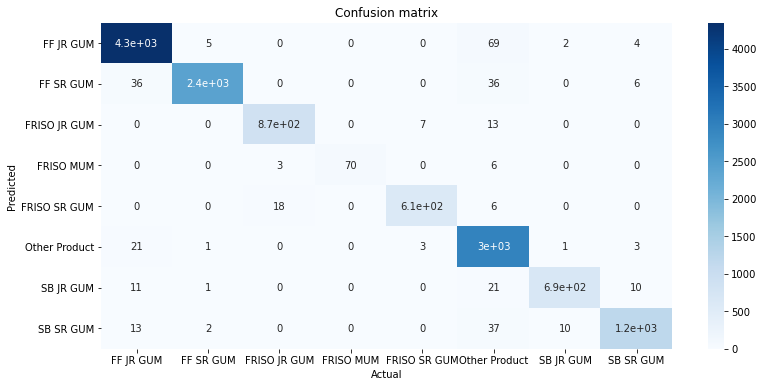

In [50]:
cv_aux_df = dft[['Stage']].drop_duplicates().sort_values('Stage')
conf_matrix = confusion_matrix(dft['Stage'], dft['Predicted'])
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=cv_aux_df['Stage'].values, 
            yticklabels=cv_aux_df['Stage'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [51]:
print("Classification report")
print(classification_report(dft['Stage'], dft['Predicted']))

Classification report
               precision    recall  f1-score   support

    FF JR GUM       0.98      0.98      0.98      4429
    FF SR GUM       1.00      0.97      0.98      2482
 FRISO JR GUM       0.98      0.98      0.98       891
    FRISO MUM       1.00      0.89      0.94        79
 FRISO SR GUM       0.98      0.96      0.97       638
Other Product       0.94      0.99      0.96      2998
    SB JR GUM       0.98      0.94      0.96       736
    SB SR GUM       0.98      0.95      0.97      1255

     accuracy                           0.97     13508
    macro avg       0.98      0.96      0.97     13508
 weighted avg       0.98      0.97      0.97     13508

